In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import igrins_mod as ig # Custom module file for igrins shenanigans

import glob
import os
import warnings

import astropy.units as u
# from astropy.modeling import models, fitting
from astroquery.nist import Nist # atomic lines
# from astroquery.linelists.cdms import CDMS # molecular lines?

# from specutils import Spectrum1D
# from specutils.fitting import fit_generic_continuum
from scipy.stats import chisquare
from scipy.integrate import trapz, simpson
from scipy.optimize import curve_fit
from scipy.signal import medfilt

# from astropy.io import ascii
from astropy.io import fits

# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

%matplotlib inline

# Things that should only have to be defined once, here at the top
---

In [8]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

c = 299792458  # speed of light m/s

# Use Normalized (single) Gaussian Distribution
def gaussian_func(x, ampl, center, std):
    return ((ampl) / (std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - center) / std) ** 2)) + 1

# Reduced and order-merged data filepath 
# Laptop Path
data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"

# File path for figures to live in
fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-SpectraIGRINS_figs\\standards_spectra"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path + "/merged_standards/m*.fits")
standard_table = pd.read_csv('./standard_table_v2.txt', index_col=0)  # csv of standards with file and Spectral Type, c/v TBA

early_k = ('1', '2', '3', '4', '5')
# Only want to look at the K types for the moment
standard_table_k = standard_table[standard_table['Spectral_Type'].str.startswith(('K1', 'K2', 'K5'))]

standard_shift = standard_table['Wavelength Shift'].values
standard_list = standard_table['Source'].values

hops_table = pd.read_csv('./hops_table.txt')
hops_list = hops_table['Source']

# Determine the maximum length of flux arrays for the standards
max_flux_length = max(len(fits.getdata(file)[1]) for file in standard_list)
max_wavelen_length = max(len(fits.getdata(file)[0]) for file in standard_list)
max_snr_length = max(len(fits.getdata(file)[2]) for file in standard_list)

hops_flux_length = max(len(fits.getdata(file)[1]) for file in hops_table['Source'])
hops_wavelen_length = max(len(fits.getdata(file)[0]) for file in hops_table['Source'])
hops_snr_length = max(len(fits.getdata(file)[2]) for file in hops_table['Source'])

# Initialize stacks with NaN values
wavelen_stack = np.full((max_wavelen_length, len(standard_list)), np.nan)
raw_flux_stack = np.full((max_flux_length, len(standard_list)), np.nan)
snr_stack = np.full((max_snr_length, len(standard_list)), np.nan)
raw_flux_err_stack = np.full((max_snr_length, len(standard_list)), np.nan)

hops_wavelen_stack = np.full((max_wavelen_length, len(hops_table)), np.nan)
hops_raw_flux_stack = np.full((max_flux_length, len(hops_table)), np.nan)
hops_snr_stack = np.full((max_snr_length, len(hops_table)), np.nan)
hops_raw_flux_err_stack = np.full((max_snr_length, len(hops_table)), np.nan)


# Fill stacks with data
for i, file in enumerate(standard_list):
    # Get wavelength, flux, snr per resolution element data
    data = fits.getdata(file)
    wavelen, flux, snr = data[0], data[1], data[2]
    
    # Clean data a bit
    snr_min = 50  # Minimum SNR
    snr_max = 1e4  # Maximum SNR
    snr_cut = (snr > snr_min)  # & (snr < snr_max)  # Bitwise SNR masking

    flux_min = 10000  # Minimum flux
    flux_cut = flux > flux_min  # Bitwise flux masking

    wavelen_min = 2.0
    wavelen_max = 2.4
    wavelen_cut = (wavelen > wavelen_min) & (wavelen < wavelen_max)

    # Apply masks and remove NaNs and infs
    mask = flux_cut & wavelen_cut & snr_cut
    
    wavelen = wavelen[mask]
    flux = flux[mask]
    snr = snr[mask]

    # Remove NaNs and infs from wavelen, flux, and snr arrays
    valid_indices = ~np.isnan(wavelen) & ~np.isnan(flux) & ~np.isnan(snr)
    
    wavelen = wavelen[valid_indices] - standard_shift[i]
    flux = flux[valid_indices]
    snr = snr[valid_indices]

    # Check for NaNs in the final arrays
    if np.any(np.isnan(wavelen)) or np.any(np.isnan(flux)) or np.any(np.isnan(snr)):
        print(f"NaNs found in data for file {file} after cleaning")

    wavelen_stack[:len(wavelen), i] = wavelen  # Wavelength arrays for each standard
    raw_flux_stack[:len(flux), i] = flux
    snr_stack[:len(snr), i] = snr
    raw_flux_err_stack[:len(flux), i] = flux / snr

for i, file in enumerate(hops_list):
    # Get wavelength, flux, snr per resolution element data
    data = fits.getdata(file)
    wavelen, flux, snr = data[0], data[1], data[2]
    
    # Clean data a bit
    snr_min = 50  # Minimum SNR
    snr_max = 1e4  # Maximum SNR
    snr_cut = (snr > snr_min)  # & (snr < snr_max)  # Bitwise SNR masking

    flux_min = 10000  # Minimum flux
    flux_cut = flux > flux_min  # Bitwise flux masking

    wavelen_min = 2.0
    wavelen_max = 2.4
    wavelen_cut = (wavelen > wavelen_min) & (wavelen < wavelen_max)

    # Apply masks and remove NaNs and infs
    mask = flux_cut & wavelen_cut & snr_cut
    
    wavelen = wavelen[mask]
    flux = flux[mask]
    snr = snr[mask]

    # Remove NaNs and infs from wavelen, flux, and snr arrays
    valid_indices = ~np.isnan(wavelen) & ~np.isnan(flux) & ~np.isnan(snr)
    
    wavelen = wavelen[valid_indices] - standard_shift[i]
    flux = flux[valid_indices]
    snr = snr[valid_indices]

    # Check for NaNs in the final arrays
    if np.any(np.isnan(wavelen)) or np.any(np.isnan(flux)) or np.any(np.isnan(snr)):
        print(f"NaNs found in data for file {file} after cleaning")

    hops_wavelen_stack[:len(wavelen), i] = wavelen  # Wavelength arrays for each standard
    hops_raw_flux_stack[:len(flux), i] = flux
    hops_snr_stack[:len(snr), i] = snr
    hops_raw_flux_err_stack[:len(flux), i] = flux / snr


C:\Users\Savio\AppData\Local\Temp\ipykernel_22432\2232651846.py:65: RuntimeWarning: divide by zero encountered in divide
  norm_flux = flux/median_flux


In [9]:
# Directly query NIST to find line features in K-band
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore') 
    lines_table = Nist.query(2.08*u.um,2.35*u.um,
                    linename = 'Na I, Sc I, Si I, Fe I,Fe II, Al I, Mg I, Ca I, H I, Ti I',
                    energy_level_unit='eV',output_order='wavelength')

igrins_wav_cut = (lines_table['Observed'] > 2.08) & (lines_table['Observed'] < 2.35)
lines_table = lines_table[igrins_wav_cut]
# lines_table = pd.read_csv('lines_table.txt')

# Make masks for the table of all the lines just in case I want to peek at certain transitions/wavelengths
na1_mask = lines_table['Spectrum'] == 'Na I'
sc1_mask = lines_table['Spectrum'] == 'Sc I'
si1_mask = lines_table['Spectrum'] == 'Si I'
fe1_mask = lines_table['Spectrum'] == 'Fe I'
fe2_mask = lines_table['Spectrum'] == 'Fe II'
al1_mask = lines_table['Spectrum'] == 'Al I'
mg1_mask = lines_table['Spectrum'] == 'Mg I'
ca1_mask = lines_table['Spectrum'] == 'Ca I'
h1_mask  = lines_table['Spectrum'] == 'H I'
ti1_mask = lines_table['Spectrum'] == 'Ti I'

# Just add all the masks to a list for the sake of my plotting a few cells down
mask_list = [na1_mask,sc1_mask,si1_mask,fe1_mask,al1_mask,mg1_mask,ca1_mask,h1_mask,ti1_mask]
color_list = ['purple', 'orange', 'green', 'blue', 'brown', 'crimson', 'olive', 'cyan', 'darkgreen']

# Veiling (?) Lines
Fe I
 
    2.084 (lines_table[fe1_mask][6]),
    
    2.275 (lines_table[fe1_mask][109]),
    
    2.284 (lines_table[fe1_mask][115])

Si I ~ 2.092 (lines_table[si1_mask][0])

Mg I ~ 2.106 (lines_table[mg1_mask][0]), 2.282 lines_table[mg1_mask][11]

Al I ~ 2.11 (lines_table[al1_mask][1])

Ca I ~ 2.283

Ti I ~ 2.29 (lines_table[ti1_mask][69])

CO (2-0) > 2.294

In [10]:
lines_table[ca1_mask]

<Table length=3>
Spectrum Observed  Ritz Transition  Rel. ...   Upper level   Type   TP   Line
  str5   float64  str18  float64   str17 ...      str59      str5 str17 str20
-------- -------- ----- ---------- ----- ... --------------- ---- ----- -----
    Ca I  2.26141    --    4422.02    20 ... |             |   --    -- L6097
    Ca I  2.26311    --   4418.698    25 ... |             |   --    -- L6097
    Ca I 2.265741    --   4413.567    30 ... |             |   --    -- L6097

## Fe I 2.08465 $\mu m$

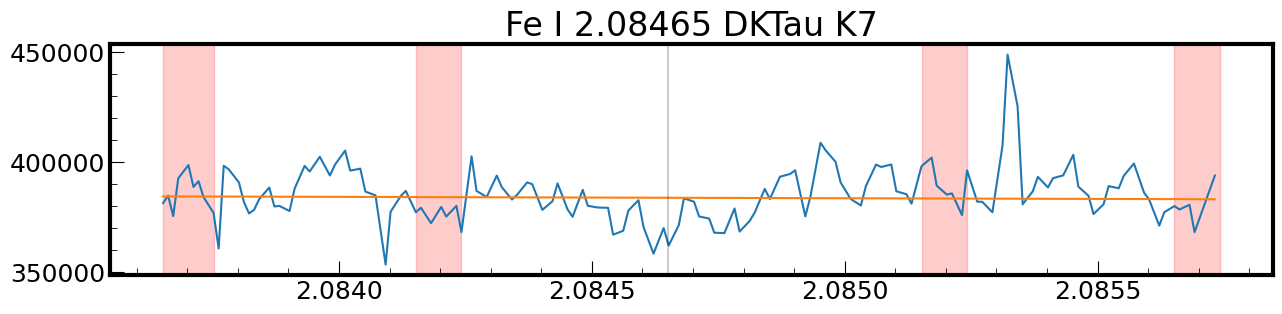

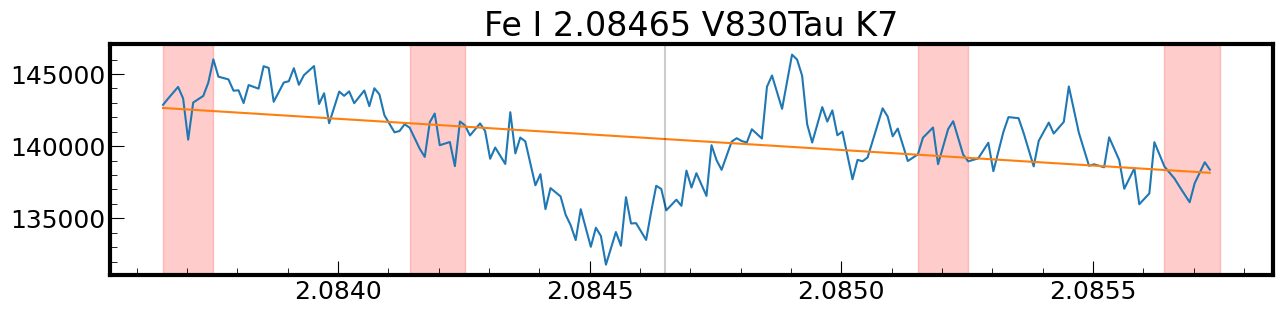

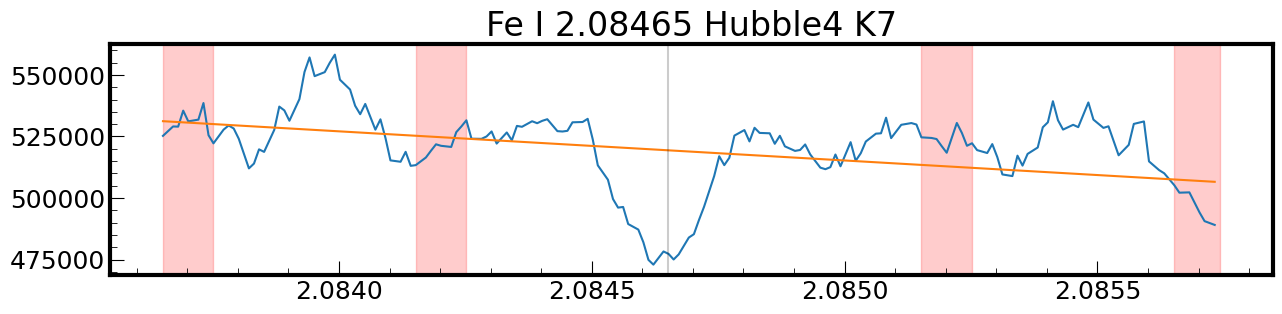

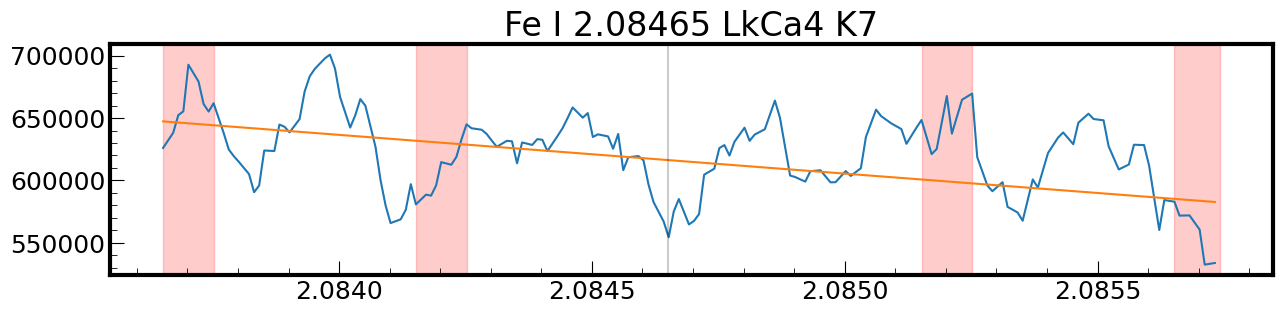

In [11]:
line_name = lines_table[fe1_mask][0]['Spectrum']
line_center = lines_table[fe1_mask][6]['Observed']

# from igrins_mod import local_continuum_fit
continuum_stack = []
norm_flux_stack = []
reg_idx_stack = []

# regions [left point,width]
regions = [(-100,10), (-50,10), (50,10), (100,10)]

# number of regions I use and subtract 1 since index starts at 0
n = len(regions)-1
poly_deg = 1
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))
    continuum, region_indices = ig.local_continuum_fit(wavelen_stack[:,i],
                                                    raw_flux_stack[:,i],
                                                    poly_order = poly_deg,
                                                    line_center = line_center,
                                                    spec_res = spec_res,
                                                    regions = regions)
    # append indices to list of indices
    reg_idx_stack.append(region_indices)
    
    # append to list of the local continuum arrays
    continuum_stack.append(continuum)

    # normalize flux by dividing the flux by the continuum and create a list
    norm_flux = raw_flux_stack[region_indices[0][0]:region_indices[n][1],i]/continuum_stack[i]
    norm_flux_stack.append(norm_flux)

    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], raw_flux_stack[region_indices[0][0]:region_indices[n][1],i])
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], continuum_stack[i])
    plt.axvline(line_center,alpha=0.2,color='black')

    for j in range(len(regions)):
        plt.axvspan(wavelen_stack[region_indices[n-j][0],i],wavelen_stack[region_indices[n-j][1],i],color='red',alpha=.2)

    plt.title(f"{line_name} {line_center} {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.show()

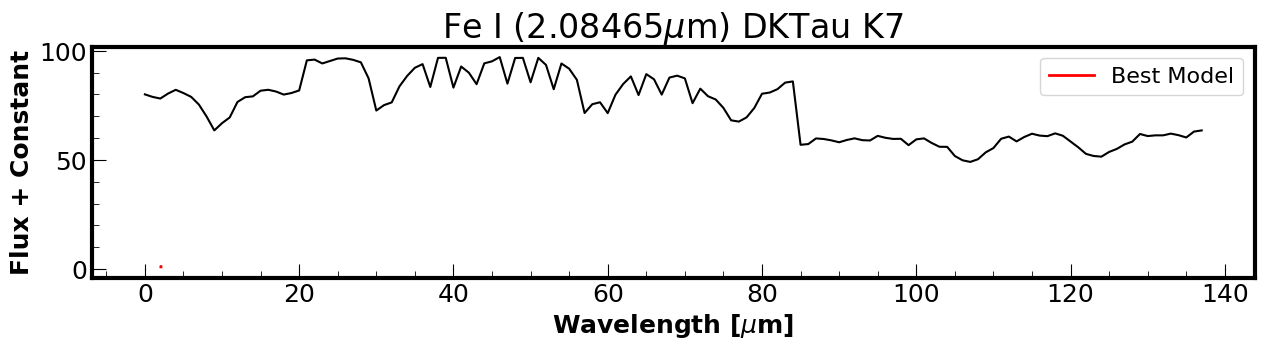

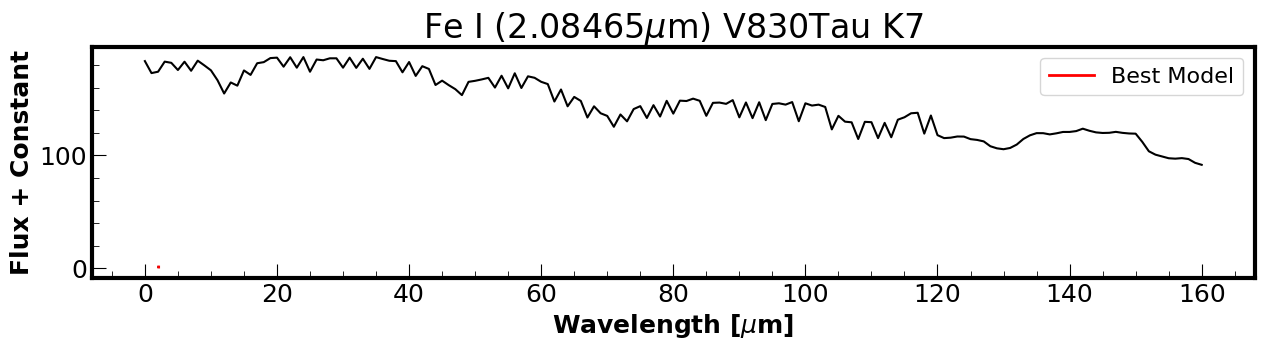

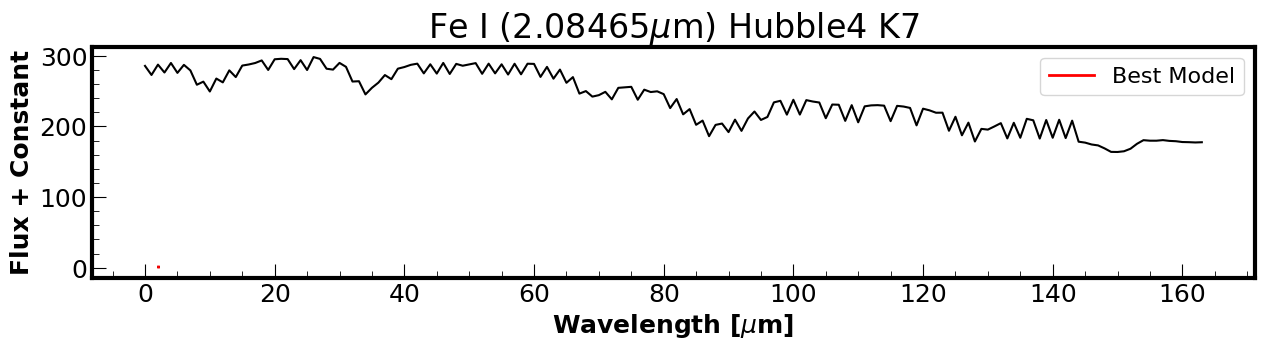

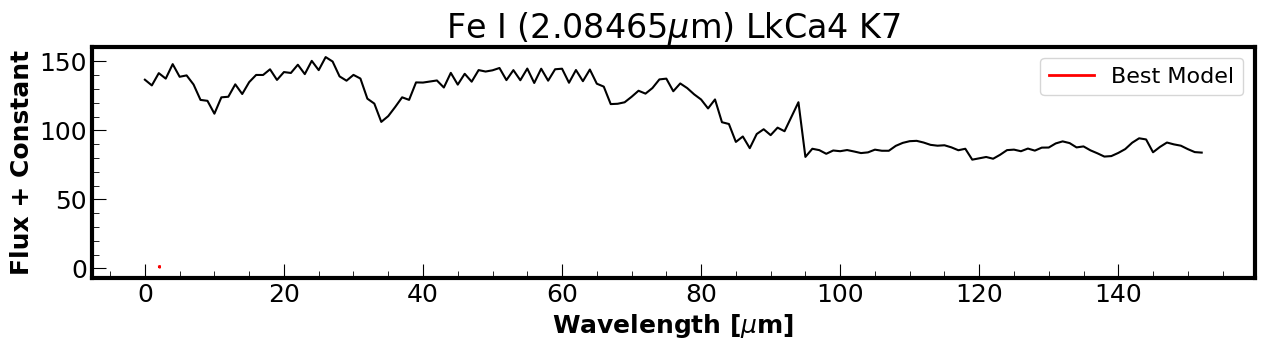

In [12]:
amplitude1_stack = []
center1_stack = []
sigma_stack = []

pcov_stack = []

best_model_stack = []

flux_constant = np.linspace(0,-1,len(standard_table_k))

# Define initial parameters for Gaussian fitting
init_params = (0.1, lines_table[fe1_mask][6]['Observed'], spec_res)


# wavelen_stack[region_indices[0][0]:region_indices[2][1],i],raw_flux_stack[region_indices[0][0]:region_indices[2][1],i]

for i in range(len(standard_table_k)):    
    # Perform Gaussian fitting for the current source
    popt, pcov, best_model = ig.gauss_fit(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        init_params,
                                        50000)

    amplitude1_stack.append(popt[0])
    center1_stack.append(popt[1])
    sigma_stack.append(popt[2])

    pcov_stack.append(pcov)
    best_model_stack.append(best_model)

# for i in range(len(standard_list)):
    # fwhm = 2*np.sqrt(2*np.log(2))*sigma1_stack[i]
    # area = np.abs(amplitude_stack[i]*sigma_stack[i]*np.sqrt(2*np.pi))
    # ew = np.trapz(1-best_model_stack[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    
fe1_2_0846_fit = []

for i in range(len(standard_table_k)):
    fe1_2_0846_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude1_stack[i],center1_stack[i],sigma_stack[i]))
    
    area_int = trapz(1-best_model_stack[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    area_v2 = np.abs(amplitude1_stack[i])*sigma_stack[i]*np.sqrt(2*np.pi)

    # print(f'{area_int} {area_v2}')

ew1_stack = [] # empty list to load in equivalent widths

# Integate 1-best_model to get the areas (equivalent widths) of each component Gaussian
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))

    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], c='black')
    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],best_model_stack[i],c='red',lw=2,label='Best Model')
    

    # plt.fill_between(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],best_model_stack[i],0,color='red',alpha=0.2)
    # Fe I
    # plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],fe1_2_0846_fit[i])#, label = 'Fe I 2.2263 Fit')
    # plt.ylim(0)
    plt.ylabel('Flux + Constant')
    plt.xlabel(r'Wavelength [$\mu$m]')

    plt.title(f"{line_name} ({line_center}$\mu$m) {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.legend(loc='best')
    plt.show()

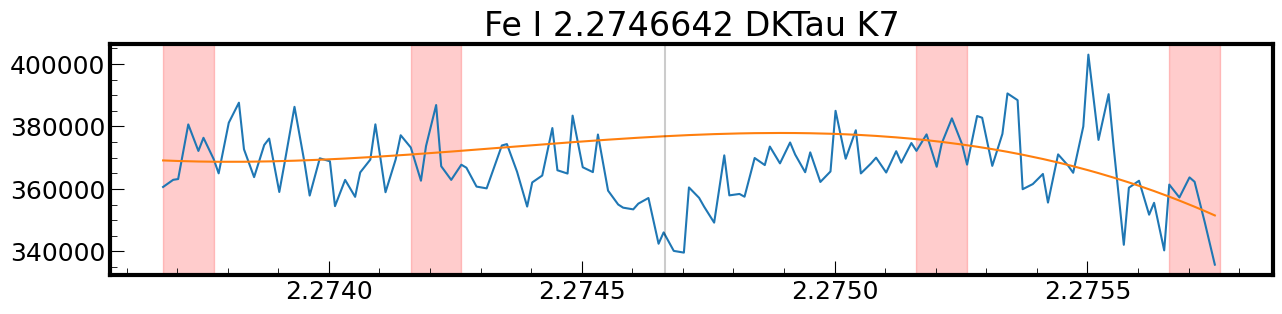

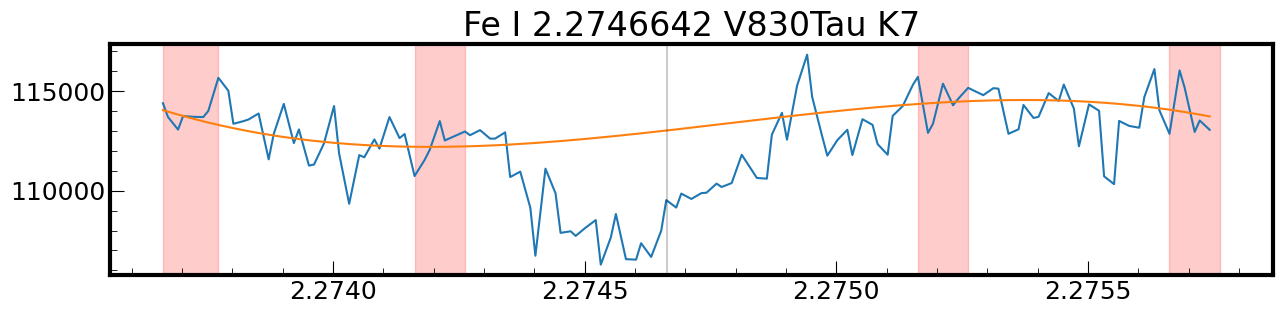

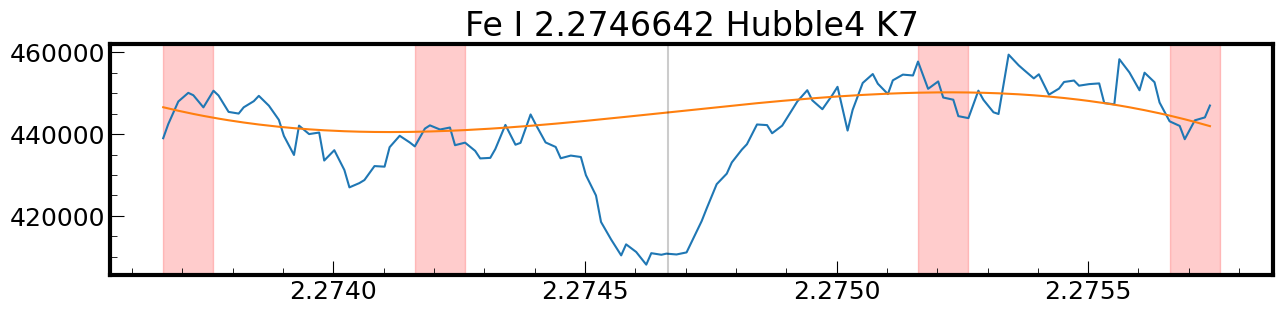

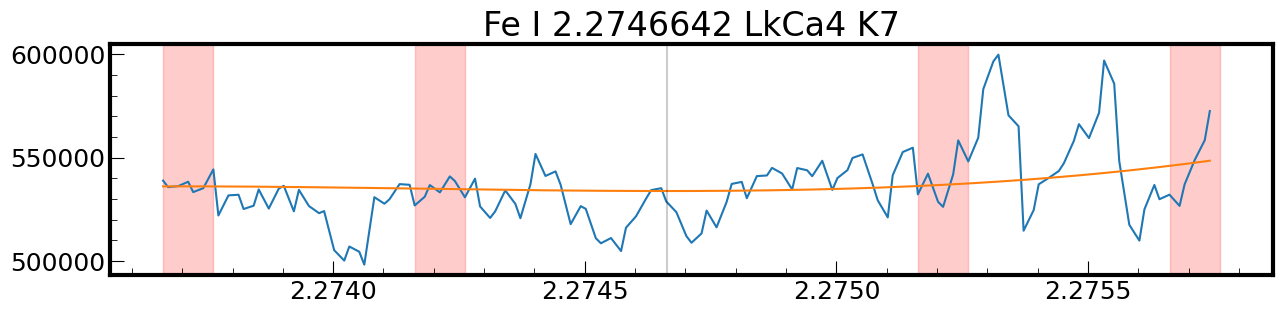

In [13]:
# Define the region for fitting
line_name = lines_table[fe1_mask][0]['Spectrum'] # Species
line_center = lines_table[fe1_mask][109]['Observed'] # Wavelength

# from igrins_mod import local_continuum_fit
continuum_stack = []
norm_flux_stack = []
reg_idx_stack = []

# regions [left point,width]
regions = [(-100,10), (-50,10), (50,10), (100,10)]

# number of regions I use and subtract 1 since index starts at 0
n = len(regions)-1
poly_deg = 3
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))
    continuum, region_indices = ig.local_continuum_fit(wavelen_stack[:,i],
                                                    raw_flux_stack[:,i],
                                                    poly_order = poly_deg,
                                                    line_center = line_center,
                                                    spec_res = spec_res,
                                                    regions = regions)
    # append indices to list of indices
    reg_idx_stack.append(region_indices)
    
    # append to list of the local continuum arrays
    continuum_stack.append(continuum)

    # normalize flux by dividing the flux by the continuum and create a list
    norm_flux = raw_flux_stack[region_indices[0][0]:region_indices[n][1],i]/continuum_stack[i]
    norm_flux_stack.append(norm_flux)

    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], raw_flux_stack[region_indices[0][0]:region_indices[n][1],i])
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], continuum_stack[i])
    plt.axvline(line_center,alpha=0.2,color='black')

    for j in range(len(regions)):
        plt.axvspan(wavelen_stack[region_indices[n-j][0],i],wavelen_stack[region_indices[n-j][1],i],color='red',alpha=.2)

    plt.title(f"{line_name} {line_center} {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.show()

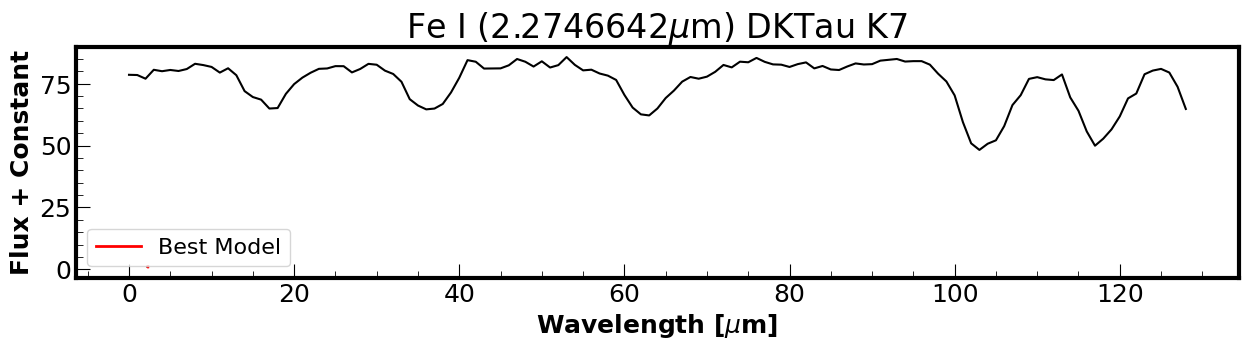

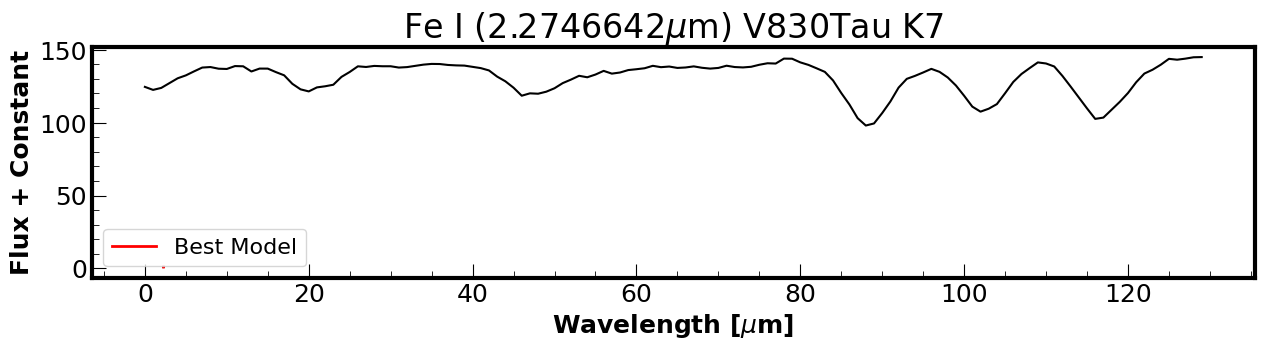

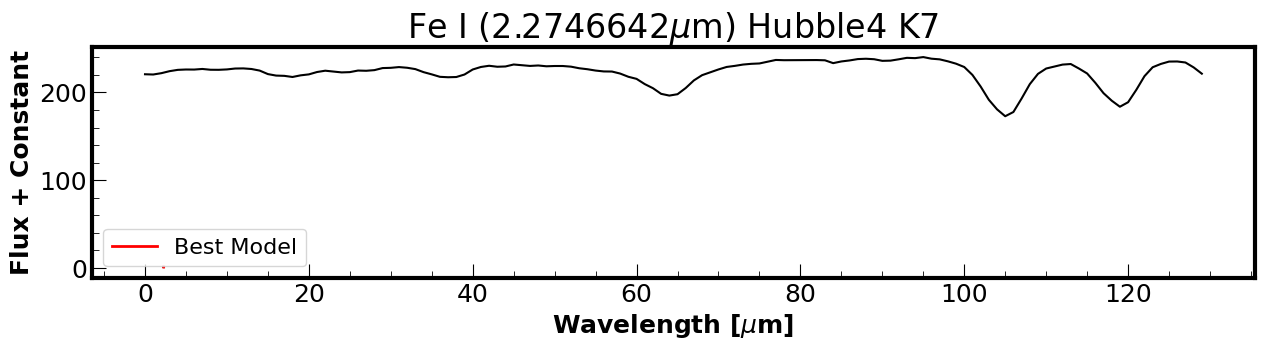

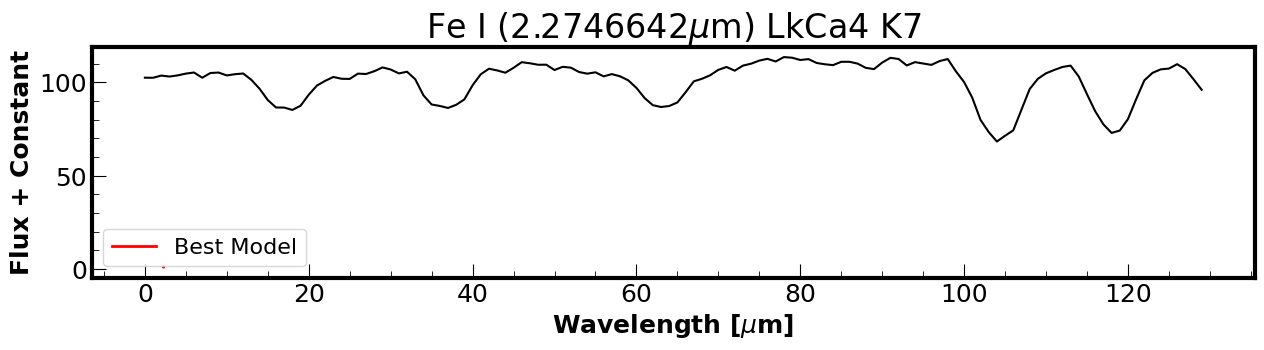

In [14]:
amplitude1_stack = []
center1_stack = []
sigma_stack = []

pcov_stack = []

best_model_stack = []

flux_constant = np.linspace(0,-1,len(standard_table_k))

# Define initial parameters for Gaussian fitting
init_params = (0.1, line_center, spec_res)


# wavelen_stack[region_indices[0][0]:region_indices[2][1],i],raw_flux_stack[region_indices[0][0]:region_indices[2][1],i]

for i in range(len(standard_table_k)):    
    # Perform Gaussian fitting for the current source
    popt, pcov, best_model = ig.gauss_fit(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        init_params,
                                        50000)

    amplitude1_stack.append(popt[0])
    center1_stack.append(popt[1])
    sigma_stack.append(popt[2])

    pcov_stack.append(pcov)
    best_model_stack.append(best_model)

# for i in range(len(standard_list)):
    # fwhm = 2*np.sqrt(2*np.log(2))*sigma1_stack[i]
    # area = np.abs(amplitude_stack[i]*sigma_stack[i]*np.sqrt(2*np.pi))
    # ew = np.trapz(1-best_model_stack[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    
fe1_2_2746_fit = []

for i in range(len(standard_table_k)):
    fe1_2_2746_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude1_stack[i],center1_stack[i],sigma_stack[i]))
    
    area_int = trapz(1-best_model_stack[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    area_v2 = np.abs(amplitude1_stack[i])*sigma_stack[i]*np.sqrt(2*np.pi)

    # print(f'{area_int} {area_v2}')

ew1_stack = [] # empty list to load in equivalent widths

# Integate 1-best_model to get the areas (equivalent widths) of each component Gaussian
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))

    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], c='black')
    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],best_model_stack[i],c='red',lw=2,label='Best Model')
    

    # plt.fill_between(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],best_model_stack[i],0,color='red',alpha=0.2)
    # Fe I
    # plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],fe1_2_0846_fit[i])#, label = 'Fe I 2.2263 Fit')
    # plt.ylim(0)
    plt.ylabel('Flux + Constant')
    plt.xlabel(r'Wavelength [$\mu$m]')

    plt.title(f"{line_name} ({line_center}$\mu$m) {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.legend(loc='best')
    plt.show()

## Si 1 2.0922

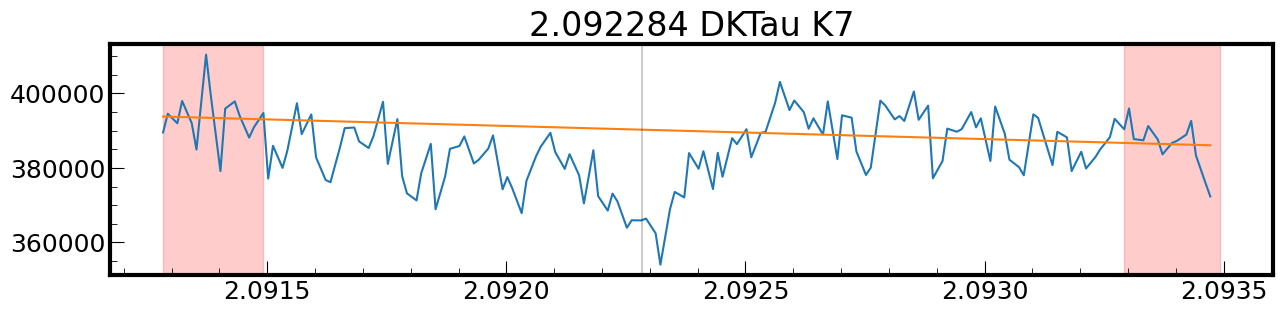

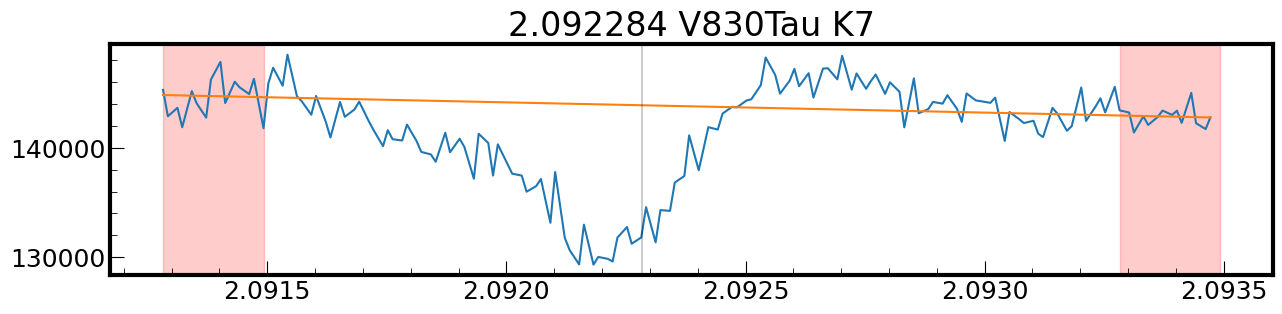

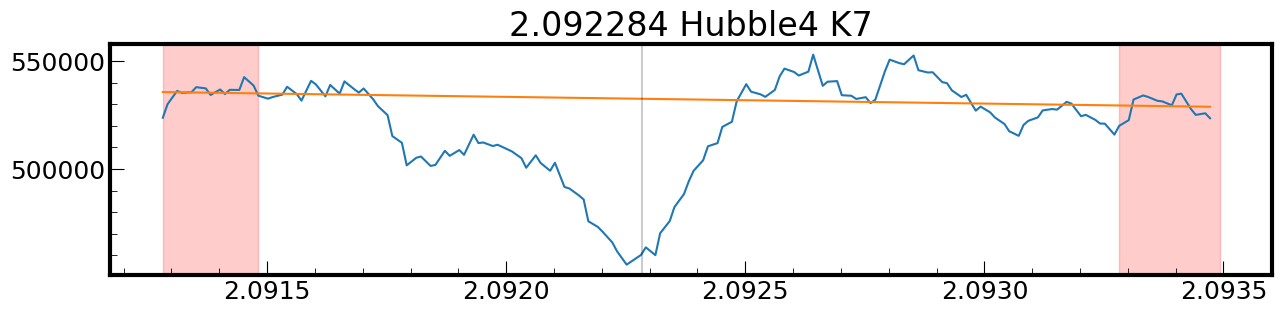

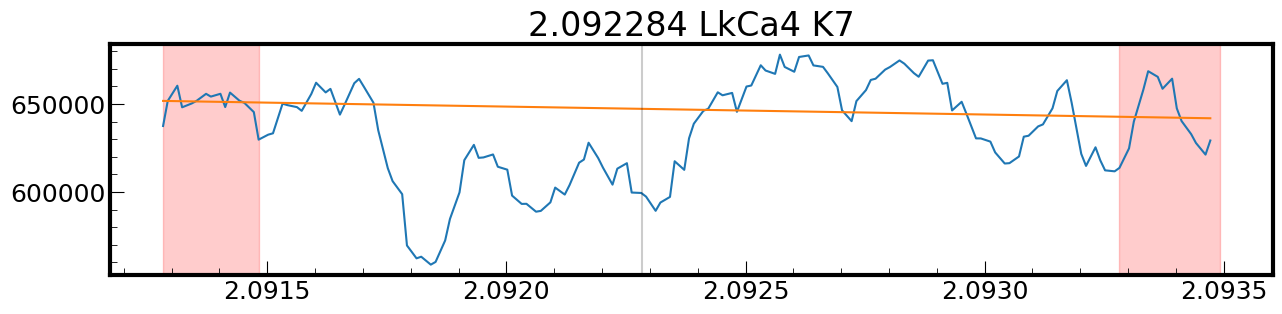

In [15]:
# Define the region for fitting
line_name = lines_table[si1_mask][0]['Spectrum'] # Species
line_center = lines_table[si1_mask][0]['Observed'] # Wavelength

# from igrins_mod import local_continuum_fit
continuum_stack = []
norm_flux_stack = []
reg_idx_stack = []

# regions [left point,width]
regions = [(-100,20), (100,20)]

# number of regions I use and subtract 1 since index starts at 0
n = len(regions)-1
poly_deg = 1
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))
    continuum, region_indices = ig.local_continuum_fit(wavelen_stack[:,i],
                                                    raw_flux_stack[:,i],
                                                    poly_order = poly_deg,
                                                    line_center = line_center,
                                                    spec_res = spec_res,
                                                    regions = regions)
    # append indices to list of indices
    reg_idx_stack.append(region_indices)
    
    # append to list of the local continuum arrays
    continuum_stack.append(continuum)

    # normalize flux by dividing the flux by the continuum and create a list
    norm_flux = raw_flux_stack[region_indices[0][0]:region_indices[n][1],i]/continuum_stack[i]
    norm_flux_stack.append(norm_flux)

    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], raw_flux_stack[region_indices[0][0]:region_indices[n][1],i])
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], continuum_stack[i])
    plt.axvline(line_center,alpha=0.2,color='black')

    for j in range(len(regions)):
        plt.axvspan(wavelen_stack[region_indices[n-j][0],i],wavelen_stack[region_indices[n-j][1],i],color='red',alpha=.2)

    plt.title(f"{line_center} {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.show()

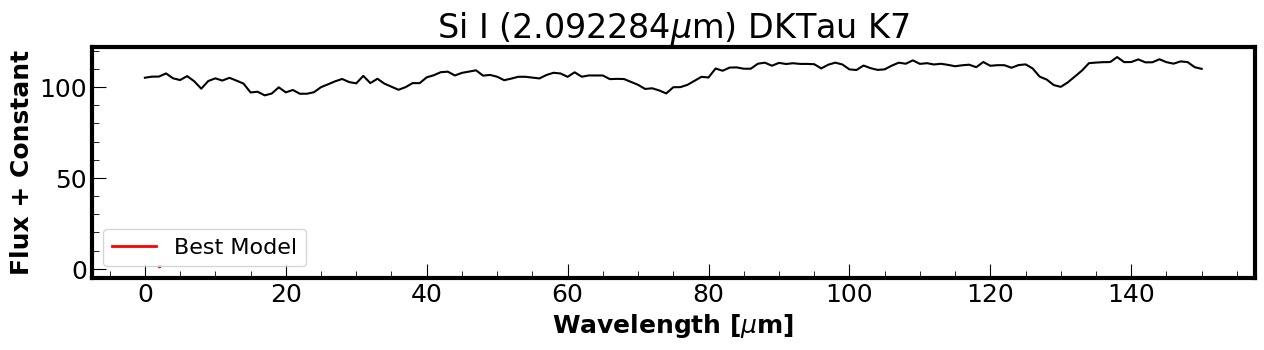

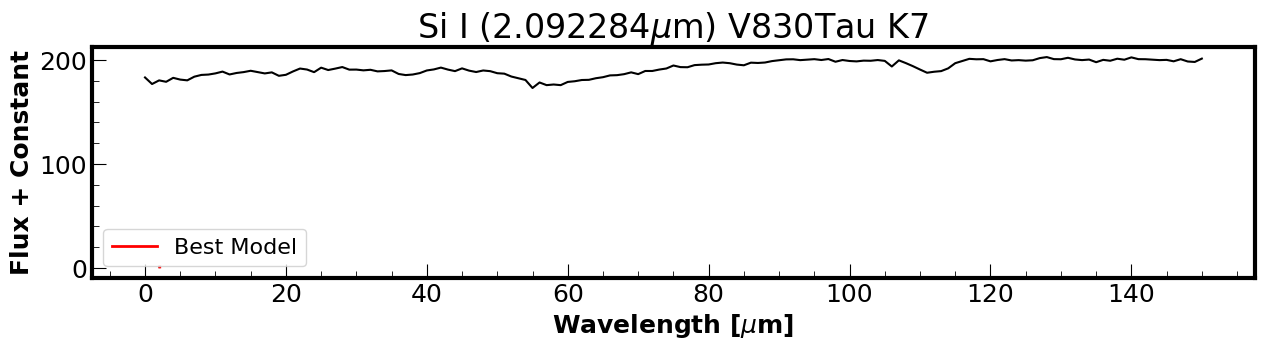

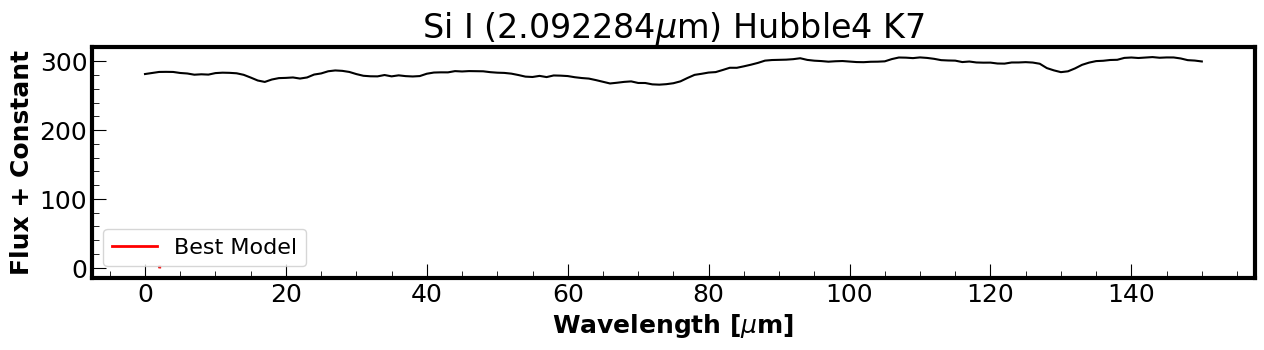

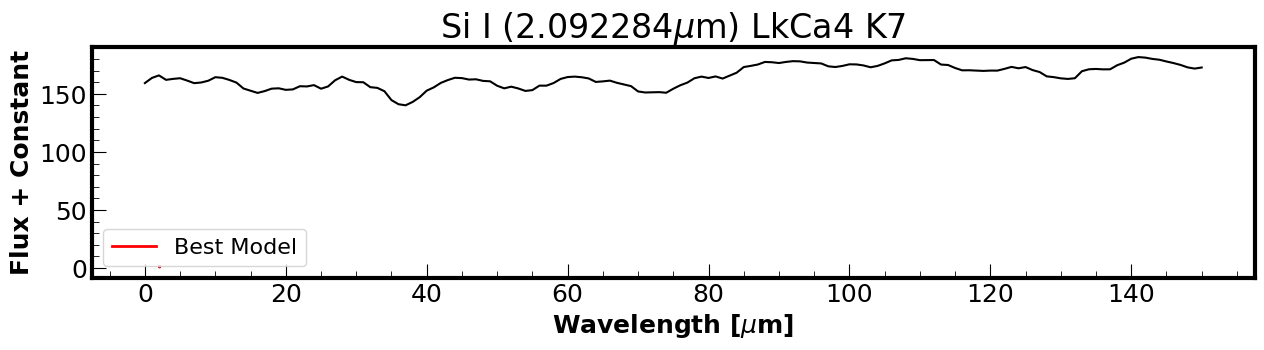

In [16]:
amplitude1_stack = []
center1_stack = []
sigma_stack = []

pcov_stack = []

best_model_stack = []

flux_constant = np.linspace(0,-1,len(standard_table_k))

# Define initial parameters for Gaussian fitting
init_params = (0.1, lines_table[si1_mask][0]['Observed'], spec_res)


for i in range(len(standard_table_k)):    
    # Perform Gaussian fitting for the current source
    popt, pcov, best_model = ig.gauss_fit(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        init_params,
                                        50000)

    amplitude1_stack.append(popt[0])
    center1_stack.append(popt[1])
    sigma_stack.append(popt[2])

    pcov_stack.append(pcov)
    best_model_stack.append(best_model)

# for i in range(len(standard_list)):
    # fwhm = 2*np.sqrt(2*np.log(2))*sigma1_stack[i]
    # area = np.abs(amplitude_stack[i]*sigma_stack[i]*np.sqrt(2*np.pi))
    # ew = np.trapz(1-best_model_stack[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    
si1_2_0922_fit = []

for i in range(len(standard_table_k)):
    si1_2_0922_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude1_stack[i],center1_stack[i],sigma_stack[i]))
    
    area_int = trapz(1-best_model_stack[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    area_v2 = np.abs(amplitude1_stack[i])*sigma_stack[i]*np.sqrt(2*np.pi)

    # print(f'{area_int} {area_v2}')

ew1_stack = [] # empty list to load in equivalent widths

# Integate 1-best_model to get the areas (equivalent widths) of each component Gaussian
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))

    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], c='black')
    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],best_model_stack[i],c='red',lw=2,label='Best Model')
    
    plt.ylabel('Flux + Constant')
    plt.xlabel(r'Wavelength [$\mu$m]')

    plt.title(f"{line_name} ({line_center}$\mu$m) {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.legend(loc='best')
    plt.show()

## Mg I 2.1065

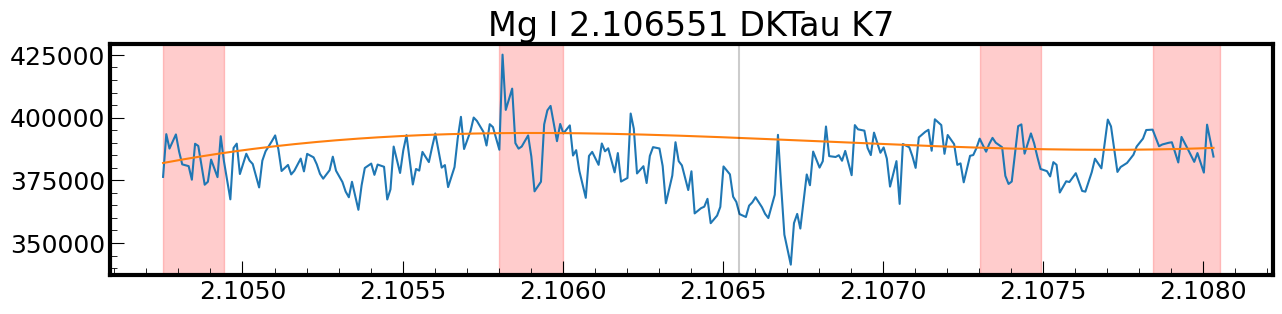

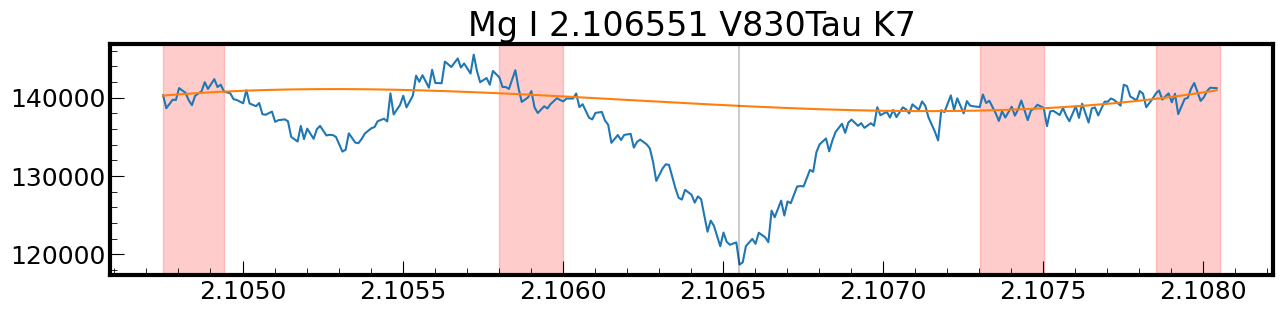

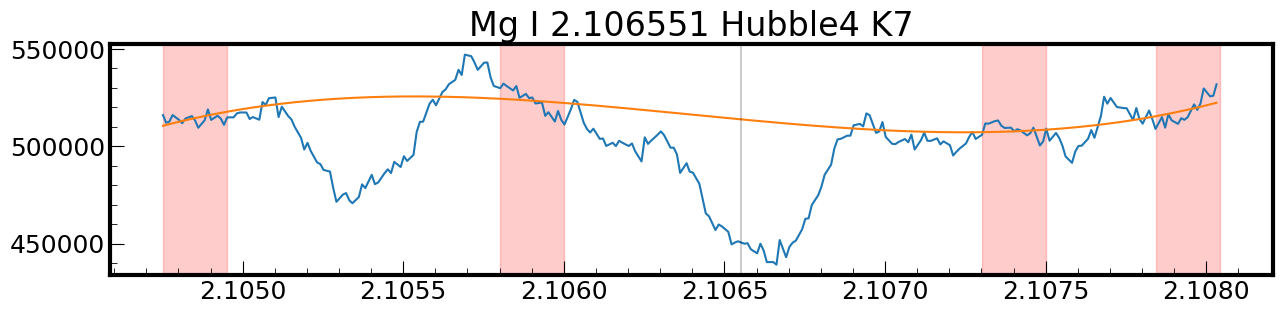

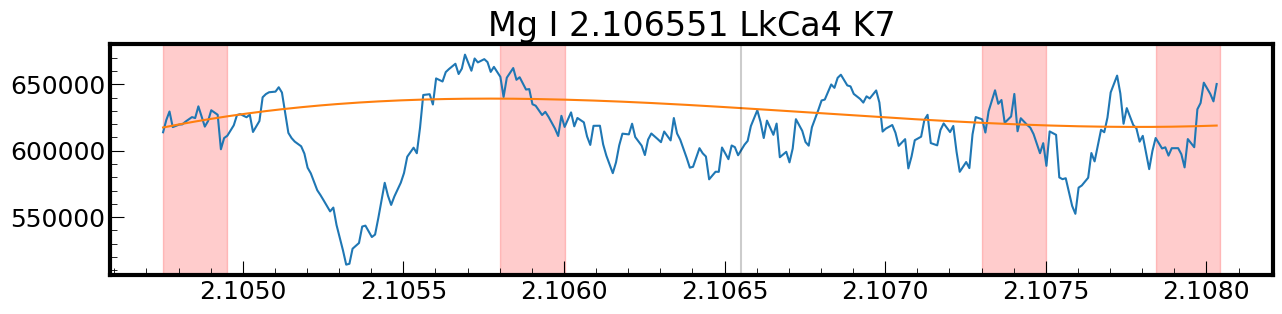

In [17]:
# Define the region for fitting
line_name = lines_table[mg1_mask][0]['Spectrum'] # Species
line_center = lines_table[mg1_mask][0]['Observed'] # Wavelength

# from igrins_mod import local_continuum_fit
continuum_stack = []
norm_flux_stack = []
reg_idx_stack = []

# regions [left point,width]
regions = [(-180,20), (-75,20), (75,20), (130,20)]

# number of regions I use and subtract 1 since index starts at 0
n = len(regions)-1
poly_deg = 3
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))
    continuum, region_indices = ig.local_continuum_fit(wavelen_stack[:,i],
                                                    raw_flux_stack[:,i],
                                                    poly_order = poly_deg,
                                                    line_center = line_center,
                                                    spec_res = spec_res,
                                                    regions = regions)
    # append indices to list of indices
    reg_idx_stack.append(region_indices)
    
    # append to list of the local continuum arrays
    continuum_stack.append(continuum)

    # normalize flux by dividing the flux by the continuum and create a list
    norm_flux = raw_flux_stack[region_indices[0][0]:region_indices[n][1],i]/continuum_stack[i]
    norm_flux_stack.append(norm_flux)

    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], raw_flux_stack[region_indices[0][0]:region_indices[n][1],i])
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], continuum_stack[i])
    plt.axvline(line_center,alpha=0.2,color='black')

    for j in range(len(regions)):
        plt.axvspan(wavelen_stack[region_indices[n-j][0],i],wavelen_stack[region_indices[n-j][1],i],color='red',alpha=.2)

    plt.title(f"{line_name} {line_center} {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.show()

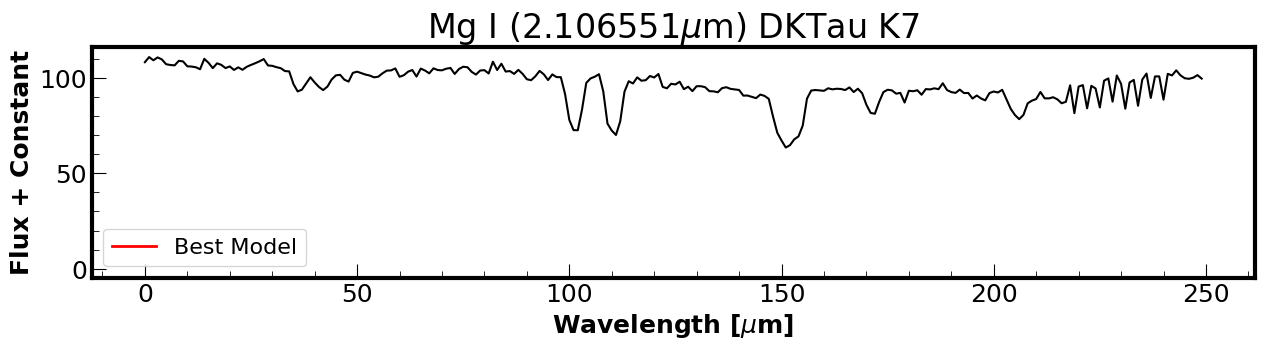

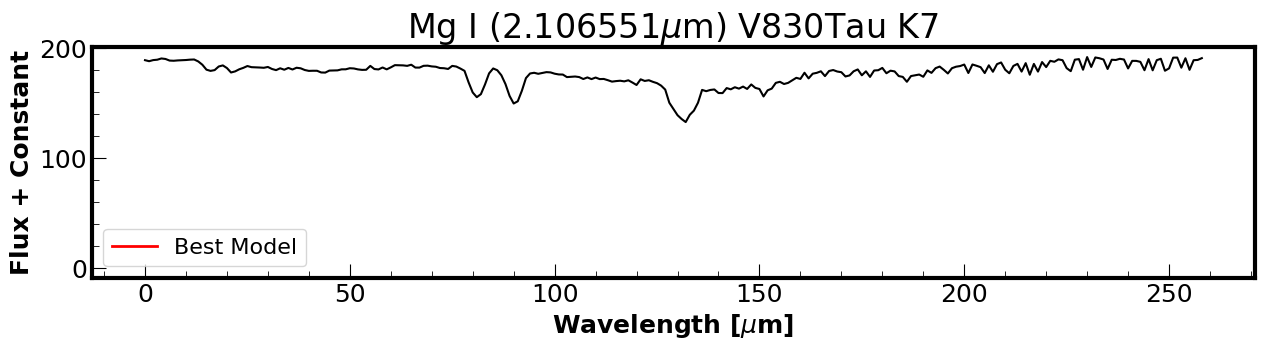

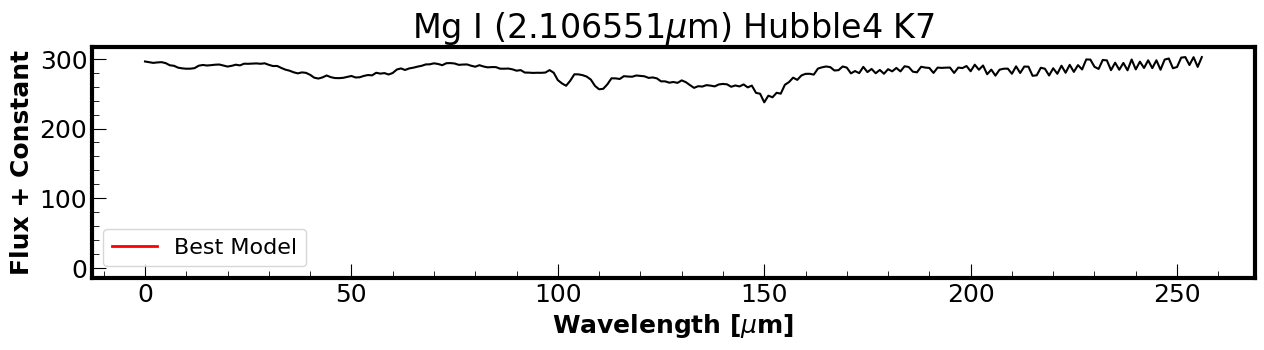

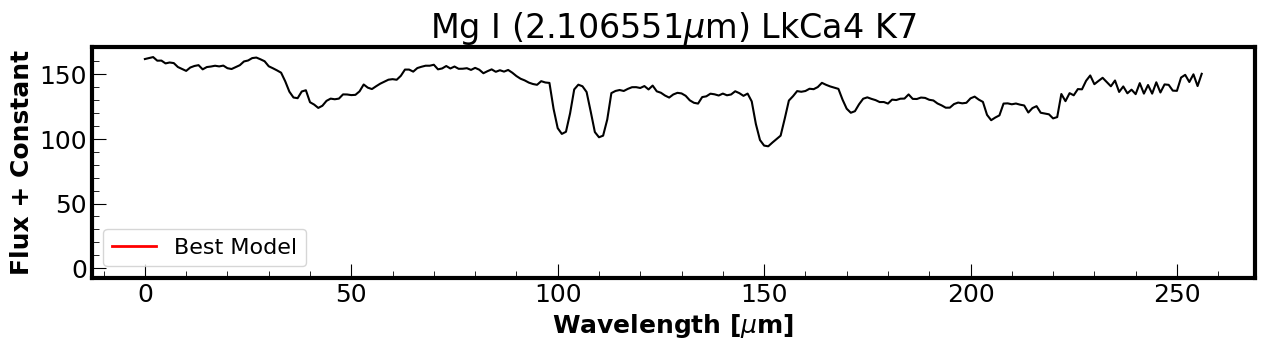

In [18]:
amplitude1_stack = []
center1_stack = []
sigma_stack = []

pcov_stack = []

best_model_stack = []

flux_constant = np.linspace(0,-1,len(standard_table_k))

# Define initial parameters for Gaussian fitting
init_params = (0.1, line_center, spec_res)


# wavelen_stack[region_indices[0][0]:region_indices[2][1],i],raw_flux_stack[region_indices[0][0]:region_indices[2][1],i]

for i in range(len(standard_table_k)):    
    # Perform Gaussian fitting for the current source
    popt, pcov, best_model = ig.gauss_fit(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        init_params,
                                        50000)

    amplitude1_stack.append(popt[0])
    center1_stack.append(popt[1])
    sigma_stack.append(popt[2])

    pcov_stack.append(pcov)
    best_model_stack.append(best_model)

# for i in range(len(standard_list)):
    # fwhm = 2*np.sqrt(2*np.log(2))*sigma1_stack[i]
    # area = np.abs(amplitude_stack[i]*sigma_stack[i]*np.sqrt(2*np.pi))
    # ew = np.trapz(1-best_model_stack[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    
mg1_2_1065_fit = []

for i in range(len(standard_table_k)):
    mg1_2_1065_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude1_stack[i],center1_stack[i],sigma_stack[i]))
    
    area_int = trapz(1-best_model_stack[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    area_v2 = np.abs(amplitude1_stack[i])*sigma_stack[i]*np.sqrt(2*np.pi)

    # print(f'{area_int} {area_v2}')

ew1_stack = [] # empty list to load in equivalent widths

# Integate 1-best_model to get the areas (equivalent widths) of each component Gaussian
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))

    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], c='black')
    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],best_model_stack[i],c='red',lw=2,label='Best Model')
    

    # plt.fill_between(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],best_model_stack[i],0,color='red',alpha=0.2)
    # Fe I
    # plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],fe1_2_0846_fit[i])#, label = 'Fe I 2.2263 Fit')
    # plt.ylim(0)
    plt.ylabel('Flux + Constant')
    plt.xlabel(r'Wavelength [$\mu$m]')

    plt.title(f"{line_name} ({line_center}$\mu$m) {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.legend(loc='best')
    plt.show()

## Al I 2.1169

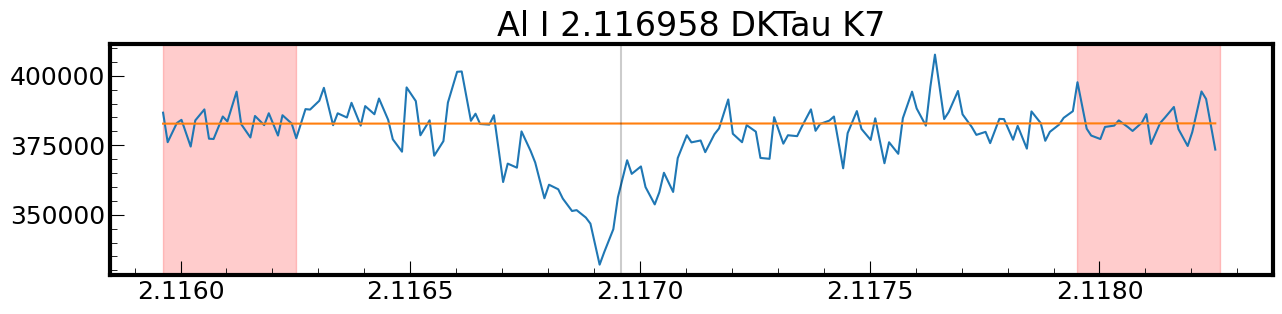

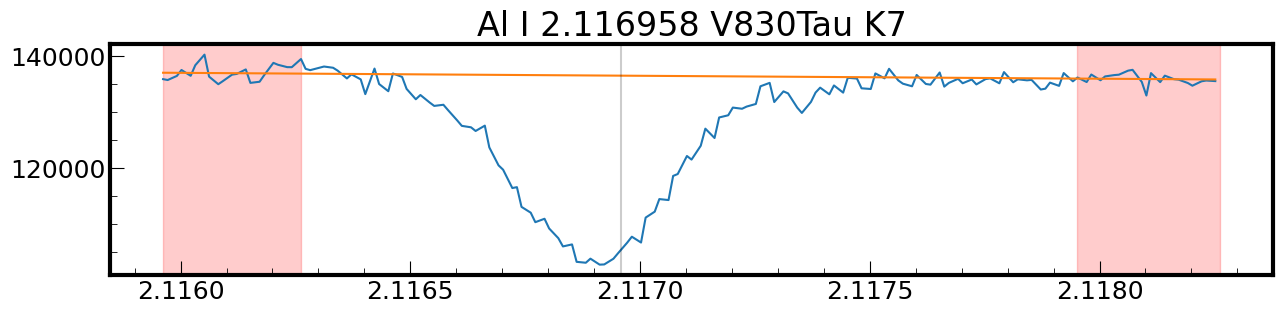

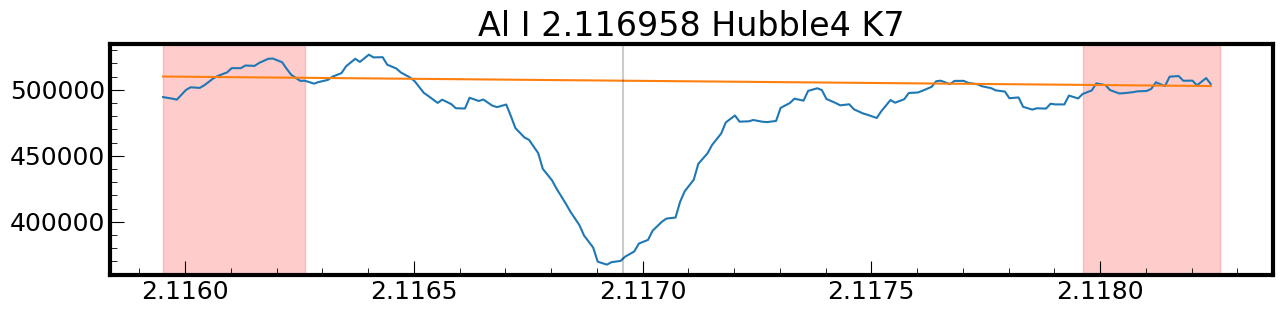

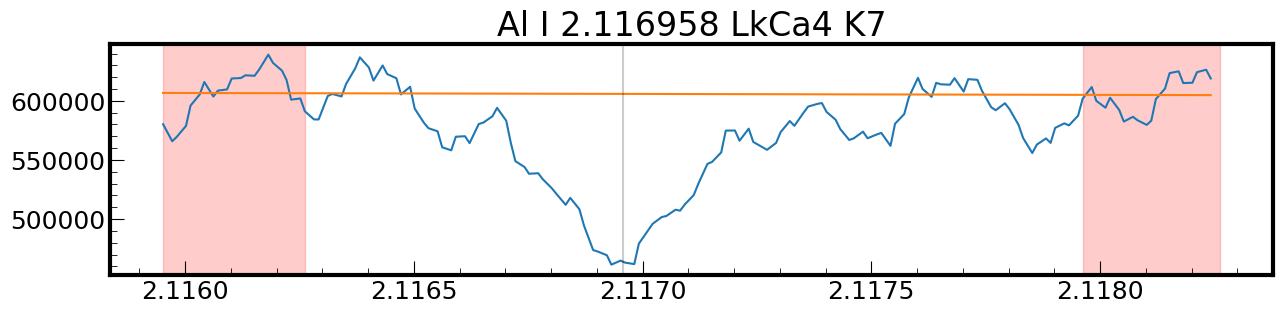

In [19]:
# Define the region for fitting
line_name = lines_table[al1_mask][0]['Spectrum'] # Species
line_center = lines_table[al1_mask][1]['Observed'] # Wavelength

# from igrins_mod import local_continuum_fit
continuum_stack = []
norm_flux_stack = []
reg_idx_stack = []

# regions [left point,width]
regions = [(-100,30), (100,30)]

# number of regions I use and subtract 1 since index starts at 0
n = len(regions)-1
poly_deg = 1
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))
    continuum, region_indices = ig.local_continuum_fit(wavelen_stack[:,i],
                                                    raw_flux_stack[:,i],
                                                    poly_order = poly_deg,
                                                    line_center = line_center,
                                                    spec_res = spec_res,
                                                    regions = regions)
    # append indices to list of indices
    reg_idx_stack.append(region_indices)
    
    # append to list of the local continuum arrays
    continuum_stack.append(continuum)

    # normalize flux by dividing the flux by the continuum and create a list
    norm_flux = raw_flux_stack[region_indices[0][0]:region_indices[n][1],i]/continuum_stack[i]
    norm_flux_stack.append(norm_flux)

    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], raw_flux_stack[region_indices[0][0]:region_indices[n][1],i])
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], continuum_stack[i])
    plt.axvline(line_center,alpha=0.2,color='black')

    for j in range(len(regions)):
        plt.axvspan(wavelen_stack[region_indices[n-j][0],i],wavelen_stack[region_indices[n-j][1],i],color='red',alpha=.2)

    plt.title(f"{line_name} {line_center} {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.show()

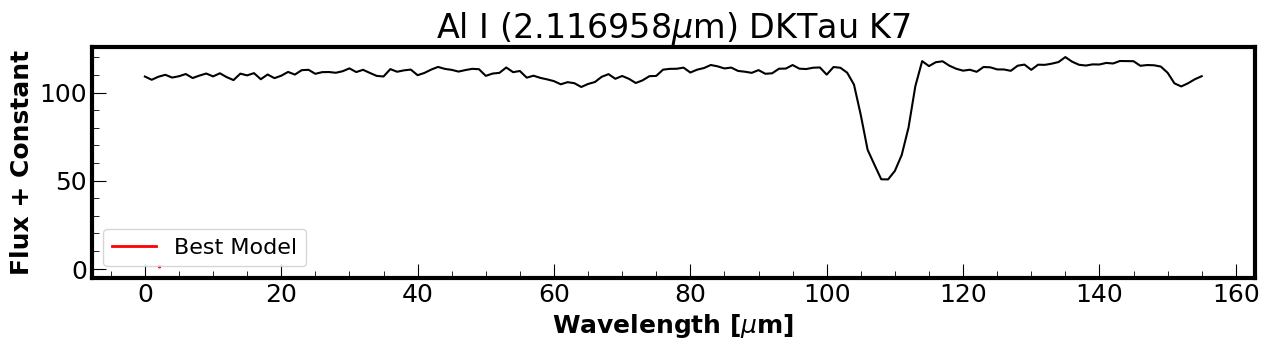

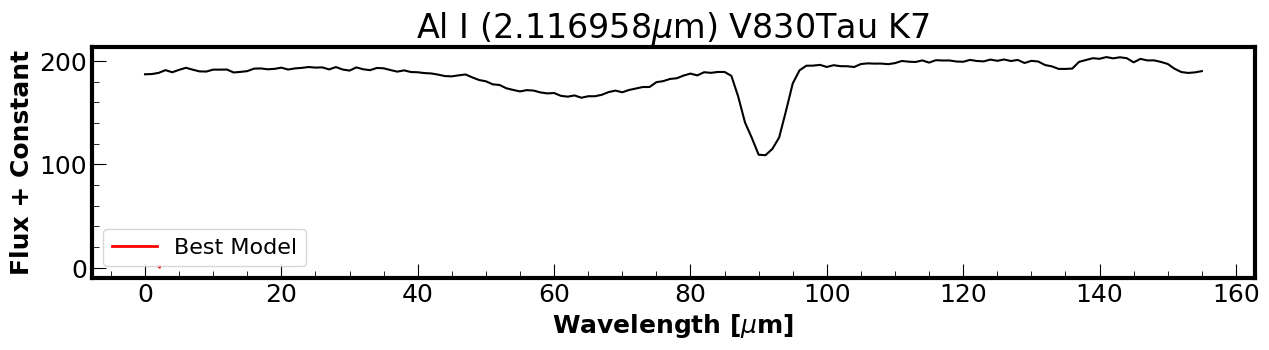

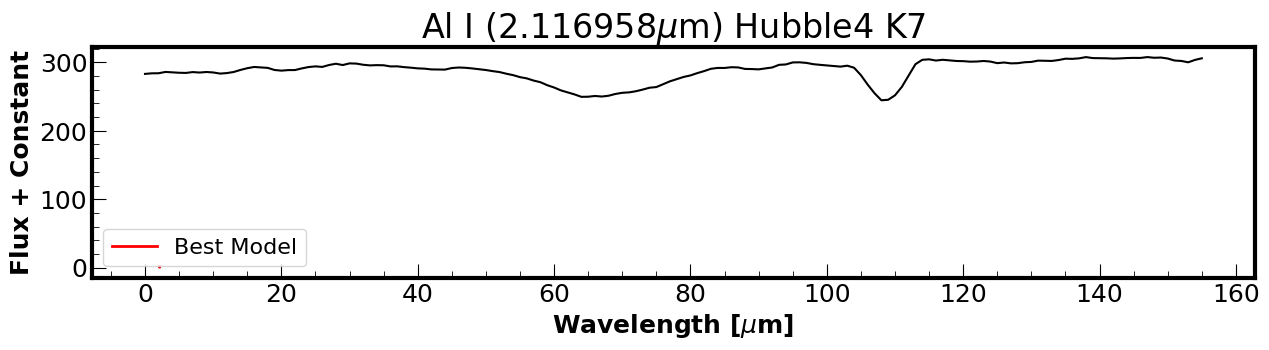

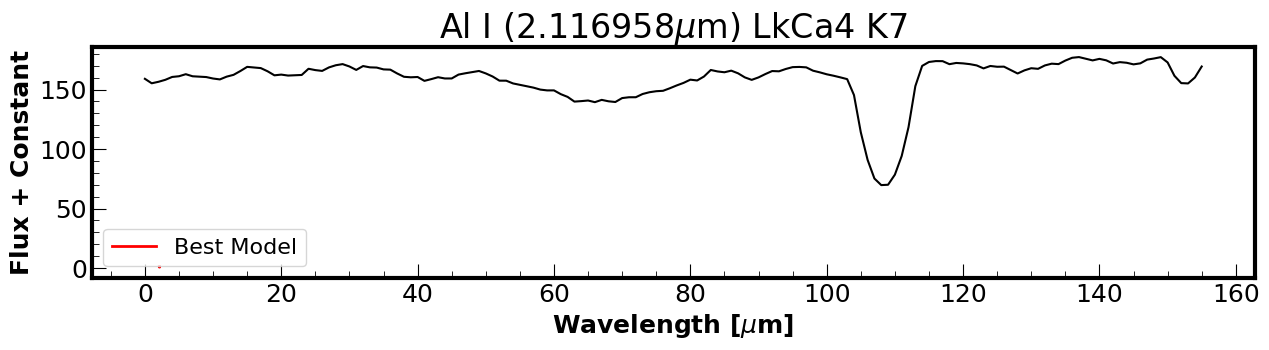

In [20]:
amplitude1_stack = []
center1_stack = []
sigma_stack = []

pcov_stack = []

best_model_stack = []

flux_constant = np.linspace(0,-1,len(standard_table_k))

# Define initial parameters for Gaussian fitting
init_params = (0.1, line_center, spec_res)


# wavelen_stack[region_indices[0][0]:region_indices[2][1],i],raw_flux_stack[region_indices[0][0]:region_indices[2][1],i]

for i in range(len(standard_table_k)):    
    # Perform Gaussian fitting for the current source
    popt, pcov, best_model = ig.gauss_fit(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        init_params,
                                        50000)

    amplitude1_stack.append(popt[0])
    center1_stack.append(popt[1])
    sigma_stack.append(popt[2])

    pcov_stack.append(pcov)
    best_model_stack.append(best_model)

# for i in range(len(standard_list)):
    # fwhm = 2*np.sqrt(2*np.log(2))*sigma1_stack[i]
    # area = np.abs(amplitude_stack[i]*sigma_stack[i]*np.sqrt(2*np.pi))
    # ew = np.trapz(1-best_model_stack[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    
al1_2_1169_fit = []

for i in range(len(standard_table_k)):
    al1_2_1169_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude1_stack[i],center1_stack[i],sigma_stack[i]))
    
    area_int = trapz(1-best_model_stack[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    area_v2 = np.abs(amplitude1_stack[i])*sigma_stack[i]*np.sqrt(2*np.pi)

    # print(f'{area_int} {area_v2}')

ew1_stack = [] # empty list to load in equivalent widths

# Integate 1-best_model to get the areas (equivalent widths) of each component Gaussian
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))

    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], c='black')
    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],best_model_stack[i],c='red',lw=2,label='Best Model')
    

    # plt.fill_between(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],best_model_stack[i],0,color='red',alpha=0.2)
    # Fe I
    # plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],fe1_2_0846_fit[i])#, label = 'Fe I 2.2263 Fit')
    # plt.ylim(0)
    plt.ylabel('Flux + Constant')
    plt.xlabel(r'Wavelength [$\mu$m]')

    plt.title(f"{line_name} ({line_center}$\mu$m) {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.legend(loc='best')
    plt.show()

## Ti I 2.2896

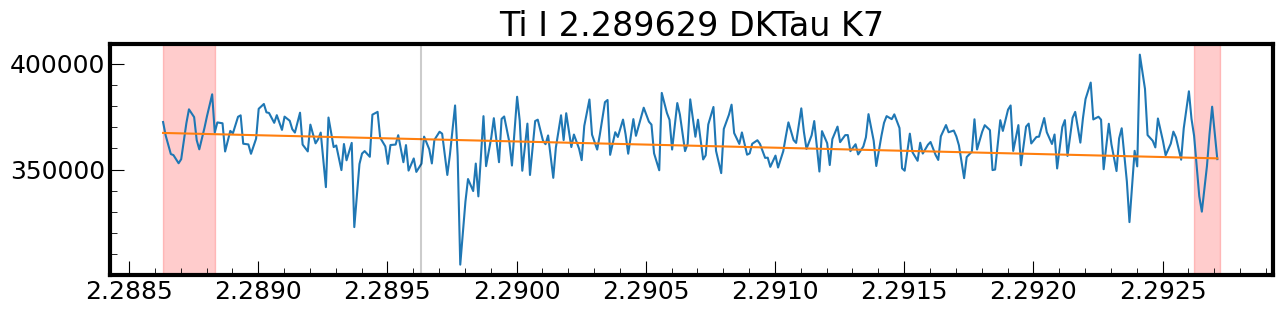

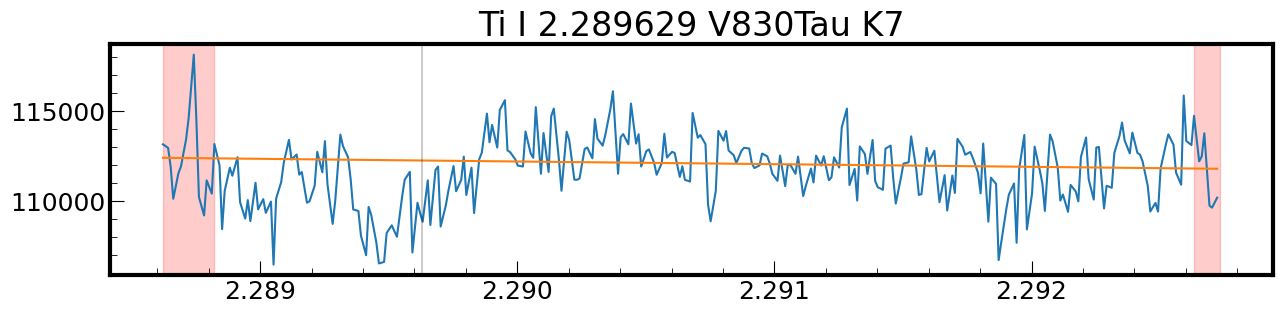

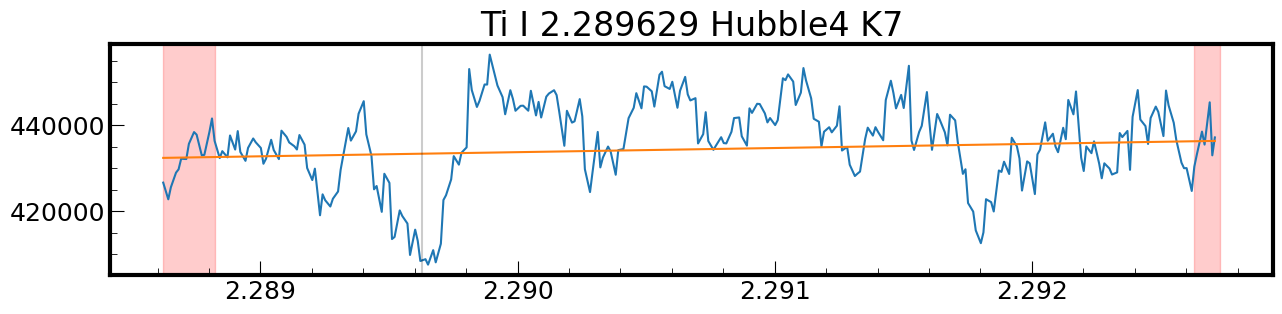

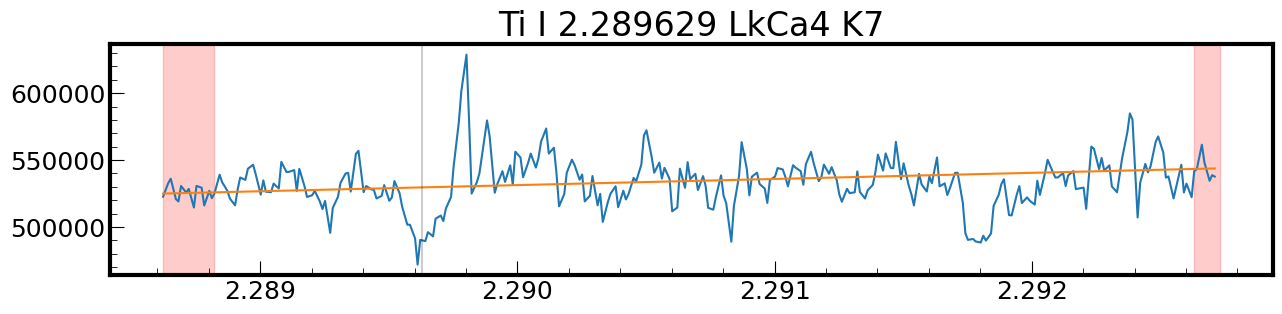

In [21]:
# Define the region for fitting
line_name = lines_table[ti1_mask][0]['Spectrum'] # Species
line_center = lines_table[ti1_mask][69]['Observed'] # Wavelength

# from igrins_mod import local_continuum_fit
continuum_stack = []
norm_flux_stack = []
reg_idx_stack = []

# regions [left point,width]
regions = [(-100,20), (300,10)]

# number of regions I use and subtract 1 since index starts at 0
n = len(regions)-1
poly_deg = 1
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))
    continuum, region_indices = ig.local_continuum_fit(wavelen_stack[:,i],
                                                    raw_flux_stack[:,i],
                                                    poly_order = poly_deg,
                                                    line_center = line_center,
                                                    spec_res = spec_res,
                                                    regions = regions)
    # append indices to list of indices
    reg_idx_stack.append(region_indices)
    
    # append to list of the local continuum arrays
    continuum_stack.append(continuum)

    # normalize flux by dividing the flux by the continuum and create a list
    norm_flux = raw_flux_stack[region_indices[0][0]:region_indices[n][1],i]/continuum_stack[i]
    norm_flux_stack.append(norm_flux)

    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], raw_flux_stack[region_indices[0][0]:region_indices[n][1],i])
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], continuum_stack[i])
    plt.axvline(line_center,alpha=0.2,color='black')

    for j in range(len(regions)):
        plt.axvspan(wavelen_stack[region_indices[n-j][0],i],wavelen_stack[region_indices[n-j][1],i],color='red',alpha=.2)

    plt.title(f"{line_name} {line_center} {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.show()

# Temperature Sensitive Lines

Sc I (2.2058 $\mu m$ and 2.2071 $\mu m$): index 1 and 2

Si I (2.2068 $\mu m$)

Mg/Al (~2.11 $\mu m$)

Fe I (2.2205–2.2346 $\mu m$) Over Ti region: index 10 and 11

Ca I (2.2614, 2.2631, 2.2657 $\mu m$): Only three lines

## Na Interval ~2.21
Na I Doublet (2.2062, 2.2089) & Sc I (2.2058)

In [22]:
lines_table[na1_mask][:]['Observed']

<MaskedColumn name='Observed' dtype='float64' length=4>
2.206242
2.208969
2.335475
2.338552

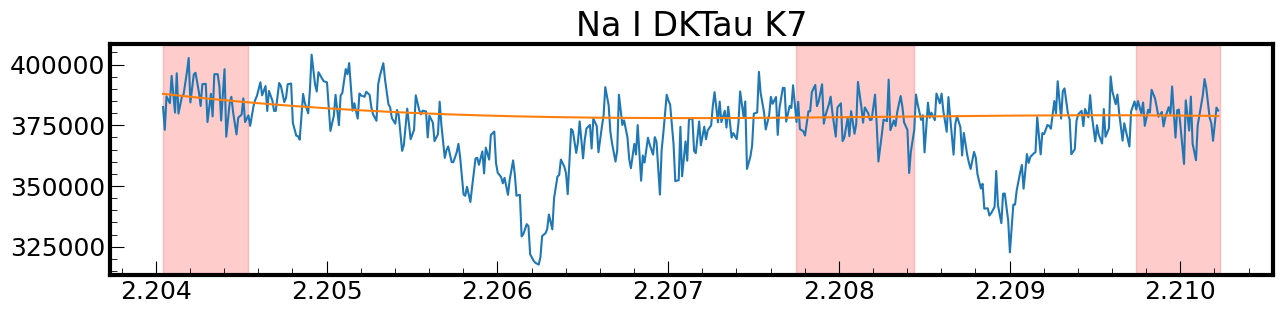

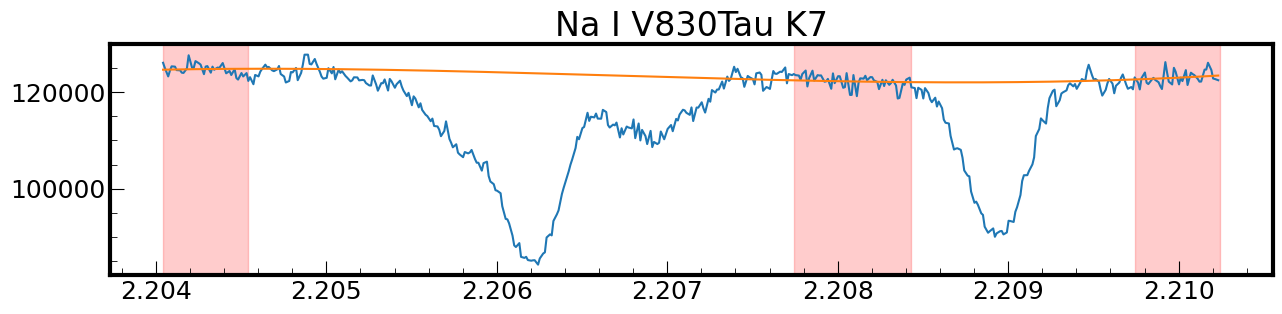

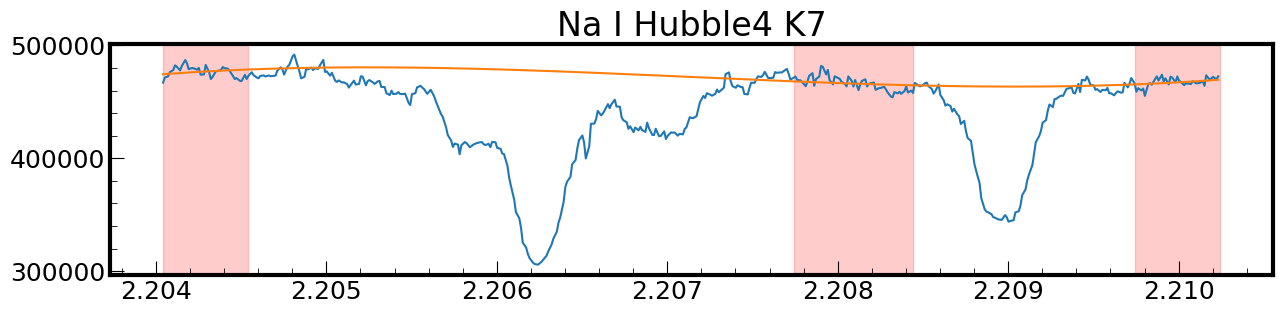

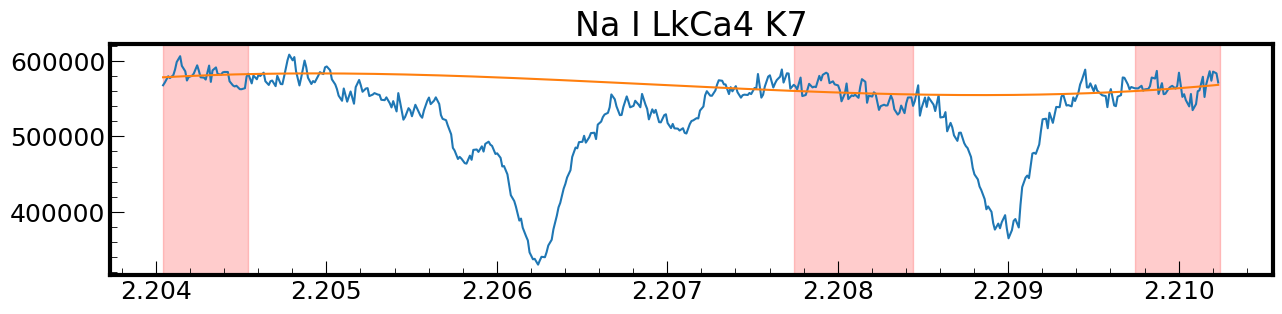

In [23]:
# Define the region for fitting
line_name = lines_table[na1_mask][0]['Spectrum'] # Species
line_center = lines_table[na1_mask][0]['Observed'] # Wavelength

# from igrins_mod import local_continuum_fit
continuum_stack = []
norm_flux_stack = []
reg_idx_stack = []

# regions [left point,width]
regions = [(-220,50),(150,70),(350,50)]

# number of regions I use and subtract 1 since index starts at 0
n = len(regions)-1
poly_deg = 3
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))
    continuum, region_indices = ig.local_continuum_fit(wavelen_stack[:,i],
                                                    raw_flux_stack[:,i],
                                                    poly_order = poly_deg,
                                                    line_center = line_center,
                                                    spec_res = spec_res,
                                                    regions = regions)
    # append indices to list of indices
    reg_idx_stack.append(region_indices)
    
    # append to list of the local continuum arrays
    continuum_stack.append(continuum)

    # normalize flux by dividing the flux by the continuum and create a list
    norm_flux = raw_flux_stack[region_indices[0][0]:region_indices[n][1],i]/continuum_stack[i]
    norm_flux_stack.append(norm_flux)


    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], raw_flux_stack[region_indices[0][0]:region_indices[n][1],i])
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], continuum_stack[i])

    for j in range(len(regions)):
        plt.axvspan(wavelen_stack[region_indices[n-j][0],i],wavelen_stack[region_indices[n-j][1],i],color='red',alpha=.2)

    plt.title(f"{line_name} {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.show()

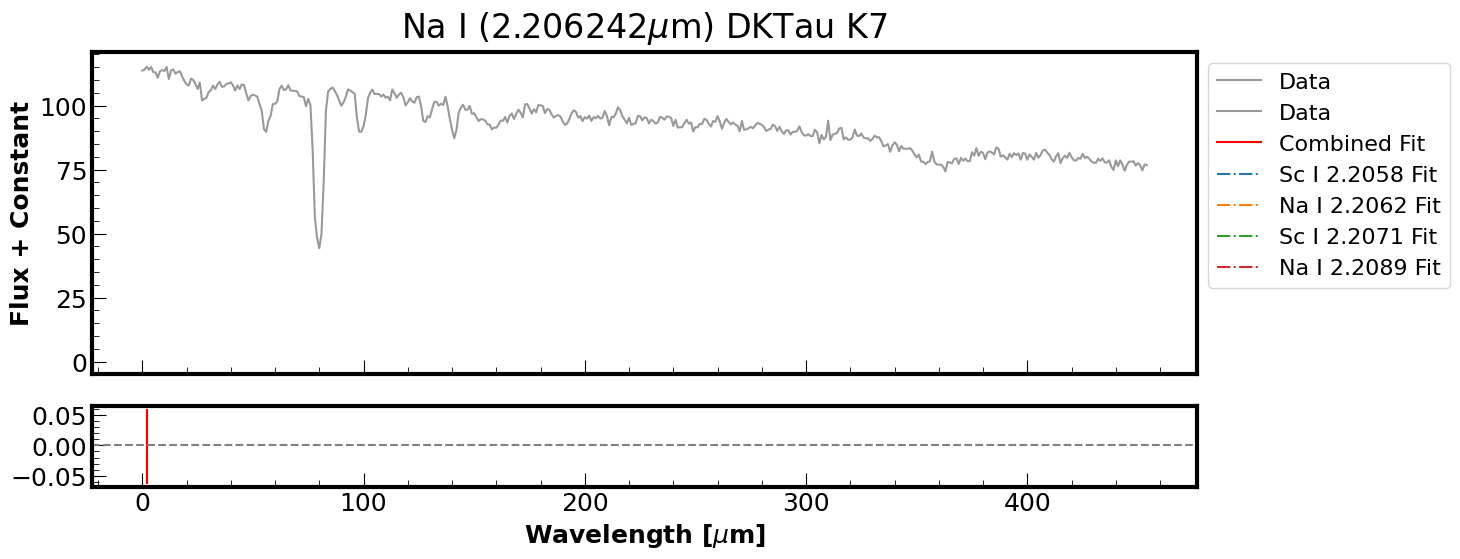

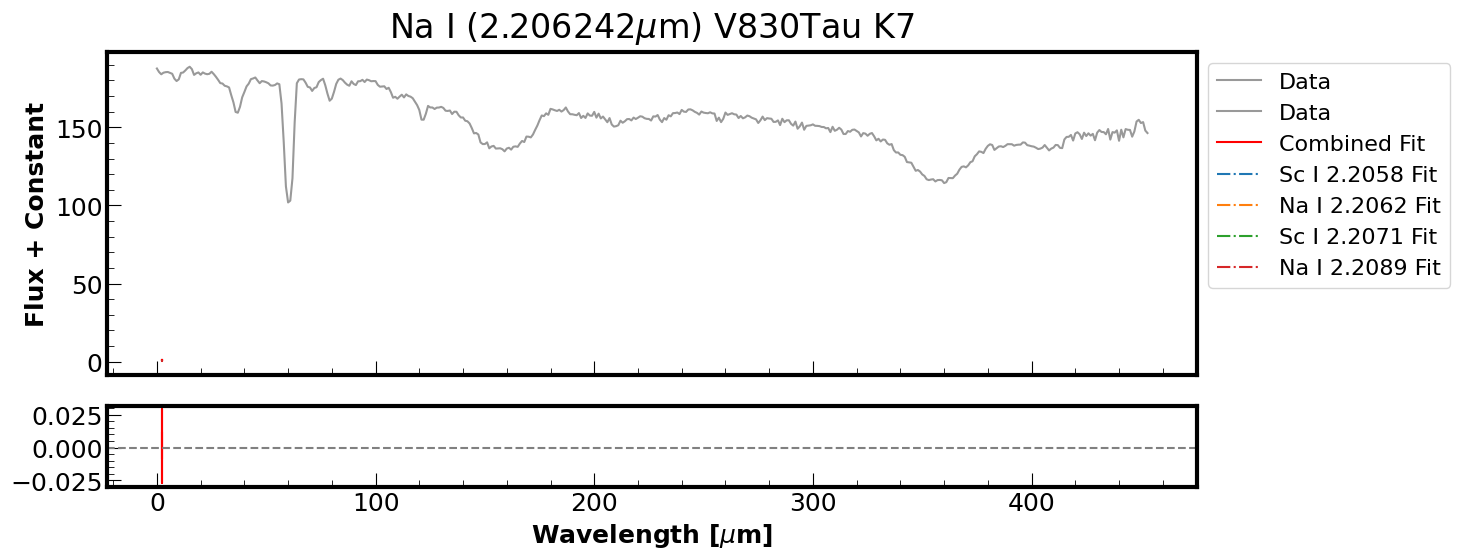

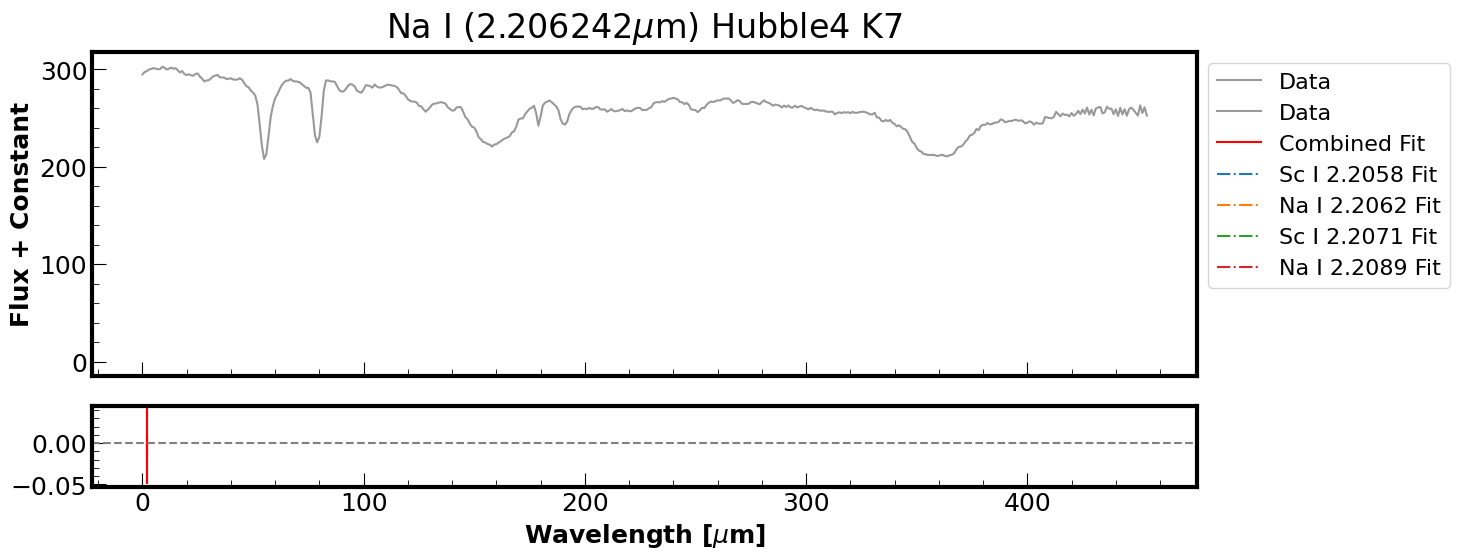

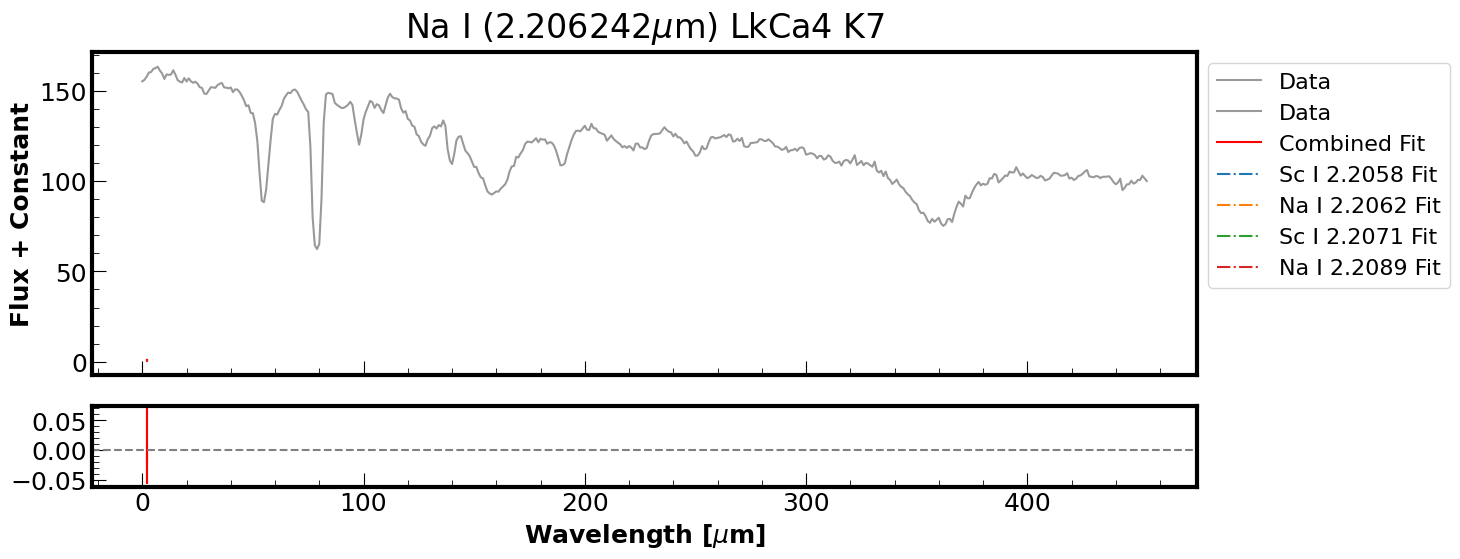

In [24]:
amplitude1_stack = []
center1_stack = []
sigma1_stack = []

amplitude2_stack = []
center2_stack = []
sigma2_stack = []

amplitude3_stack = []
center3_stack = []
sigma3_stack = []

amplitude4_stack = []
center4_stack = []
sigma4_stack = []

pcov_stack = []
best_model_stack = []
best_model_2_stack = []

for i in range(len(standard_table_k)):
    # Define initial parameters for Gaussian fitting
    init_params = (-0.5, lines_table[sc1_mask]['Observed'][19],spec_res,
                   -0.5, line_center, spec_res,
                   -0.5, lines_table[sc1_mask]['Observed'][20], spec_res,
                   -0.5, lines_table[na1_mask]['Observed'][1], spec_res,)

    # Perform Gaussian fitting for the current source
    # add error keyword then propogate for equiv width
    # compare equiv widths between objects of the same spectral types
    popt, pcov, best_model = ig.four_gauss_fit(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        init_params,
                                        1000)
    # Append the best_model and parameters stacks
    amplitude1_stack.append(popt[0])
    center1_stack.append(popt[1])
    sigma1_stack.append(popt[2])

    amplitude2_stack.append(popt[3])
    center2_stack.append(popt[4])
    sigma2_stack.append(popt[5])
    
    amplitude3_stack.append(popt[6])
    center3_stack.append(popt[7])
    sigma3_stack.append(popt[8])

    amplitude4_stack.append(popt[9])
    center4_stack.append(popt[10])
    sigma4_stack.append(popt[11])

    pcov_stack.append(pcov)
    best_model_stack.append(best_model)

init_params = (-0.1, lines_table[na1_mask]['Observed'][1], spec_res)

sc1_2_2058_fit = []
na1_2_2062_fit = []
si1_2_2068_fit = [] #???
sc1_2_2071_fit = []
na1_2_2089_fit = []

for i in range(len(standard_table_k)):
    sc1_2_2058_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amplitude1_stack[i], center1_stack[i], sigma1_stack[i]))
    na1_2_2062_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amplitude2_stack[i], center2_stack[i], sigma2_stack[i]))
    sc1_2_2071_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amplitude3_stack[i], center3_stack[i], sigma3_stack[i]))
    na1_2_2089_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], amplitude4_stack[i], center4_stack[i], sigma4_stack[i]))

    # Create subplots with adjusted size ratios
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

    # Plot the original data and fits
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], c='black', alpha=0.4, label='Data')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], best_model_stack[i], c='red', label='Combined Fit')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], sc1_2_2058_fit[i], ls='-.', label='Sc I 2.2058 Fit')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], na1_2_2062_fit[i], ls='-.', label='Na I 2.2062 Fit')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], sc1_2_2071_fit[i], ls='-.', label='Sc I 2.2071 Fit')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], na1_2_2089_fit[i], ls='-.', label='Na I 2.2089 Fit')

    ax1.set_ylabel('Flux + Constant')
    ax1.legend(bbox_to_anchor=(1, 1))

    # Calculate residuals
    residuals = norm_flux_stack[i] - best_model_stack[i]

    # Plot residuals
    ax2.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], residuals, c='red', label='Residuals')
    ax2.axhline(y=0, color='grey', linestyle='--')
    ax2.set_xlabel(r'Wavelength [$\mu$m]')
    # ax2.set_ylabel('Residuals')
    # ax2.legend(bbox_to_anchor=(1, 1))

    # Title
    ax1.set_title(rf"{line_name} ({line_center}$\mu$m) {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}", y=1.02)

    plt.tight_layout()
    plt.show()

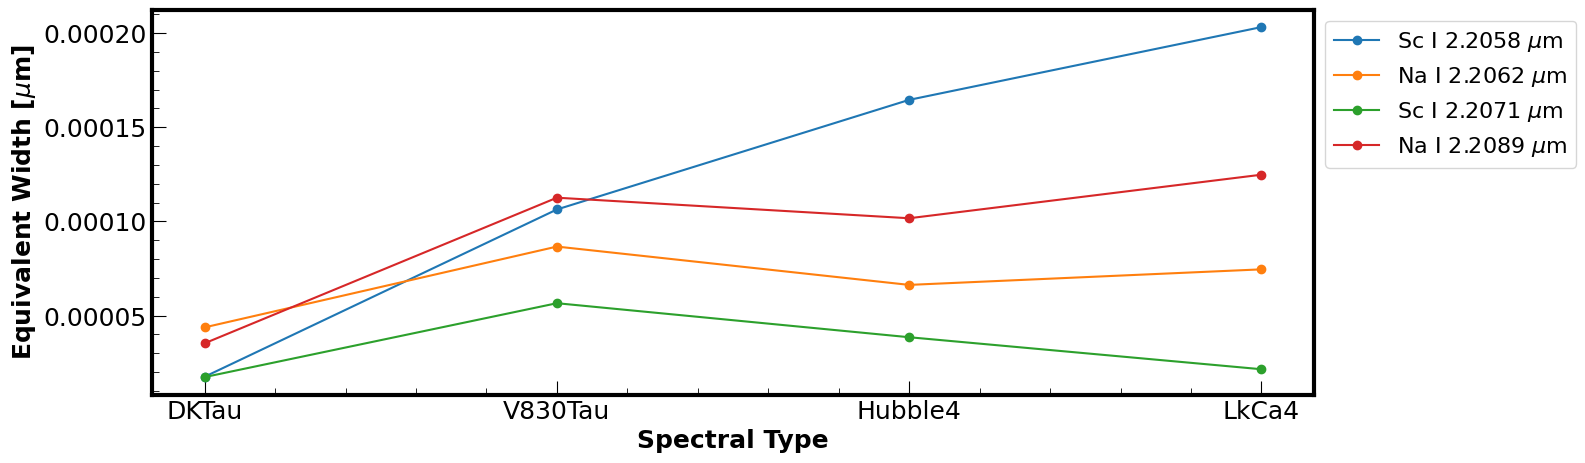

In [25]:
ew1_stack = [] # empty list to load in equivalent widths
ew2_stack = []
ew3_stack = []
ew4_stack = []
ew5_stack = []

# Integate 1-best_model to get the areas (equivalent widths) of each component Gaussian
for i in range(len(standard_table_k)):
    ew1 = np.trapz(1-na1_2_2062_fit[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i]) # integrate the gaussian
    ew1_stack.append(ew1)

    ew2 = np.trapz(1-sc1_2_2058_fit[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    ew2_stack.append(ew2)

    # ew3 = np.trapz(1-si1_2_2068_fit[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    # ew3_stack.append(ew3)

    ew4 = np.trapz(1-sc1_2_2071_fit[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    ew4_stack.append(ew4)

    ew5 = np.trapz(1-na1_2_2089_fit[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    ew5_stack.append(ew5)

standard_table_k.loc[:,'ew_na1_2_2062'] = ew1_stack
standard_table_k.loc[:,'ew_sc1_2_2058'] = ew2_stack
# standard_table_k.loc[:,'ew_si1_2_2068'] = ew3_stack
standard_table_k.loc[:,'ew_sc1_2_2071'] = ew4_stack
standard_table_k.loc[:,'ew_na1_2_2089'] = ew5_stack

fig = plt.figure(figsize=(15,5))

plt.plot(standard_table_k['Name'], standard_table_k['ew_sc1_2_2058'],ls='-',marker='o', label=f"Sc I 2.2058 $\mu$m")
plt.plot(standard_table_k['Name'], standard_table_k['ew_na1_2_2062'],ls='-',marker='o', label=f"Na I 2.2062 $\mu$m")
# plt.plot(standard_table_k['Spectral_Type'], standard_table_k['ew_si1_2_2068'],ls='-',marker='o', label=f"Si I 2.2068 $\mu$m")
plt.plot(standard_table_k['Name'], standard_table_k['ew_sc1_2_2071'],ls='-',marker='o', label=f"Sc I 2.2071 $\mu$m")
plt.plot(standard_table_k['Name'], standard_table_k['ew_na1_2_2089'],ls='-',marker='o', label=f"Na I 2.2089 $\mu$m")

# plt.scatter(standard_table_k['Spectral_Type'], area_stack)
# plt.ylim(np.nanmedian(ew_stack)+-0.001,np.nanmedian(ew_stack)+0.001)

# plt.ylim(0,1e-3)

plt.xlabel('Spectral Type')
plt.ylabel(r'Equivalent Width [$\mu$m]')
# plt.title(f"{line_name} {line_center} $\mu$m")
# plt.yscale('log')

plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Mg/Al ~ 2.11

Mg 2.1065 = lines_table[mg1_mask][0]

Al 2.1098 = lines_table[al1_mask][0]

c:\Users\Savio\Documents\IGRINS-Spectra\igrins_mod.py:328: RankWarning: Polyfit may be poorly conditioned
  continuum_fit = np.polyfit(x=contwave_array, y=contflux_array, deg=poly_order)


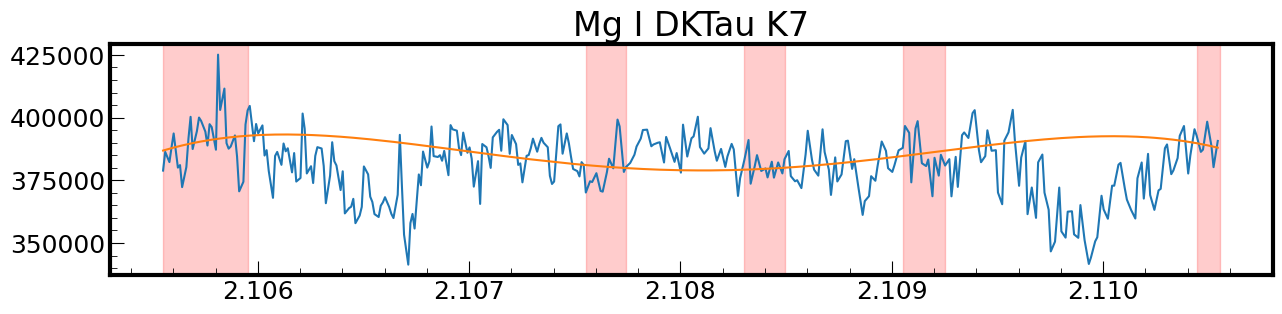

c:\Users\Savio\Documents\IGRINS-Spectra\igrins_mod.py:328: RankWarning: Polyfit may be poorly conditioned
  continuum_fit = np.polyfit(x=contwave_array, y=contflux_array, deg=poly_order)


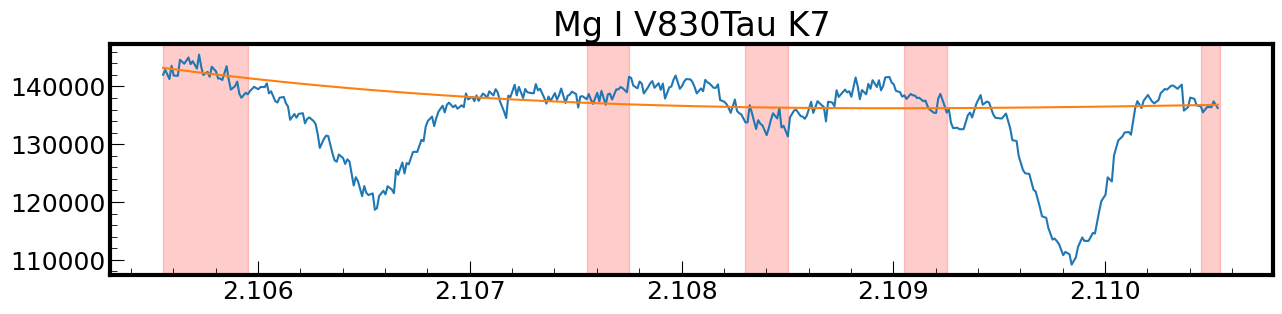

c:\Users\Savio\Documents\IGRINS-Spectra\igrins_mod.py:328: RankWarning: Polyfit may be poorly conditioned
  continuum_fit = np.polyfit(x=contwave_array, y=contflux_array, deg=poly_order)


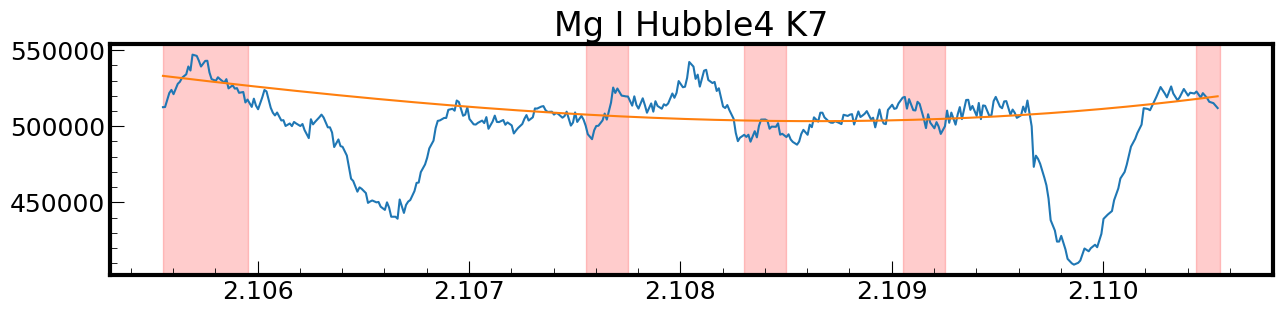

c:\Users\Savio\Documents\IGRINS-Spectra\igrins_mod.py:328: RankWarning: Polyfit may be poorly conditioned
  continuum_fit = np.polyfit(x=contwave_array, y=contflux_array, deg=poly_order)


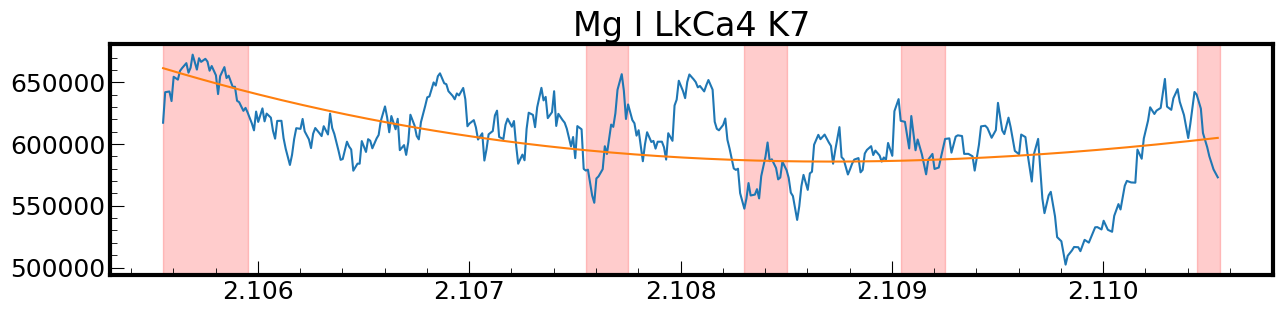

In [26]:
# Define the region for fitting
line_name = lines_table[mg1_mask][0]['Spectrum'] # Species
line_center = lines_table[mg1_mask][0]['Observed'] # Wavelength

# from igrins_mod import local_continuum_fit
continuum_stack = []
norm_flux_stack = []
reg_idx_stack = []

# regions [left point,width]
regions = [(-100,40), (100,20), (175,20), (250,20), (390,10)]

# number of regions I use and subtract 1 since index starts at 0
n = len(regions)-1
poly_deg = 5
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))
    continuum, region_indices = ig.local_continuum_fit(wavelen_stack[:,i],
                                                    raw_flux_stack[:,i],
                                                    poly_order = poly_deg,
                                                    line_center = line_center,
                                                    spec_res = spec_res,
                                                    regions = regions)
    # append indices to list of indices
    reg_idx_stack.append(region_indices)
    
    # append to list of the local continuum arrays
    continuum_stack.append(continuum)

    # normalize flux by dividing the flux by the continuum and create a list
    norm_flux = raw_flux_stack[region_indices[0][0]:region_indices[n][1],i]/continuum_stack[i]
    norm_flux_stack.append(norm_flux)


    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], raw_flux_stack[region_indices[0][0]:region_indices[n][1],i])
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], continuum_stack[i])

    for j in range(len(regions)):
        plt.axvspan(wavelen_stack[region_indices[n-j][0],i],wavelen_stack[region_indices[n-j][1],i],color='red',alpha=.2)

    plt.title(f"{line_name} {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.show()
    plt.show()

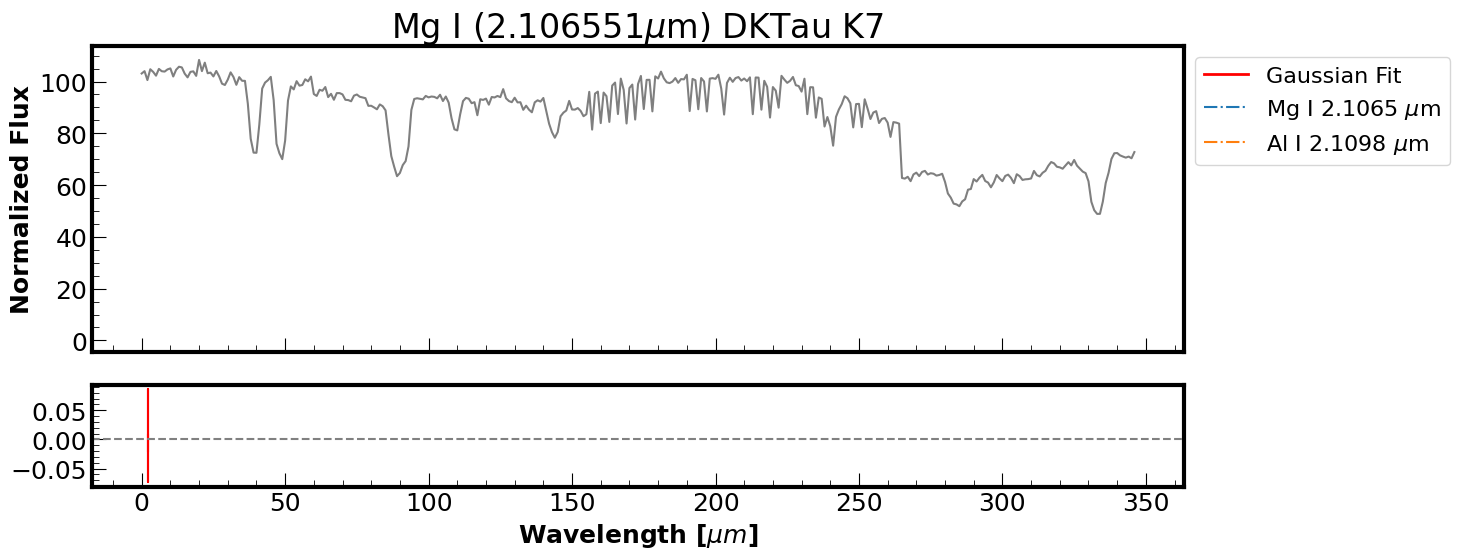

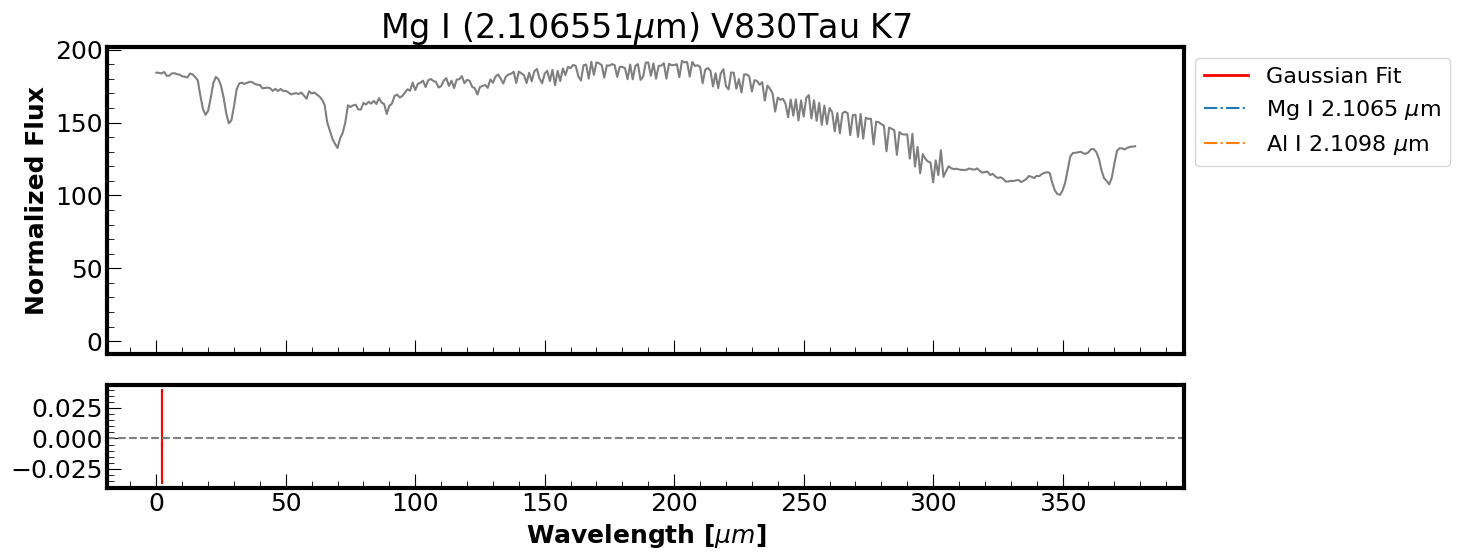

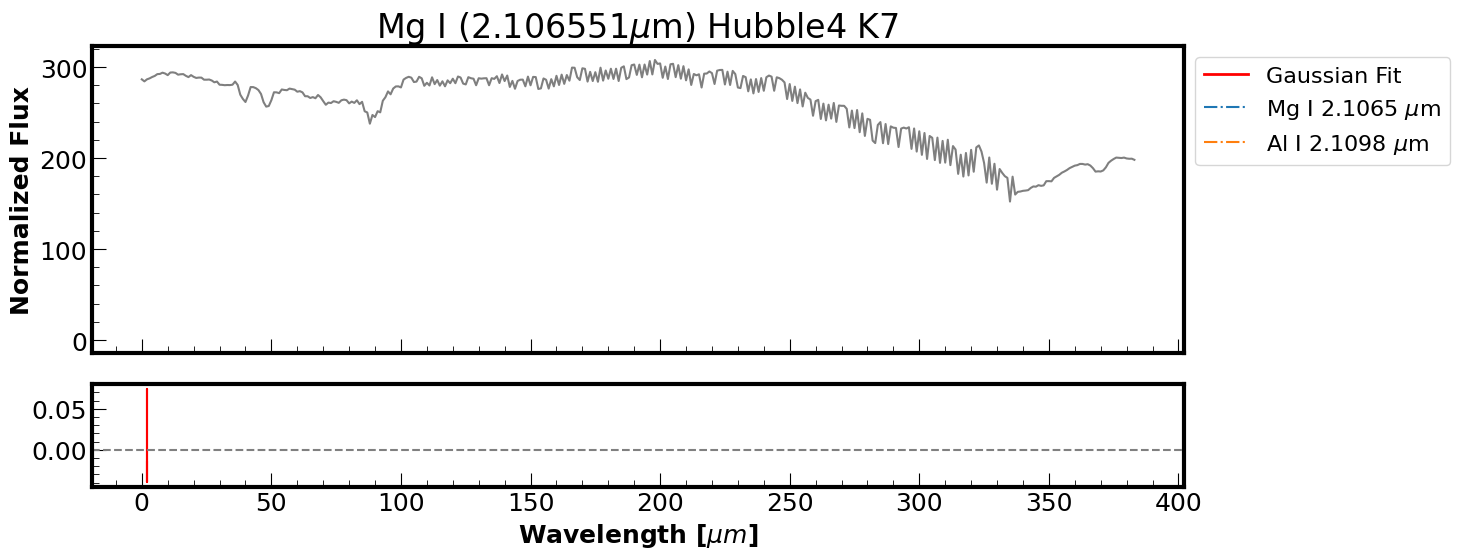

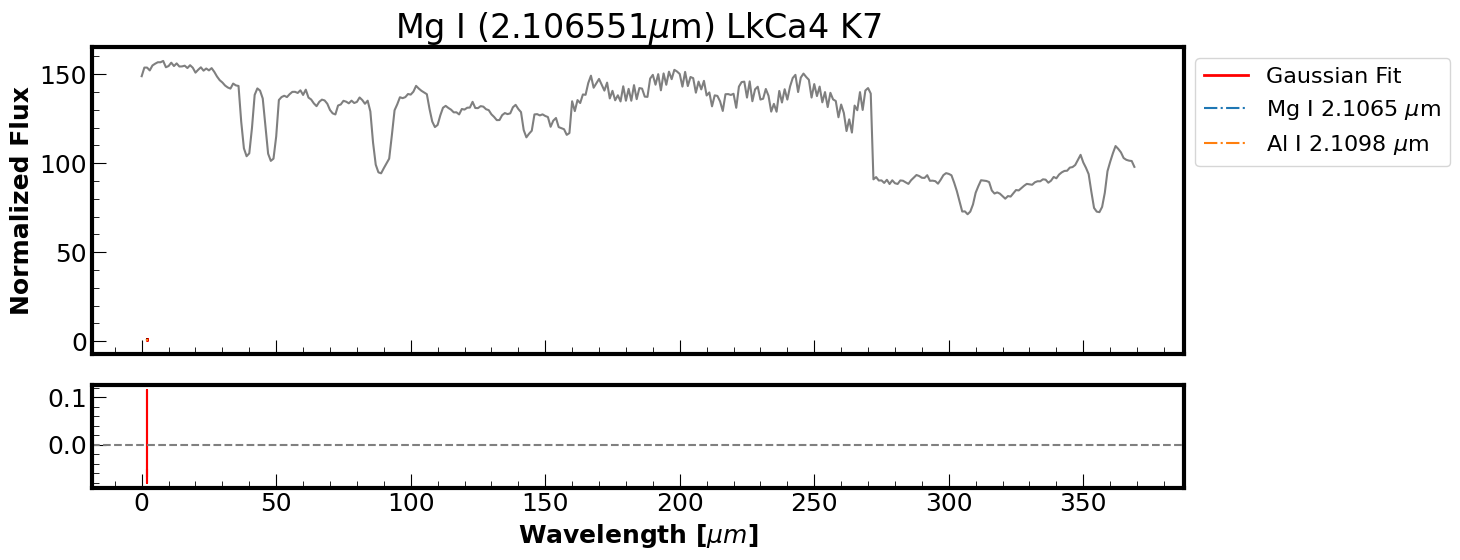

In [27]:
# min_wave = line_center - (100 * spec_res)
# max_wave = line_center + (100 * spec_res)

# Optimal parameters that will be appended from scipy curve fit below
amplitude1_stack = []
center1_stack = []
sigma1_stack = []

amplitude2_stack = []
center2_stack = []
sigma2_stack = []

# amplitude3_stack = []
# center3_stack = []

# amplitude4_stack = []
# center4_stack = []

pcov_stack = [] # Covariant matrices
best_model_stack = [] # Best model fits

flux_constant = np.linspace(0,-1,len(standard_table_k))

# Define initial parameters for Gaussian fitting
init_params = (-0.5, line_center, spec_res,
               -0.5, lines_table[al1_mask]['Observed'][0], spec_res)


for i in range(len(standard_table_k)):    
    # Perform Gaussian fitting for the current source
    popt, pcov, best_model = ig.two_gauss_fit(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        init_params,
                                        50000)
    # Append the Gaussian parameters, covariant matrices, and model fits as we loop through
    amplitude1_stack.append(popt[0])
    center1_stack.append(popt[1])
    sigma1_stack.append(popt[2])

    amplitude2_stack.append(popt[3])
    center2_stack.append(popt[4])
    sigma2_stack.append(popt[5])

    # amplitude3_stack.append(popt[5])
    # center3_stack.append(popt[6])

    # amplitude4_stack.append(popt[7])
    # center4_stack.append(popt[8])

    pcov_stack.append(pcov)
    best_model_stack.append(best_model)

# Gaussian model fits for each source
mg1_2_1065_fits = []
al1_2_1098_fits = []

# Getting the individual Gaussians into their own lists
for i in range(len(standard_table_k)):
    mg1_2_1065_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude1_stack[i],center1_stack[i],sigma1_stack[i]))
    al1_2_1098_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude2_stack[i],center2_stack[i],sigma2_stack[i]))

ew1_stack = []
ew2_stack = []
# ew3_stack = []
# ew4_stack = []
for i in range(len(standard_table_k)):
    ew1 = np.trapz(1-mg1_2_1065_fits[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    ew2 = np.trapz(1-al1_2_1098_fits[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])

    ew1_stack.append(ew1)
    ew2_stack.append(ew2)


standard_table_k.loc[:,'ew_mg1_2_1065'] = ew1_stack
standard_table_k.loc[:,'ew_al1_2_1098'] = ew2_stack

# Plotting each component Gaussian and the best model fit

for i in range(len(standard_table_k)):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], best_model_stack[i],lw=2, c='red',label='Gaussian Fit')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], c='black', alpha=0.5)

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],mg1_2_1065_fits[i],ls='-.',label=r'Mg I 2.1065 $\mu$m')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],al1_2_1098_fits[i],ls='-.',label=r'Al I 2.1098 $\mu$m')
    
    ax1.set_ylabel('Normalized Flux')
    ax2.set_xlabel(r'Wavelength [$\mu$m]')
    ax1.legend(bbox_to_anchor=(1, 1))

    # Calculate residuals
    residuals = norm_flux_stack[i] - best_model_stack[i]

    # Plot residuals
    ax2.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], residuals, c='red', label='Residuals')
    ax2.axhline(y=0, color='grey', linestyle='--')
    ax2.set_xlabel(r'Wavelength [$\mu m$]')
    # ax2.set_ylabel('Residuals')
    # ax2.legend(bbox_to_anchor=(1, 1))

    # Title
    ax1.set_title(rf"{line_name} ({line_center}$\mu$m) {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.tight_layout()
    plt.show()

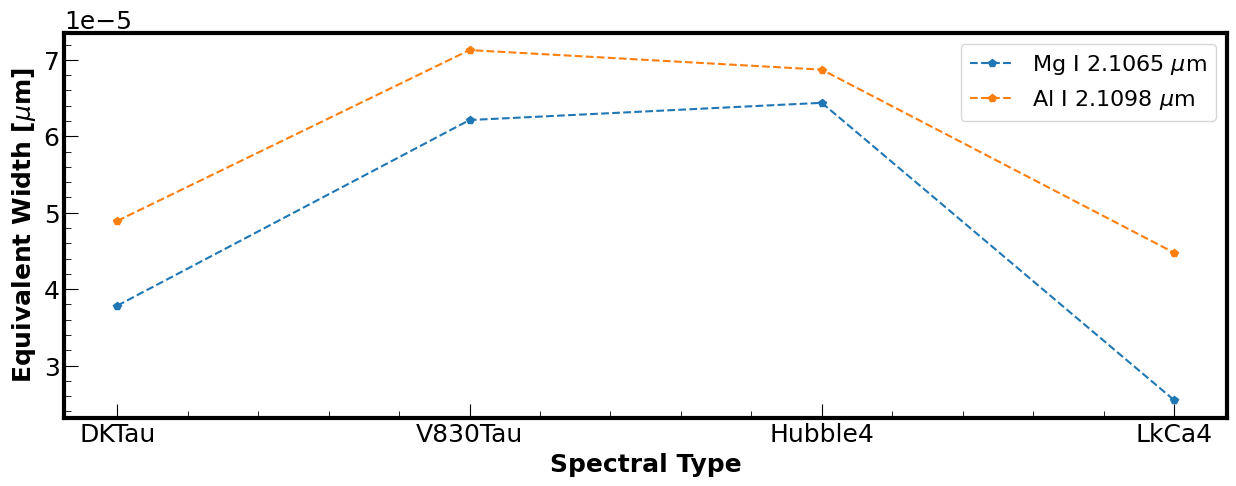

In [28]:
fig = plt.figure(figsize=(15,5))

plt.plot(standard_table_k['Name'], standard_table_k['ew_mg1_2_1065'],ls='--',marker='p', label=f"Mg I 2.1065 $\mu$m")
plt.plot(standard_table_k['Name'], standard_table_k['ew_al1_2_1098'],ls='--',marker='p', label=f"Al I 2.1098 $\mu$m")
# plt.plot(standard_table_k['Spectral_Type'], standard_table_k['ew_fe1_2_2838'],ls='--',marker='p', label=f"Fe I 2.2838$\mu$m")

# plt.scatter(standard_table_k['Spectral_Type'], area_stack)
# plt.ylim(np.nanmedian(ew_stack)+-0.001,np.nanmedian(ew_stack)+0.001)

# plt.ylim(-0.0001,0.0002)
# plt.yscale('log')

plt.xlabel('Spectral Type')
plt.ylabel(r'Equivalent Width [$\mu$m]')
# plt.title(f"{line_name} {line_center} $\mu$m")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Ti Region ~ 2.222

Fe I lines (~2.226)

In [29]:
# sqrt(2pi a^2 + 2pi b^2) uncertainty?

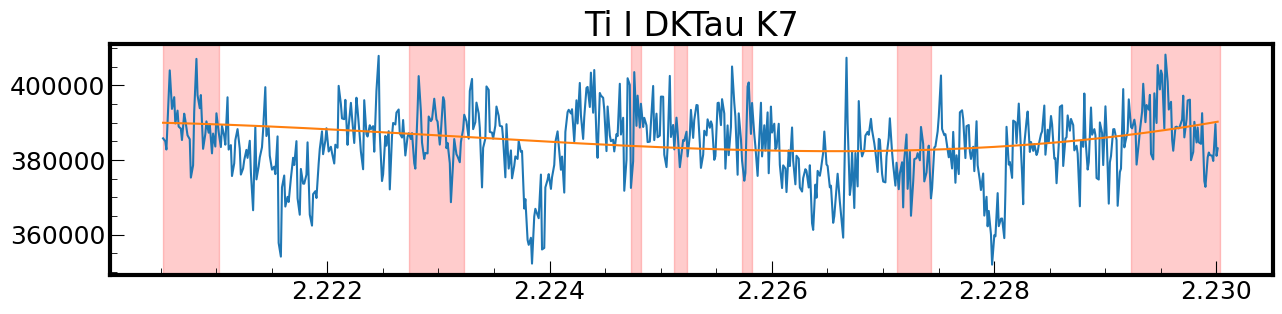

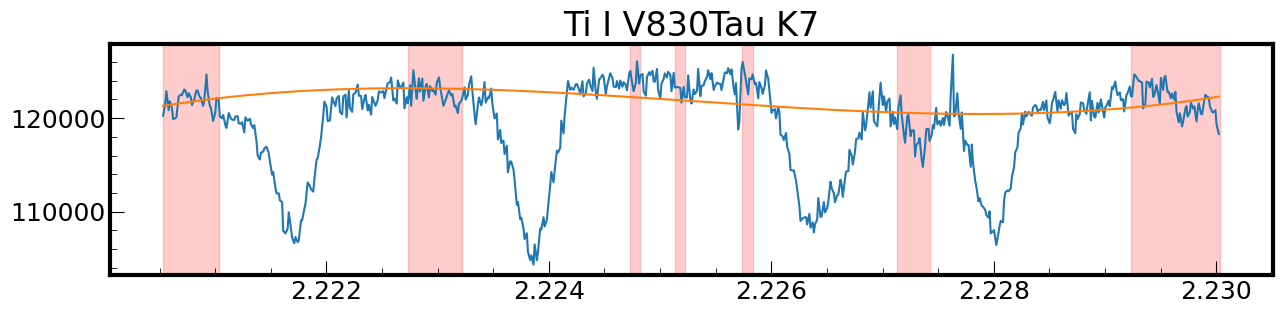

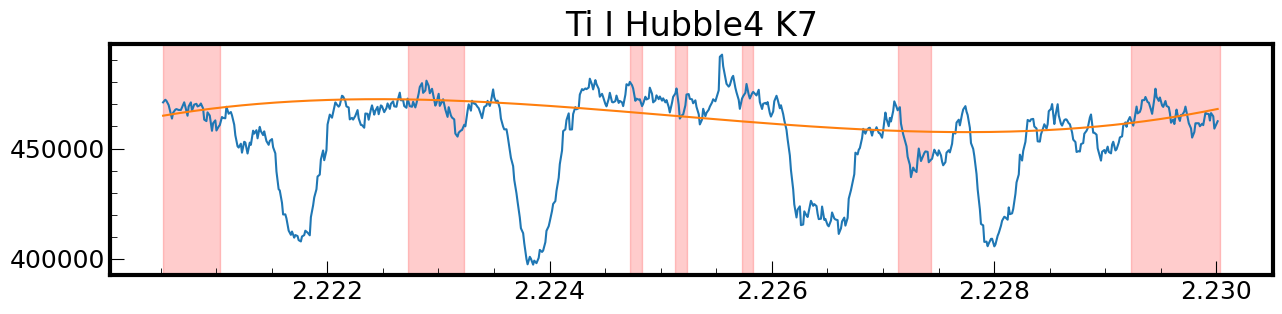

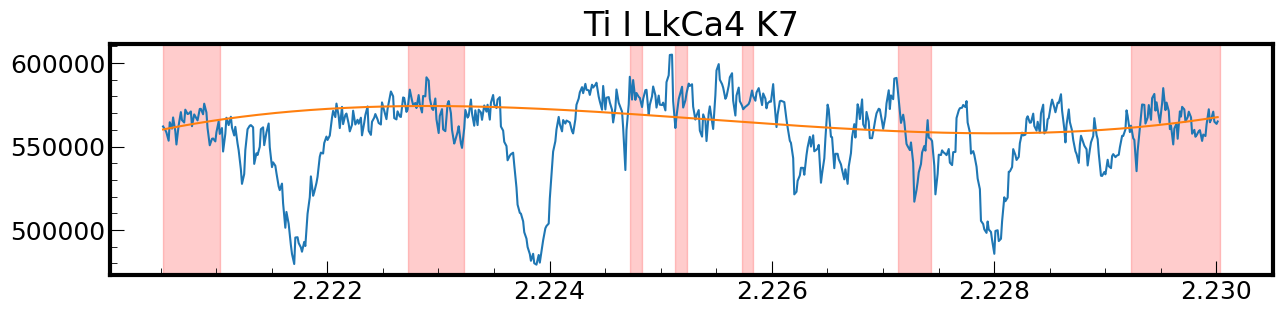

In [30]:
# Define the region for fitting
line_name = lines_table[ti1_mask][0]['Spectrum'] # Species
line_center = lines_table[ti1_mask][44]['Observed'] # Wavelength

# from igrins_mod import local_continuum_fit
continuum_stack = []
norm_flux_stack = []
reg_idx_stack = []

# regions [left point,width]
regions = [(-120,50),(100,50),(300,10),(340,10),(400,10),(540,30),(750,80)]

# number of regions I use and subtract 1 since index starts at 0
n = len(regions)-1
poly_deg = 3
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))
    continuum, region_indices = ig.local_continuum_fit(wavelen_stack[:,i],
                                                    raw_flux_stack[:,i],
                                                    poly_order = poly_deg,
                                                    line_center = line_center,
                                                    spec_res = spec_res,
                                                    regions = regions)
    # append indices to list of indices
    reg_idx_stack.append(region_indices)
    
    # append to list of the local continuum arrays
    continuum_stack.append(continuum)

    # normalize flux by dividing the flux by the continuum and create a list
    norm_flux = raw_flux_stack[region_indices[0][0]:region_indices[n][1],i]/continuum_stack[i]
    norm_flux_stack.append(norm_flux)

    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], raw_flux_stack[region_indices[0][0]:region_indices[n][1],i])
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], continuum_stack[i])

    for j in range(len(regions)):
            plt.axvspan(wavelen_stack[region_indices[n-j][0],i],wavelen_stack[region_indices[n-j][1],i],color='red',alpha=.2)
    
    plt.title(f"{line_name} {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.show()

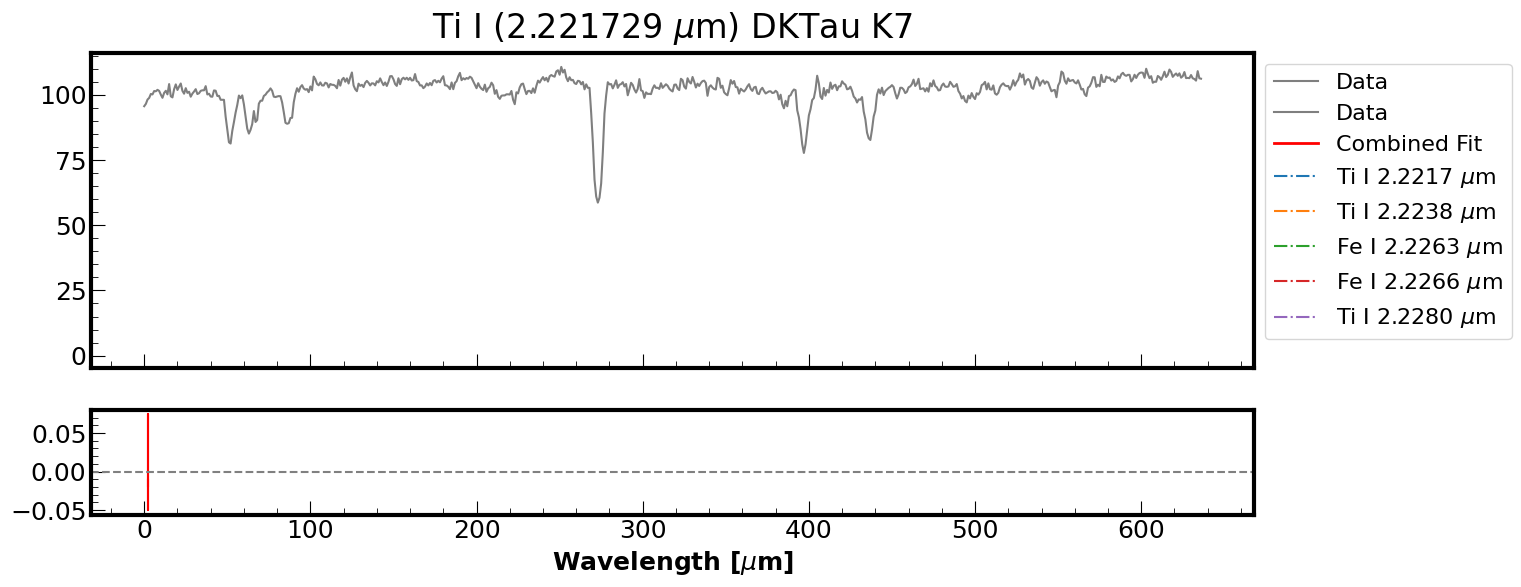

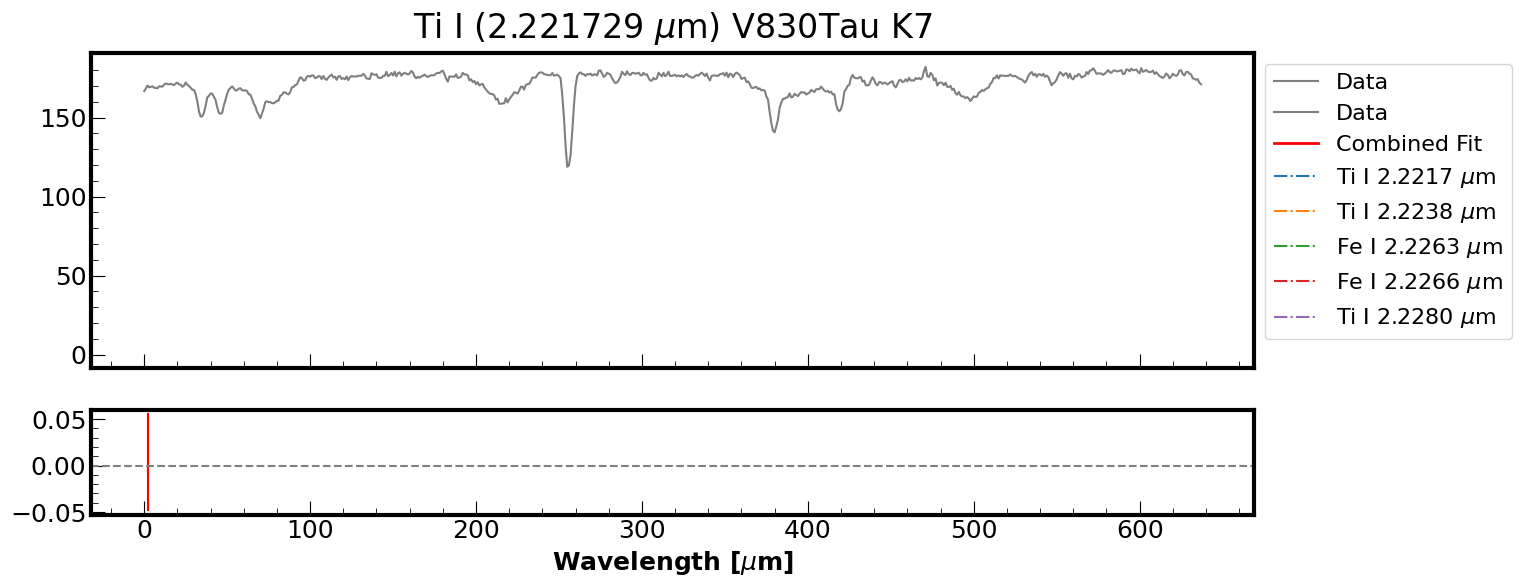

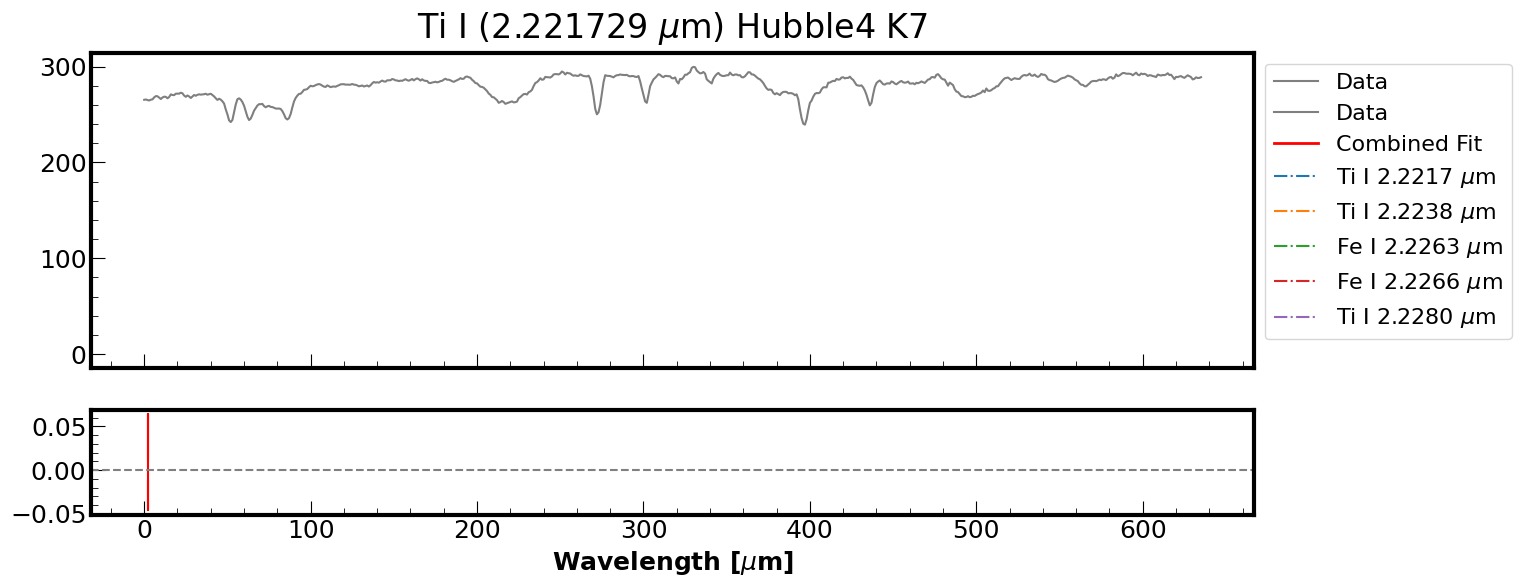

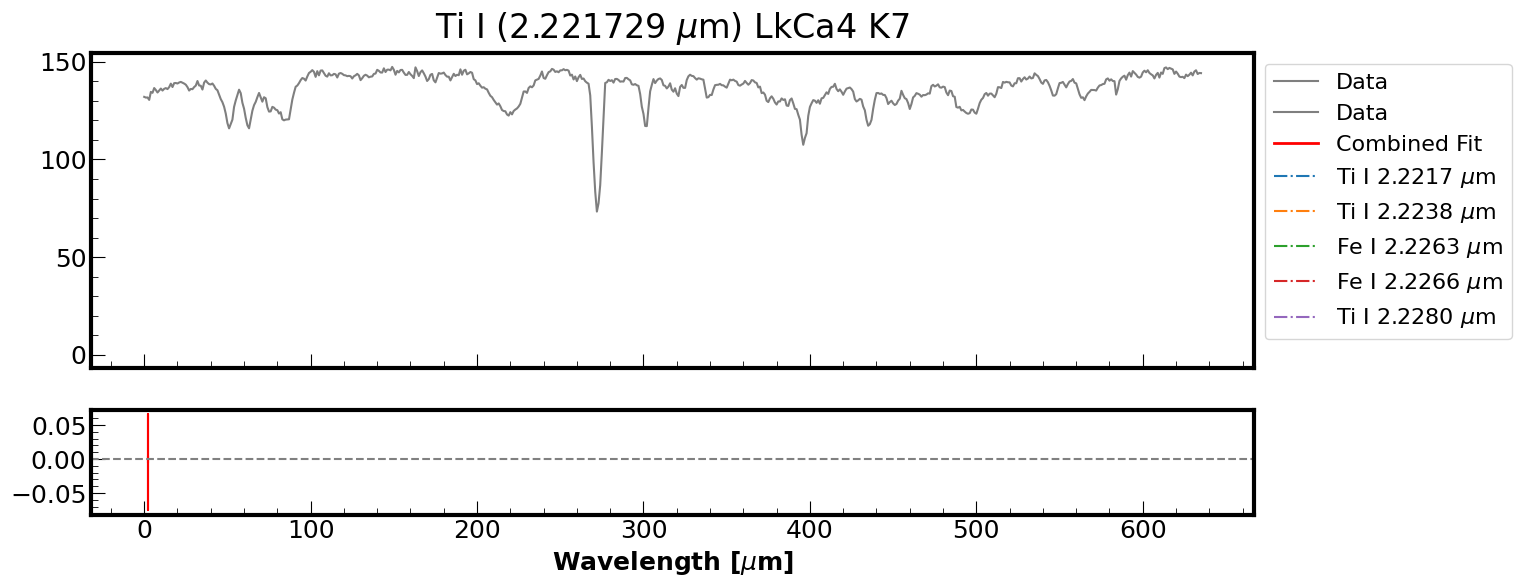

In [31]:
amplitude1_stack = []
center1_stack = []
sigma1_stack = []

amplitude2_stack = []
center2_stack = []
sigma2_stack = []

amplitude3_stack = []
center3_stack = []
sigma3_stack = []

amplitude4_stack = []
center4_stack = []
sigma4_stack = []

amplitude5_stack = []
center5_stack = []
sigma5_stack = []

pcov_stack = []

best_model_stack = []

flux_constant = np.linspace(0,-1,len(standard_list))

# Define initial parameters for Gaussian fitting
init_params = (-0.2, line_center, spec_res,
               -0.1, lines_table[ti1_mask]['Observed'][45], spec_res,
               -0.1, lines_table[fe1_mask]['Observed'][85], spec_res,
               -0.1, lines_table[fe1_mask]['Observed'][86], spec_res,
               -0.1, lines_table[ti1_mask]['Observed'][47], spec_res)

for i in range(len(standard_table_k)):    
    # Perform Gaussian fitting for the current source
    popt, pcov, best_model = ig.five_gauss_fit(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        init_params,
                                        50000)

    amplitude1_stack.append(popt[0])
    center1_stack.append(popt[1])
    sigma1_stack.append(popt[2])

    amplitude2_stack.append(popt[3])
    center2_stack.append(popt[4])
    sigma2_stack.append(popt[5])

    amplitude3_stack.append(popt[6])
    center3_stack.append(popt[7])
    sigma3_stack.append(popt[8])

    amplitude4_stack.append(popt[9])
    center4_stack.append(popt[10])
    sigma4_stack.append(popt[11])

    amplitude5_stack.append(popt[12])
    center5_stack.append(popt[13])
    sigma5_stack.append(popt[14])

    pcov_stack.append(pcov)
    best_model_stack.append(best_model)

# for i in range(len(standard_list)):
    # fwhm = 2*np.sqrt(2*np.log(2))*sigma1_stack[i]
    # area = np.abs(amplitude_stack[i]*sigma_stack[i]*np.sqrt(2*np.pi))
    # ew = np.trapz(1-best_model_stack[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])

ti1_2_2217_fit = []
ti1_2_2238_fit = []
fe1_2_2263_fit = [] # maybe fix wavelength offsets
fe1_2_2266_fit = []
ti1_2_2280_fit = []

for i in range(len(standard_table_k)):
    ti1_2_2217_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude1_stack[i],center1_stack[i],sigma1_stack[i]))
    ti1_2_2238_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude2_stack[i],center2_stack[i],sigma2_stack[i]))
    fe1_2_2263_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude3_stack[i],center3_stack[i],sigma3_stack[i]))
    fe1_2_2266_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude4_stack[i],center4_stack[i],sigma4_stack[i]))
    ti1_2_2280_fit.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude5_stack[i],center5_stack[i],sigma5_stack[i]))
    


# Integate 1-best_model to get the areas (equivalent widths) of each component Gaussian
for i in range(len(standard_table_k)):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], c='black', label='Data', alpha=0.5)
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], best_model_stack[i], lw=2, c='red',label='Combined Fit')
    
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ti1_2_2217_fit[i], ls='-.', label = r'Ti I 2.2217 $\mu$m')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ti1_2_2238_fit[i], ls='-.', label = r'Ti I 2.2238 $\mu$m')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], fe1_2_2263_fit[i], ls='-.', label = r'Fe I 2.2263 $\mu$m')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], fe1_2_2266_fit[i], ls='-.', label = r'Fe I 2.2266 $\mu$m')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ti1_2_2280_fit[i], ls='-.', label = r'Ti I 2.2280 $\mu$m')

    ax1.legend(bbox_to_anchor=(1,1))
    # Calculate residuals
    residuals = norm_flux_stack[i] - best_model_stack[i]

    # Plot residuals
    ax2.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], residuals, c='red', label='Residuals')
    ax2.axhline(y=0, color='grey', linestyle='--')
    ax2.set_xlabel(r'Wavelength [$\mu$m]')
    # ax2.set_ylabel('Residuals')
    # ax2.legend(bbox_to_anchor=(1, 1))

    # Title
    ax1.set_title(rf"{line_name} ({line_center} $\mu$m) {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}", y=1.02)
    
    plt.show()

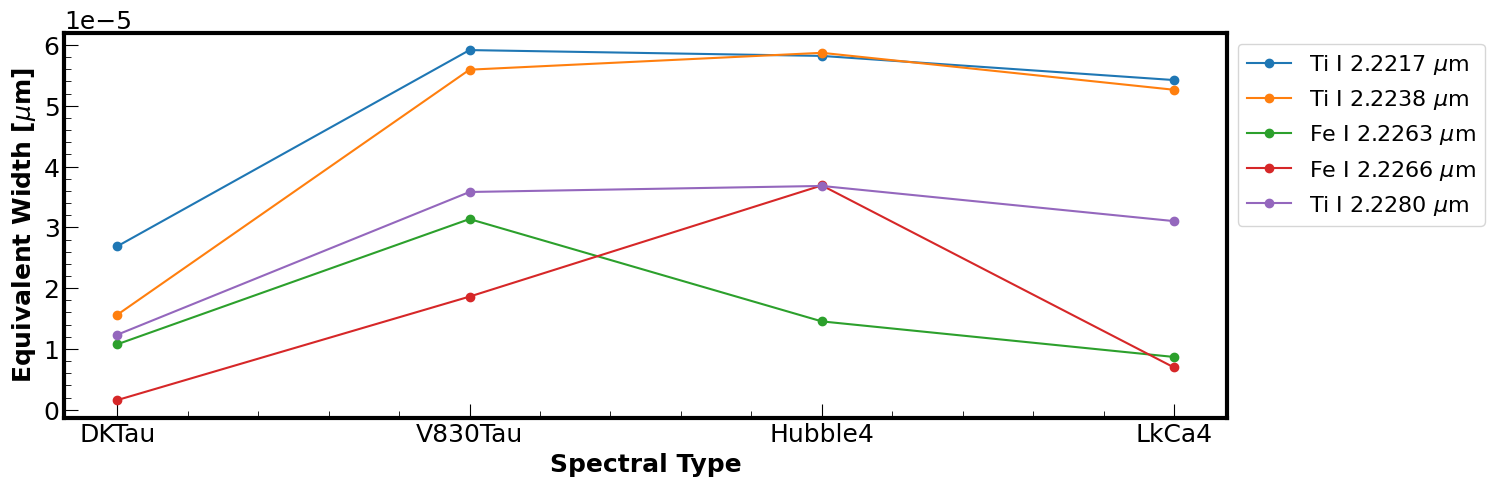

In [32]:
ew1_stack = [] # empty list to load in equivalent widths
ew2_stack = []
ew3_stack = []
ew4_stack = []
ew5_stack = []

# Integate 1-best_model to get the areas (equivalent widths) of each component Gaussian
for i in range(len(standard_table_k)):
    ew1 = np.trapz(1-ti1_2_2217_fit[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i]) # integrate the gaussian
    ew1_stack.append(ew1)

    ew2 = np.trapz(1-ti1_2_2238_fit[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i]) # integrate the gaussian
    ew2_stack.append(ew2)

    ew3 = np.trapz(1-fe1_2_2263_fit[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i]) # integrate the gaussian
    ew3_stack.append(ew3)

    ew4 = np.trapz(1-fe1_2_2266_fit[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i]) # integrate the gaussian
    ew4_stack.append(ew4)

    ew5 = np.trapz(1-ti1_2_2280_fit[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i]) # integrate the gaussian
    ew5_stack.append(ew5)

standard_table_k.loc[:,'ew_ti1_2_2217'] = ew1_stack
standard_table_k.loc[:,'ew_ti1_2_2238'] = ew2_stack
standard_table_k.loc[:,'ew_fe1_2_2263'] = ew3_stack
standard_table_k.loc[:,'ew_fe1_2_2266'] = ew4_stack
standard_table_k.loc[:,'ew_ti1_2_2280'] = ew5_stack

fig = plt.figure(figsize=(15,5))

# plt.plot(standard_table_k['Name'], standard_table_k['ew_sc1_2_2058'],ls='-',marker='o', label=f"Sc I 2.2058 $\mu$m")
# plt.plot(standard_table_k['Name'], standard_table_k['ew_na1_2_2062'],ls='-',marker='o', label=f"Na I 2.2062 $\mu$m")
# plt.plot(standard_table_k['Name'], standard_table_k['ew_si1_2_2068'],ls='-',marker='o', label=f"Si I 2.2068 $\mu$m")
# plt.plot(standard_table_k['Name'], standard_table_k['ew_na1_2_2089'],ls='-',marker='o', label=f"Na I 2.2089 $\mu$m")

plt.plot(standard_table_k['Name'], standard_table_k['ew_ti1_2_2217'],ls='-',marker='o', label=f"Ti I 2.2217 $\mu$m")
plt.plot(standard_table_k['Name'], standard_table_k['ew_ti1_2_2238'],ls='-',marker='o', label=f"Ti I 2.2238 $\mu$m")
plt.plot(standard_table_k['Name'], standard_table_k['ew_fe1_2_2263'],ls='-',marker='o', label=f"Fe I 2.2263 $\mu$m")
plt.plot(standard_table_k['Name'], standard_table_k['ew_fe1_2_2266'],ls='-',marker='o', label=f"Fe I 2.2266 $\mu$m")
plt.plot(standard_table_k['Name'], standard_table_k['ew_ti1_2_2280'],ls='-',marker='o', label=f"Ti I 2.2280 $\mu$m")

# plt.scatter(standard_table_k['Spectral_Type'], area_stack)
# plt.ylim(np.nanmedian(ew_stack)+-0.001,np.nanmedian(ew_stack)+0.001)

# plt.ylim(1e-7,1e-2)
# plt.yscale('log')

plt.xlabel('Spectral Type')
plt.ylabel(r'Equivalent Width [$\mu$m]')
# plt.title(f"{line_name} {line_center} $\mu$m")


plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## Ca Region

Ca I 2.2614

Fe I 2.2626 = lines_table[fe1_mask][29]

Ca I 2.2631

Ca I 2.2657



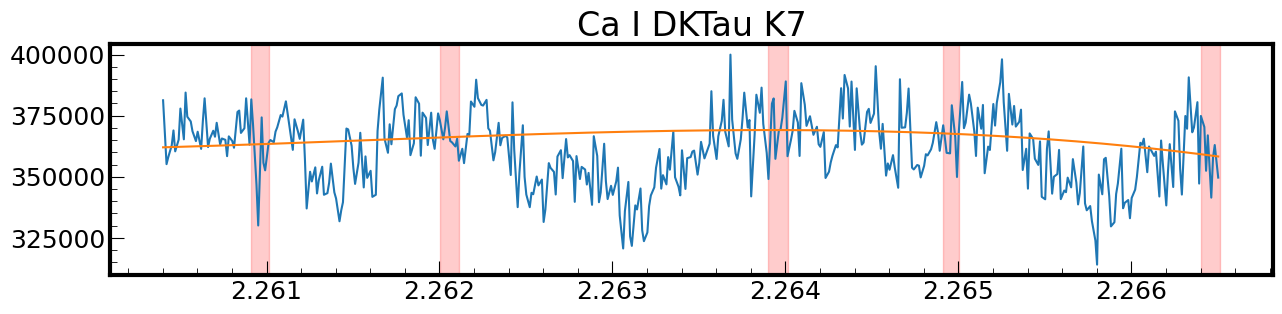

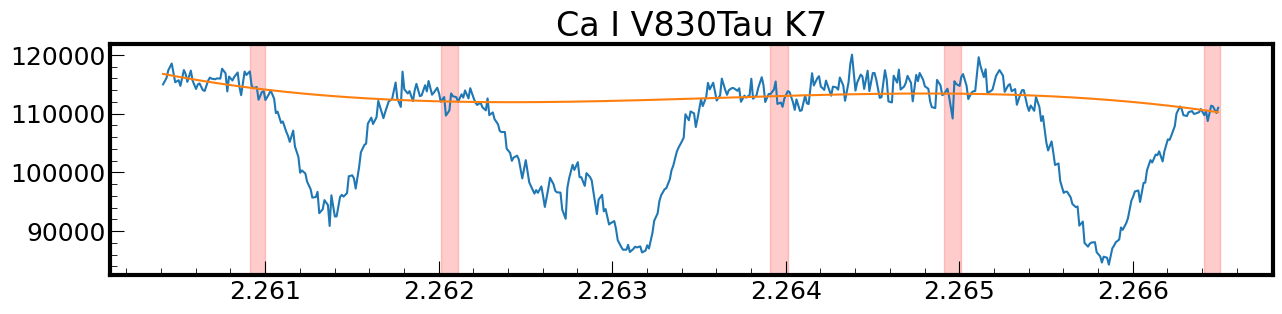

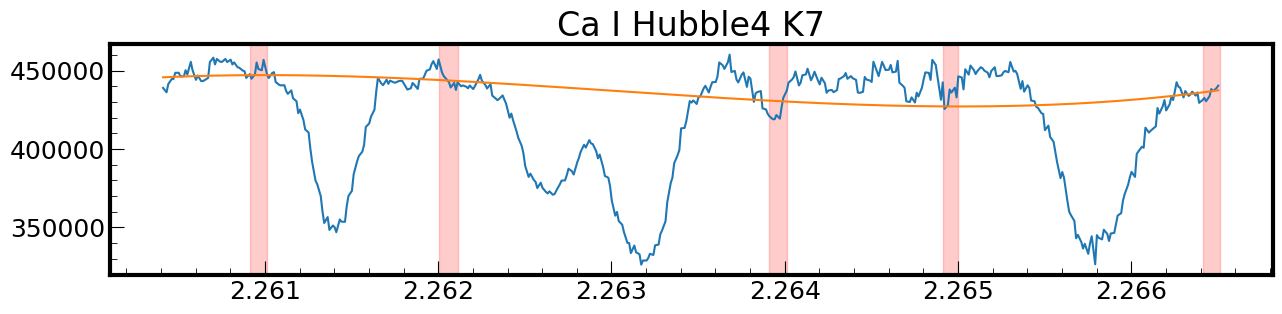

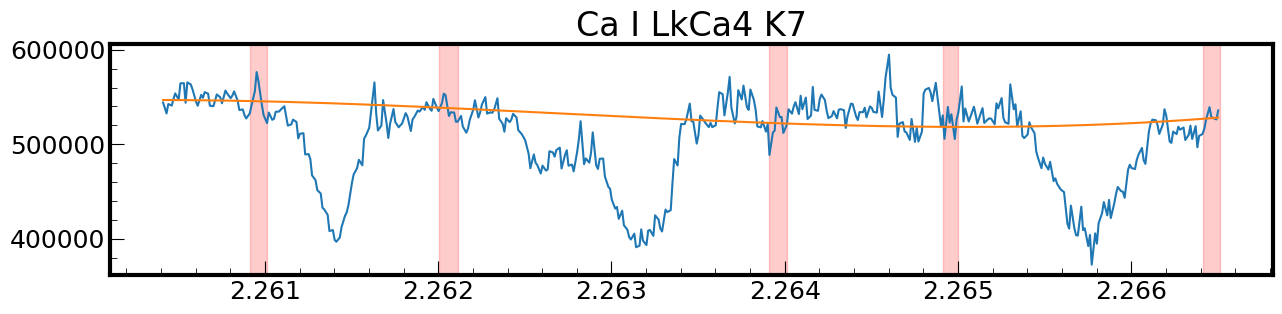

In [33]:
# Define the region for fitting
line_name = lines_table[ca1_mask][0]['Spectrum'] # Species
line_center = lines_table[ca1_mask][0]['Observed'] # Wavelength
# from igrins_mod import local_continuum_fit
continuum_stack = []
norm_flux_stack = []
reg_idx_stack = []

# regions [left point,width]
regions = [(-100,10),(-50,10),(60,10),(250,10),(350,10),(500,10)]

# number of regions I use and subtract 1 since index starts at 0
n = len(regions)-1
poly_deg = 3
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))
    continuum, region_indices = ig.local_continuum_fit(wavelen_stack[:,i],
                                                    raw_flux_stack[:,i],
                                                    poly_order = poly_deg,
                                                    line_center = line_center,
                                                    spec_res = spec_res,
                                                    regions = regions)
    # append indices to list of indices
    reg_idx_stack.append(region_indices)
    
    # append to list of the local continuum arrays
    continuum_stack.append(continuum)

    # normalize flux by dividing the flux by the continuum and create a list
    norm_flux = raw_flux_stack[region_indices[0][0]:region_indices[n][1],i]/continuum_stack[i]
    norm_flux_stack.append(norm_flux)


    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], raw_flux_stack[region_indices[0][0]:region_indices[n][1],i])
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], continuum_stack[i])

    plt.axvspan(wavelen_stack[region_indices[n][0],i],wavelen_stack[region_indices[n][1],i],color='red',alpha=.2)
    plt.axvspan(wavelen_stack[region_indices[n-1][0],i],wavelen_stack[region_indices[n-1][1],i],color='red',alpha=.2)
    plt.axvspan(wavelen_stack[region_indices[n-2][0],i],wavelen_stack[region_indices[n-2][1],i],color='red',alpha=.2)
    plt.axvspan(wavelen_stack[region_indices[n-3][0],i],wavelen_stack[region_indices[n-3][1],i],color='red',alpha=.2)
    plt.axvspan(wavelen_stack[region_indices[n-4][0],i],wavelen_stack[region_indices[n-4][1],i],color='red',alpha=.2)

    plt.title(f"{line_name} {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.show()

In [34]:
lines_table[ca1_mask]['Observed'][2]

2.265741

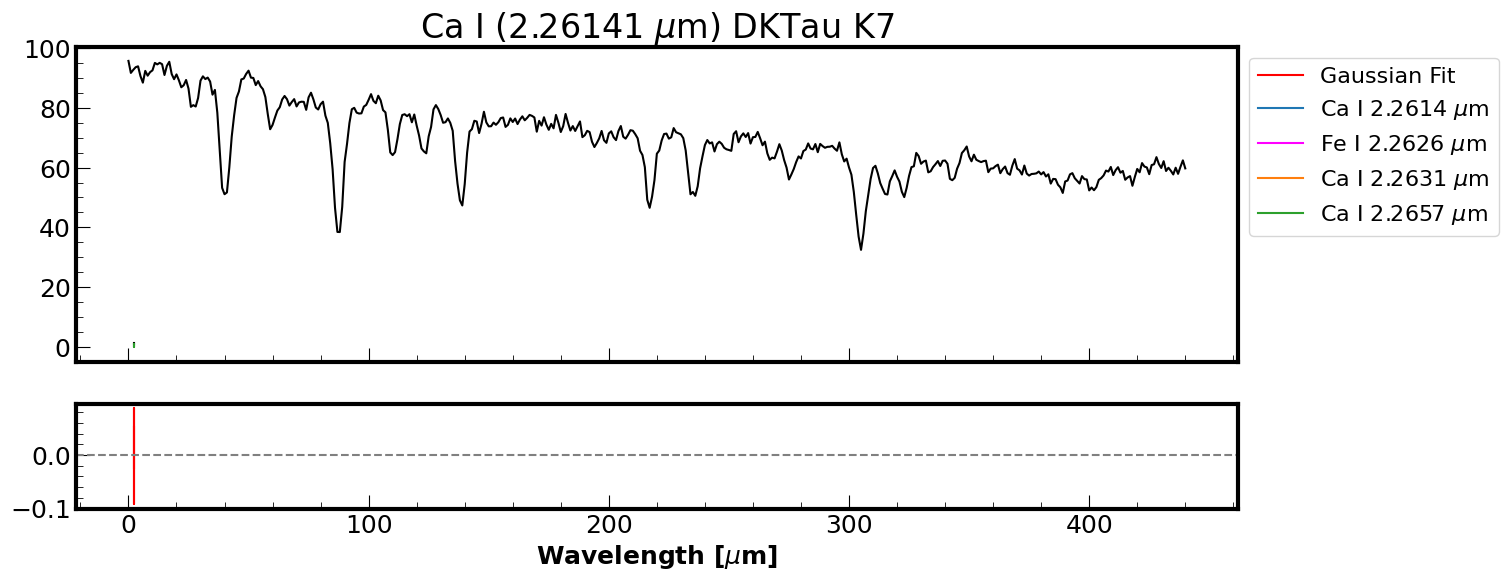

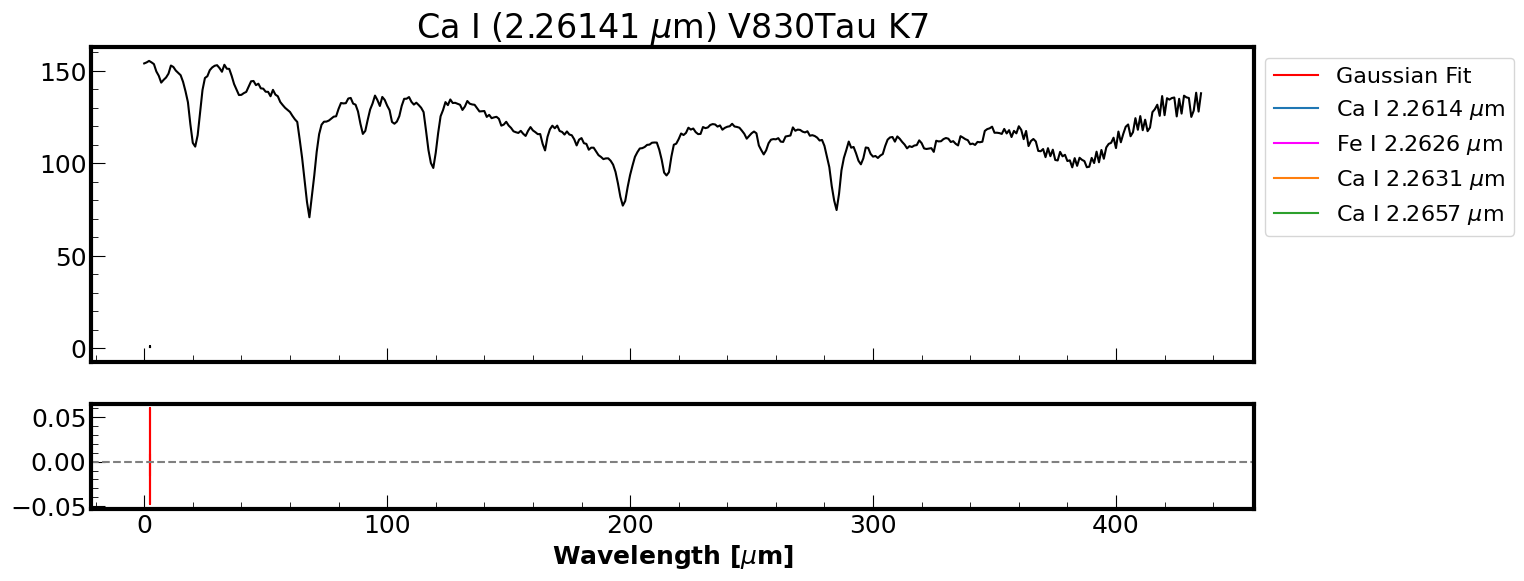

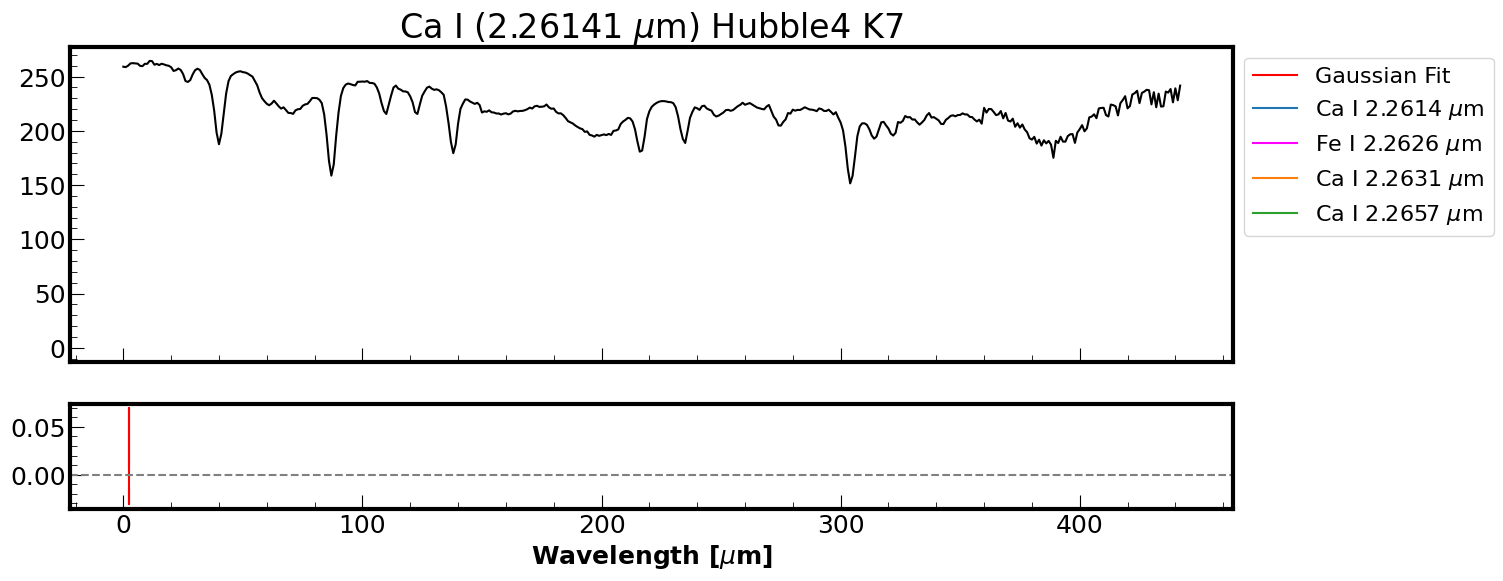

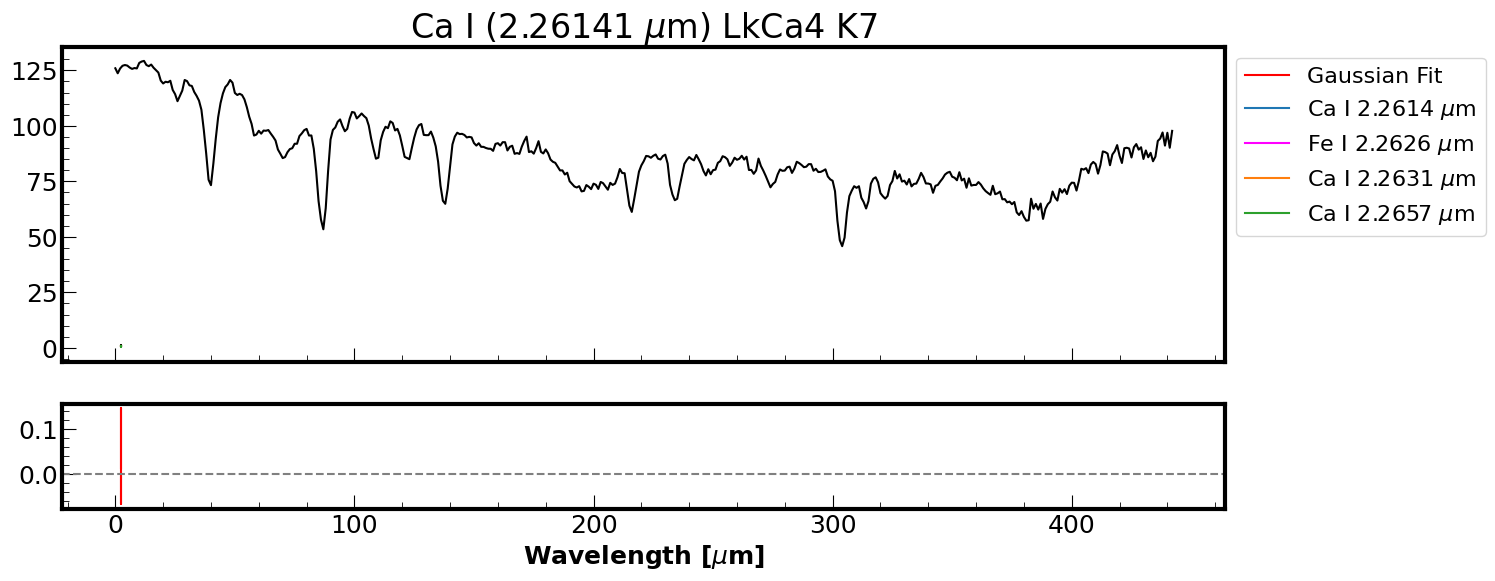

In [35]:
# min_wave = line_center - (100 * spec_res)
# max_wave = line_center + (100 * spec_res)

# Optimal parameters that will be appended from scipy curve fit below
amplitude1_stack = []
center1_stack = []
sigma_stack = []

amplitude2_stack = []
center2_stack = []

amplitude3_stack = []
center3_stack = []

amplitude4_stack = []
center4_stack = []

pcov_stack = [] # Covariant matrices
best_model_stack = [] # Best model fits

flux_constant = np.linspace(0,-1,len(standard_table_k))

# Define initial parameters for Gaussian fitting
init_params = (-0.5, line_center, spec_res,
               -0.5, lines_table[fe1_mask]['Observed'][104], spec_res,
               -0.5, lines_table[ca1_mask]['Observed'][1], spec_res,
               -0.5, lines_table[ca1_mask]['Observed'][2], spec_res)

for i in range(len(standard_table_k)):    
    # Perform Gaussian fitting for the current source
    popt, pcov, best_model = ig.four_gauss_fit(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        init_params,
                                        50000)
    # Append the Gaussian parameters, covariant matrices, and model fits as we loop through
    amplitude1_stack.append(popt[0])
    center1_stack.append(popt[1])
    sigma1_stack.append(popt[2])

    amplitude2_stack.append(popt[3])
    center2_stack.append(popt[4])
    sigma2_stack.append(popt[5])

    amplitude3_stack.append(popt[6])
    center3_stack.append(popt[7])
    sigma3_stack.append(popt[8])

    amplitude4_stack.append(popt[9])
    center4_stack.append(popt[10])
    sigma4_stack.append(popt[11])

    pcov_stack.append(pcov)
    best_model_stack.append(best_model)

# Gaussian model fits for each source
ca1_2_2614_fits = []
fe1_2_2626_fits = []
ca1_2_2631_fits = []
ca1_2_2657_fits = []

# Getting the individual Gaussians into their own lists
for i in range(len(standard_table_k)):
    ca1_2_2614_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude1_stack[i],center1_stack[i],sigma1_stack[i]))
    fe1_2_2626_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude2_stack[i],center2_stack[i],sigma2_stack[i]))
    ca1_2_2631_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude3_stack[i],center3_stack[i],sigma3_stack[i]))
    ca1_2_2657_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude4_stack[i],center4_stack[i],sigma4_stack[i]))
    

ew1_stack = []
ew2_stack = []
ew3_stack = []
ew4_stack = []

for i in range(len(standard_table_k)):
    # ew1 = np.trapz(1-ca1_2_2614_fits[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    # ew2 = np.trapz(1-ca1_2_2631_fits[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    # ew3 = np.trapz(1-ca1_2_2657_fits[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    # ew4 = np.trapz(1-fe1_2_2626_fits[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])

    ew1 = ig.gaussian_area(amplitude1_stack[i],sigma1_stack[i])
    ew2 = ig.gaussian_area(amplitude2_stack[i],sigma2_stack[i])
    ew3 = ig.gaussian_area(amplitude3_stack[i],sigma3_stack[i])
    ew4 = ig.gaussian_area(amplitude4_stack[i],sigma4_stack[i])

    ew1_stack.append(ew1)
    ew2_stack.append(ew2)
    ew3_stack.append(ew3)
    ew4_stack.append(ew4)

standard_table_k.loc[:,'ew_ca1_2_2614'] = ew1_stack
standard_table_k.loc[:,'ew_fe1_2_2626'] = ew2_stack
standard_table_k.loc[:,'ew_ca1_2_2631'] = ew3_stack
standard_table_k.loc[:,'ew_ca1_2_2657'] = ew4_stack


# Plotting each component Gaussian and the best model fit
for i in range(len(standard_table_k)):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], best_model_stack[i],c='red',label='Gaussian Fit')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],c='black')

    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2614_fits[i],label=r'Ca I 2.2614 $\mu$m')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], fe1_2_2626_fits[i],label=r'Fe I 2.2626 $\mu$m',c='magenta')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2631_fits[i],label=r'Ca I 2.2631 $\mu$m')
    ax1.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i], ca1_2_2657_fits[i],label=r'Ca I 2.2657 $\mu$m')
    

    ax1.legend(bbox_to_anchor=(1,1))
    # Calculate residuals
    residuals = norm_flux_stack[i] - best_model_stack[i]

    # Plot residuals
    ax2.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1], i], residuals, c='red', label='Residuals')
    ax2.axhline(y=0, color='grey', linestyle='--')
    ax2.set_xlabel(r'Wavelength [$\mu$m]')
    # ax2.set_ylabel('Residuals')
    # ax2.legend(bbox_to_anchor=(1, 1))

    # Title
    ax1.set_title(rf"{line_name} ({line_center} $\mu$m) {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")
    
    plt.show()

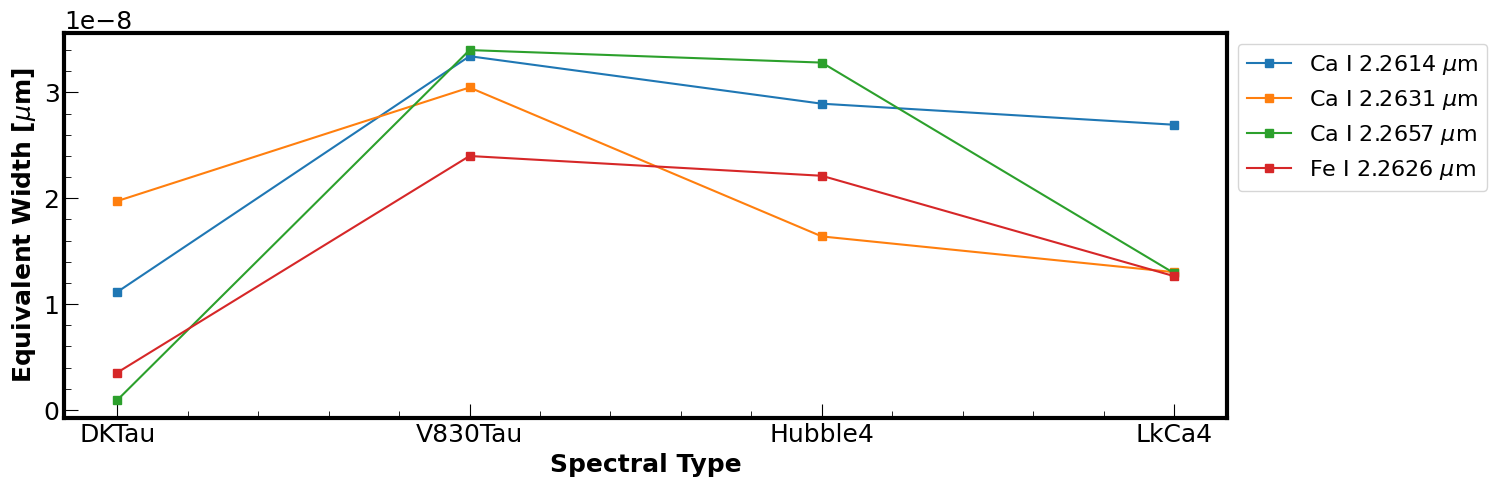

In [36]:
fig = plt.figure(figsize=(15,5))

# plt.plot(standard_table_k['Name'], standard_table_k['ew_sc1_2_2058'],ls='--',marker='p', label=f"Sc I 2.2058 $\mu$m")
# plt.plot(standard_table_k['Name'], standard_table_k['ew_na1_2_2062'],ls='--',marker='p', label=f"Na I 2.2062 $\mu$m")
# plt.plot(standard_table_k['Name'], standard_table_k['ew_si1_2_2068'],ls='--',marker='p', label=f"Si I 2.2068 $\mu$m")
# plt.plot(standard_table_k['Name'], standard_table_k['ew_na1_2_2089'],ls='--',marker='p', label=f"Na I 2.2089 $\mu$m")

# plt.plot(standard_table_k['Name'], np.abs(standard_table_k['ew_fe1_2_2263']),ls='-.',marker='o', label=f"Fe I 2.2263 $\mu$m")
# plt.plot(standard_table_k['Name'], standard_table_k['ew_fe1_2_2266'],ls='-.',marker='o', label=f"Fe I 2.2266 $\mu$m")

plt.plot(standard_table_k['Name'], standard_table_k['ew_ca1_2_2614'],ls='-',marker='s', label=f"Ca I 2.2614 $\mu$m")
plt.plot(standard_table_k['Name'], standard_table_k['ew_ca1_2_2631'],ls='-',marker='s', label=f"Ca I 2.2631 $\mu$m")
plt.plot(standard_table_k['Name'], standard_table_k['ew_ca1_2_2657'],ls='-',marker='s', label=f"Ca I 2.2657 $\mu$m")
plt.plot(standard_table_k['Name'], standard_table_k['ew_fe1_2_2626'],ls='-',marker='s', label=f"Fe I 2.2626 $\mu$m")

# plt.scatter(standard_table_k['Spectral_Type'], area_stack)
# plt.ylim(np.nanmedian(ew_stack)+-0.001,np.nanmedian(ew_stack)+0.001)

# plt.ylim(-0.0001,0.0005)
# plt.yscale('log')

plt.xlabel('Spectral Type')
plt.ylabel(r'Equivalent Width [$\mu$m]')
# plt.title(f"{line_name} {line_center} $\mu$m")

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## Mg, Ca, Fe ~ 2.28 micron

Mg I 2.2813 = lines_table[mg1_mask][8]

Fe I 2.2838 = lines_table[fe1_mask][115] (possible 116)

Ca ? = 2.285?

In [37]:
lines_table[fe1_mask][115]

<Row index=115>
Spectrum  Observed    Ritz   Transition  Rel.   Aki     fik   Acc.          Ei           Ek                         Lower level                                      Upper level                      Type   TP   Line 
  str5    float64    str18    float64   str17 float64 float64 str3               str40                                 str45                                            str59                         str5 str17 str20 
-------- --------- --------- ---------- ----- ------- ------- ---- --------------------------------- ------------------------------------------ ----------------------------------------------------- ---- ----- ------
    Fe I 2.2838594 2.2838595   4378.553   427      --      --   -- 5.09954435        -    5.64241573 3d6.(5D).4s.4p.(1P*)      | x 5F*      | 1 3d6.(5D).4s (6D).5s                 | e 5D        | 1   --    -- L11631

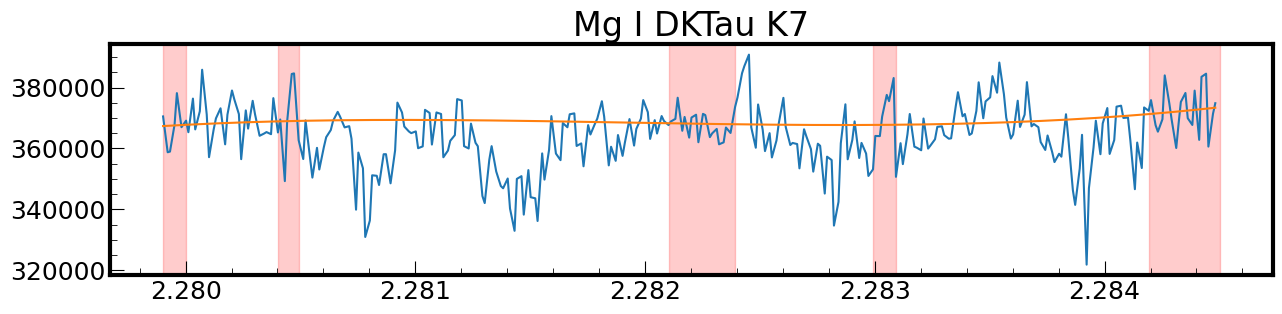

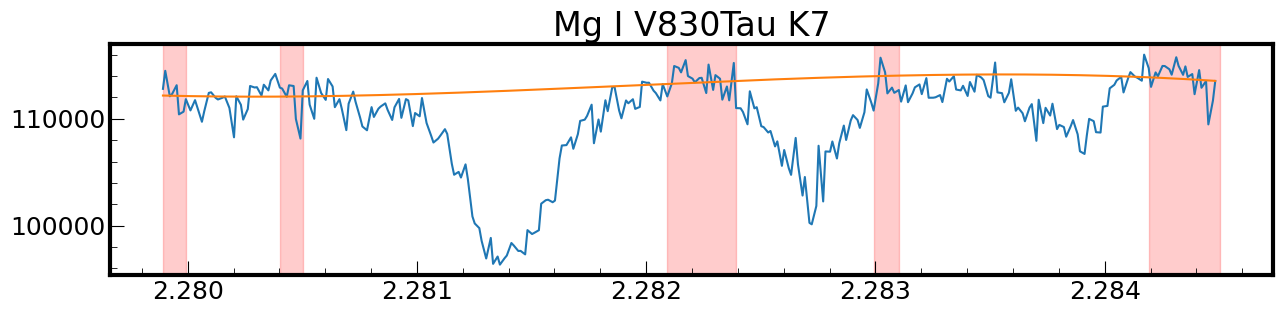

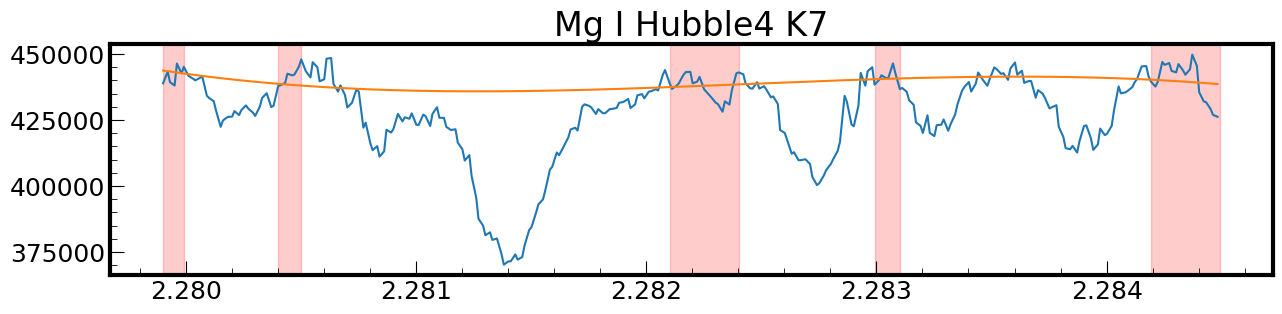

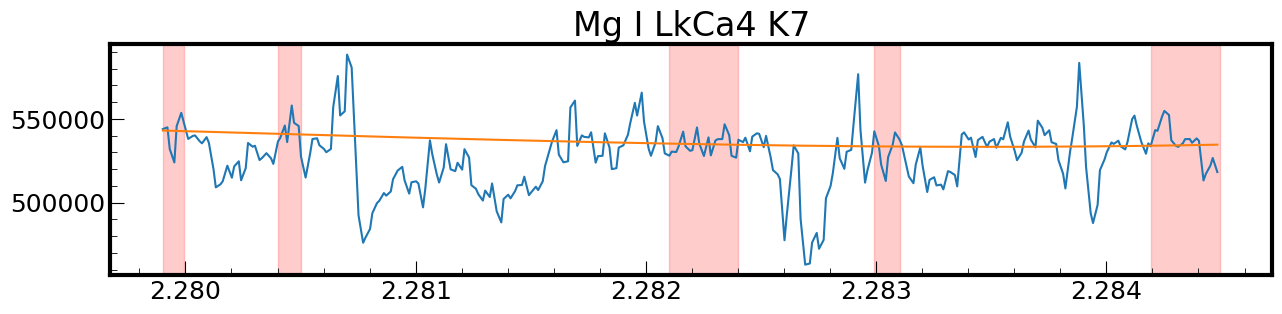

In [38]:
# Define the region for fitting
line_name = lines_table[mg1_mask][0]['Spectrum'] # Species
line_center = lines_table[mg1_mask][8]['Observed'] # Wavelength

# from igrins_mod import local_continuum_fit
continuum_stack = []
norm_flux_stack = []
reg_idx_stack = []

# regions [left point,width]
regions = [(-150,10), (-100,10), (70,30), (160,10), (280,30)]

# number of regions I use and subtract 1 since index starts at 0
n = len(regions)-1
poly_deg = 3
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))
    continuum, region_indices = ig.local_continuum_fit(wavelen_stack[:,i],
                                                    raw_flux_stack[:,i],
                                                    poly_order = poly_deg,
                                                    line_center = line_center,
                                                    spec_res = spec_res,
                                                    regions = regions)
    # append indices to list of indices
    reg_idx_stack.append(region_indices)
    
    # append to list of the local continuum arrays
    continuum_stack.append(continuum)

    # normalize flux by dividing the flux by the continuum and create a list
    norm_flux = raw_flux_stack[region_indices[0][0]:region_indices[n][1],i]/continuum_stack[i]
    norm_flux_stack.append(norm_flux)

    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], raw_flux_stack[region_indices[0][0]:region_indices[n][1],i])
    plt.plot(wavelen_stack[region_indices[0][0]:region_indices[n][1],i], continuum_stack[i])
    for j in range(len(region_indices)):
        plt.axvspan(wavelen_stack[region_indices[n-j][0],i],wavelen_stack[region_indices[n-j][1],i],color='red',alpha=.2)

    plt.title(f"{line_name} {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.show()

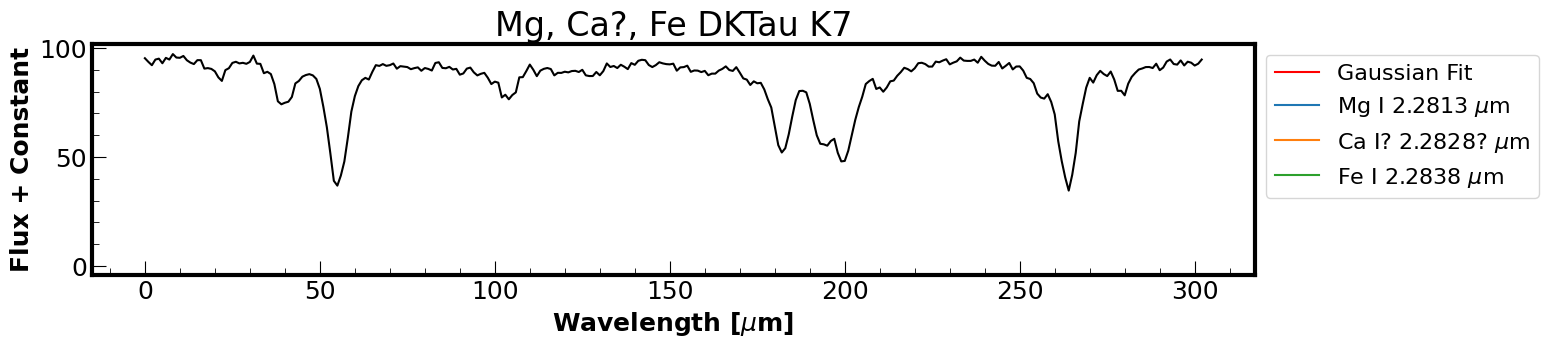

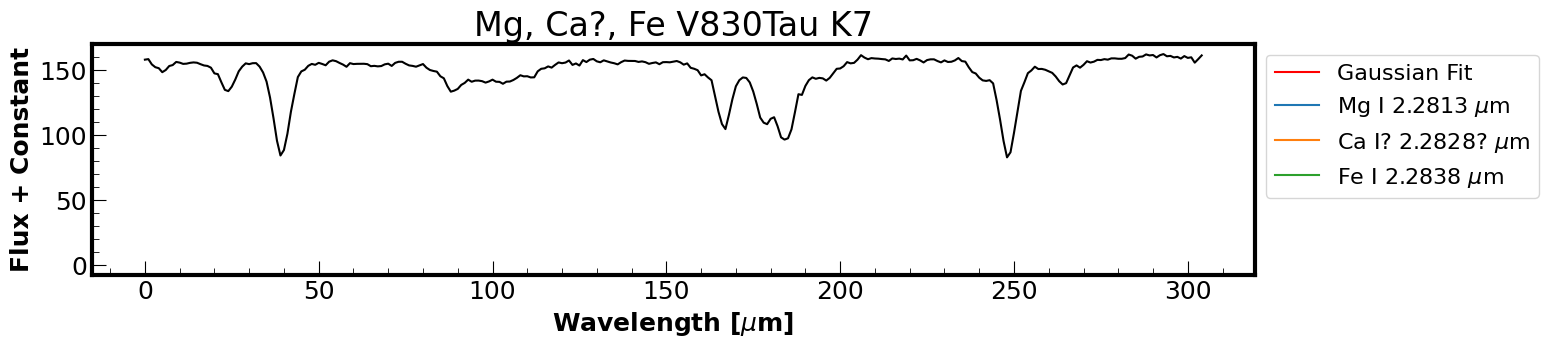

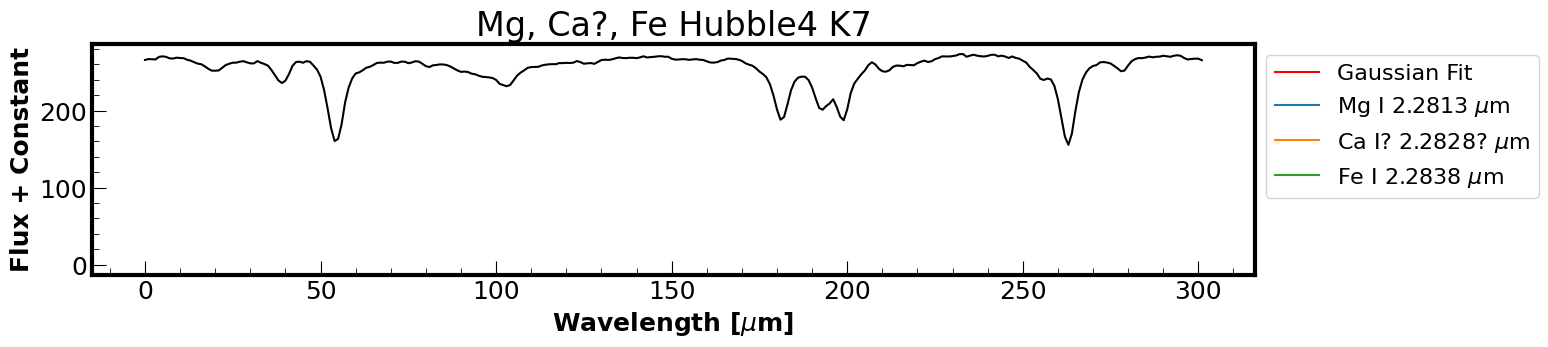

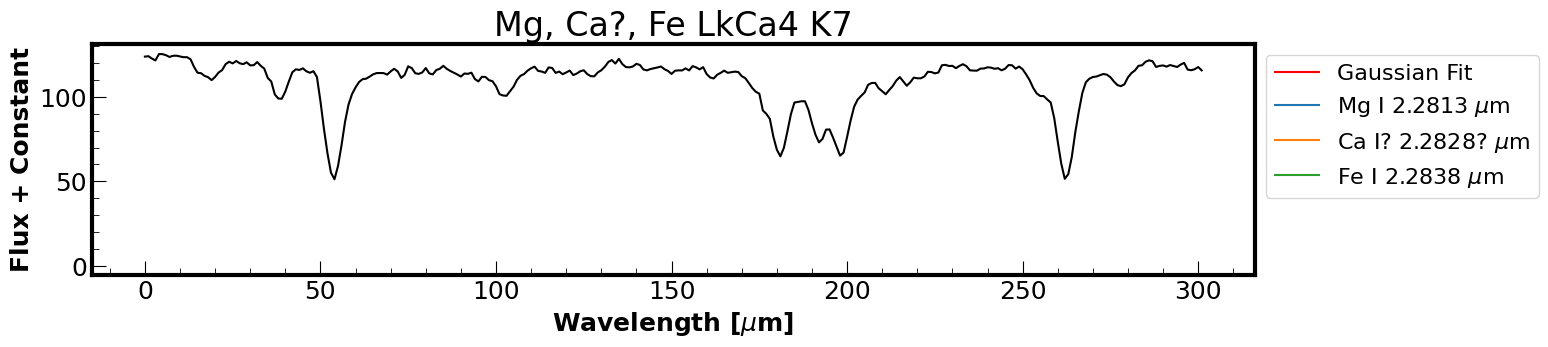

In [39]:
# min_wave = line_center - (100 * spec_res)
# max_wave = line_center + (100 * spec_res)

# Optimal parameters that will be appended from scipy curve fit below
amplitude1_stack = []
center1_stack = []
sigma_stack = []

amplitude2_stack = []
center2_stack = []

amplitude3_stack = []
center3_stack = []

pcov_stack = [] # Covariant matrices
best_model_stack = [] # Best model fits

flux_constant = np.linspace(0,-1,len(standard_table_k))

# Define initial parameters for Gaussian fitting
init_params = ( -0.1, line_center, spec_res,
                -0.1, lines_table[fe1_mask]['Observed'][115], spec_res,
                -0.1, 2.2828, spec_res)

for i in range(len(standard_table_k)):    
    # Perform Gaussian fitting for the current source
    popt, pcov, best_model = ig.three_gauss_fit(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],
                                        init_params,
                                        50000)
    # Append the Gaussian parameters, covariant matrices, and model fits as we loop through
    amplitude1_stack.append(popt[0])
    center1_stack.append(popt[1])
    sigma_stack.append(popt[2])

    amplitude2_stack.append(popt[3])
    center2_stack.append(popt[4])

    amplitude3_stack.append(popt[5])
    center3_stack.append(popt[6])

    # amplitude4_stack.append(popt[7])
    # center4_stack.append(popt[8])

    pcov_stack.append(pcov)
    best_model_stack.append(best_model)

# Gaussian model fits for each source
mg1_2_2813_fits = []
fe1_2_2838_fits = []
ca1_2_2830_fits = []

# Getting the individual Gaussians into their own lists
for i in range(len(standard_table_k)):
    mg1_2_2813_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude1_stack[i],center1_stack[i],sigma_stack[i]))
    fe1_2_2838_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude2_stack[i],center2_stack[i],sigma_stack[i]))
    ca1_2_2830_fits.append(ig.gaussian(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],amplitude3_stack[i],center3_stack[i],sigma_stack[i]))

ew1_stack = []
ew2_stack = []
ew3_stack = []
# ew4_stack = []
for i in range(len(standard_table_k)):
    ew1 = np.trapz(1-mg1_2_2813_fits[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    ew2 = np.trapz(1-fe1_2_2838_fits[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])
    ew3 = np.trapz(1-ca1_2_2830_fits[i],wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i])

    ew1_stack.append(ew1)
    ew2_stack.append(ew2)
    ew3_stack.append(ew3)

standard_table_k.loc[:,'ew_mg1_2_2813'] = ew1_stack
standard_table_k.loc[:,'ew_fe1_2_2838'] = ew2_stack
standard_table_k.loc[:,'ew_ca1_2_2828'] = ew3_stack

# Plotting each component Gaussian and the best model fit
for i in range(len(standard_table_k)):
    fig = plt.figure(figsize=(15,3))

    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],best_model_stack[i],c='red',label='Gaussian Fit')
    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],norm_flux_stack[i], raw_flux_err_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],c='black')

    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],mg1_2_2813_fits[i],label=r'Mg I 2.2813 $\mu$m')
    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],ca1_2_2830_fits[i],label=r'Ca I? 2.2828? $\mu$m')
    plt.plot(wavelen_stack[reg_idx_stack[i][0][0]:reg_idx_stack[i][n][1],i],fe1_2_2838_fits[i],label=r'Fe I 2.2838 $\mu$m')
    
    
    # plt.axvline()
    plt.title(rf"Mg, Ca?, Fe {standard_table_k['Name'][i]} {standard_table_k['Spectral_Type'][i]}")

    plt.ylabel('Flux + Constant')
    plt.xlabel(r'Wavelength [$\mu$m]')
    plt.legend(bbox_to_anchor=(1,1))
    
    plt.show()

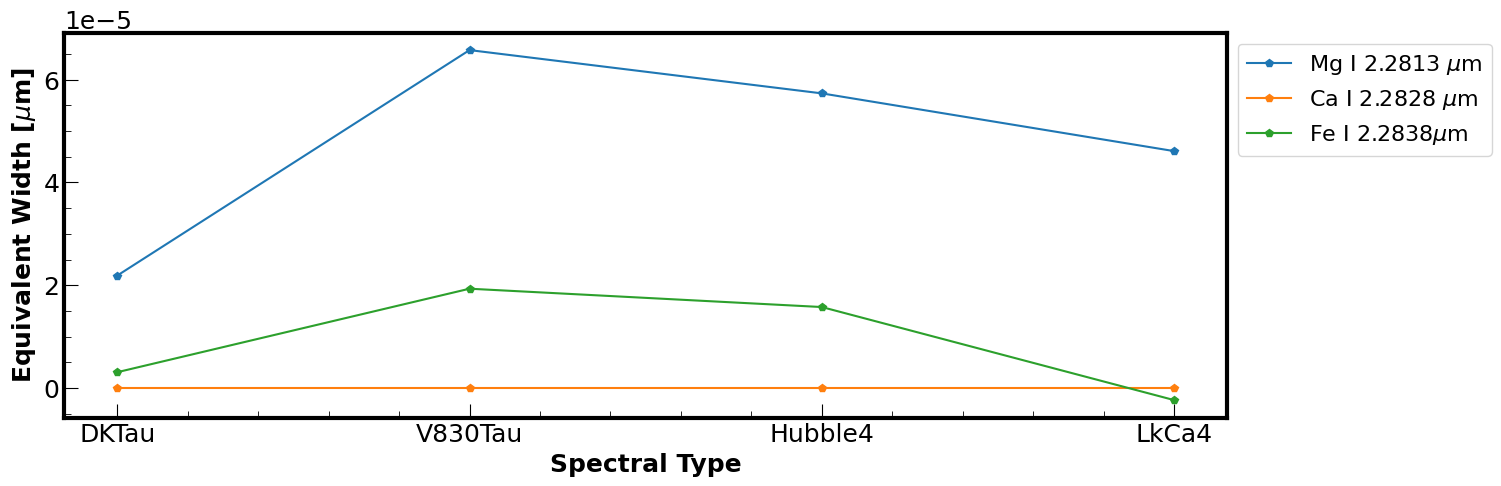

In [40]:
fig = plt.figure(figsize=(15,5))

plt.plot(standard_table_k['Name'], standard_table_k['ew_mg1_2_2813'],ls='-',marker='p', label=f"Mg I 2.2813 $\mu$m")
plt.plot(standard_table_k['Name'], standard_table_k['ew_ca1_2_2828'],ls='-',marker='p', label=f"Ca I 2.2828 $\mu$m")
plt.plot(standard_table_k['Name'], standard_table_k['ew_fe1_2_2838'],ls='-',marker='p', label=f"Fe I 2.2838$\mu$m")

# plt.scatter(standard_table_k['Spectral_Type'], area_stack)
# plt.ylim(np.nanmedian(ew_stack)+-0.001,np.nanmedian(ew_stack)+0.001)

# plt.ylim(-0.0001,0.0002)
# plt.yscale('log')

plt.xlabel('Spectral Type')
plt.ylabel(r'Equivalent Width [$\mu$m]')
# plt.title(f"{line_name} {line_center} $\mu$m")

plt.legend(bbox_to_anchor=(1,1))
plt.show()